In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import time
import random
import pickle


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, roc_curve, recall_score, roc_auc_score, mean_squared_error, mean_absolute_error
from math import sqrt, log
from sklearn.metrics import accuracy_score, classification_report, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RidgeClassifier, LinearRegression, Ridge
import graphviz

from sklearn.tree import tree, export_graphviz, DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from matplotlib import pyplot as plt
from IPython.display import Image, display
from sklearn.utils import class_weight
from xgboost import XGBClassifier
import xgboost
import re
#%matplotlib inline
#plt.style.use('ggplot')
SEED = 42
np.random.seed(SEED)

from selenium import webdriver
from bs4 import BeautifulSoup
from time import sleep
from fake_useragent import UserAgent
import requests
import shutil
import os
from webdriver_manager.chrome import ChromeDriverManager

pd.set_option("display.max_rows", 500)
pd.set_option('display.max_columns', None)


/opt/anaconda3/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.tree.tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.tree. Anything that cannot be imported from sklearn.tree is now part of the private API.
  warnings.warn(message, FutureWarning)


# Download files

## HESA aggregated tables

In [20]:
dic_prop_course_job = {"1_M": "Table 8a", 
                       "2_M":"Table 8b", 
                       "1_H":"Table 8d", 
                       "2_H":"Table 8e"}



In [21]:
dict_prop_region = {1:"Postgraduate", 2:"First degree", 3:"Other undergraduate"}

In [22]:
l_job_areas = ["Agriculture, forestry and fishing",
            "Mining and quarrying",
            "Manufacturing",
            "Electricity, gas, steam and air conditioning supply",
            "Water supply, sewerage, waste management and remediation activities",
            "Construction",
            "Wholesale and retail trade; repair of motor vehicles and motorcycles",
            "Transport and storage",
            "Accommodation and food service activities",
            "Information and communication",
            "Financial and insurance activities",
            "Real estate activities",
            "Professional, scientific and technical activities",
            "Administrative and support service activities",
            "Public administration and defence; compulsory social security",
            "Education",
            "Human health and social work activities",
            "Arts, entertainment and recreation",
            "Other service activities",
            "Activities of households as employers; undifferentiated goods- and services-producing activities of households for own use",
            "Activities of extraterritorial organisations and bodies"]

l_jacs = ["Medicine & dentistry",
          "Subjects allied to medicine",
          "Biological sciences",
          "Veterinary science",
          "Agriculture & related subjects",
          "Physical sciences",
          "Mathematical sciences",
          "Computer science",
          "Engineering & technology",
          "Architecture, building & planning",
          "Social studies",
          "Law",
          "Business & administrative studies",
          "Mass communications & documentation",
          "Languages",
          "Historical & philosophical studies",
          "Creative arts & design",
          "Education"]

            

In [23]:
def download_course_to_job_df(sheet_name):
    
    '''
    Return a clean dataframe of the number of UK domiciled by sex (either male or female) who 
    obtained certai qualifications (undergrad or postgrad) and were in employment by subject of study 
    and Standard Industrial Classification of employer 
        @sheet_name: name of the sheet (either undergrad/male, undergrad/female, postfrad/male or postgrad/female)
    '''

    job = pd.read_excel("../../data/raw_datasets/HESA_final/dlhe_1617_all_main_tables.xlsx", 
                        sheet_name = sheet_name, 
                        header = 3)
    
    job = job.dropna(subset = ["Unnamed: 0"])
    job["Unnamed: 0"] = job["Unnamed: 0"].str.strip()
    job = job.set_index("Unnamed: 0")
    job = job.drop("Unknown", axis = 1)
    
    #add total to jacs code
    l_jacs_total = [i + " total"for i in l_jacs]
    
    #add total to job area
    l_job_areas_total = [i + " total" for i in l_job_areas]
    
    #select and filter only total course and jobs
    job = job.loc[l_jacs_total, l_job_areas_total]
    
    return job

def download_geography_after_grad(dict_prop_region):
    
    '''
    Return dictionary of regions graduated students go to work by regions of unversity study.
    One key is for postgrad, another for first degree and another for other undergrad
        @dict_prop_region: A dictionary 
    '''

    
    geo = pd.read_excel("../../data/raw_datasets/HESA_final/dlhe_1617_all_main_tables.xlsx", 
                        sheet_name = "Table 12b", 
                        header = 3)

    geo = geo.dropna(subset = ["Region of HE provider"])
    
    for i in dict_prop_region.keys():
        
        temp_value = dict_prop_region[i]
        
        #select posgrad, then first degree, then other undrgrad
        dict_prop_region[i] = geo.iloc[(i-1)*16:i*16, :]
        
        #filter for rows we dont need
        dict_prop_region[i] = dict_prop_region[i][(dict_prop_region[i]["Region of HE provider"] != temp_value)] 
        dict_prop_region[i] = dict_prop_region[i][np.logical_not(dict_prop_region[i]["Region of HE provider"].str.contains("Total"))]
        dict_prop_region[i] = dict_prop_region[i][(dict_prop_region[i]["Region of HE provider"] != "The Open University")]
        dict_prop_region[i] = dict_prop_region[i][(dict_prop_region[i]["Region of HE provider"] != "Northern Ireland")]
        
        #filter for columns we dont need
        dict_prop_region[i] =  dict_prop_region[i].drop(["Total England", 
                                                         "Total UK", 
                                                         "Northern Ireland", 
                                                         "England region unknown", 
                                                         "Guernsey, Jersey and the Isle of Man", 
                                                         "UK region unknown"], axis = 1)
        
    return dict_prop_region
    

In [24]:
for i in dic_prop_course_job.keys():
    
    dic_prop_course_job[i] = download_course_to_job_df(dic_prop_course_job[i])

In [25]:
dict_prop_region = download_geography_after_grad(dict_prop_region)

## Salary aggregated table

In [116]:
dict_salary_region_job = {"1":"Male Full-Time", "2":"Female Full-Time"}

In [117]:
def dowloand_salary_region_df(sheet_name):

    df_salary_region_job = pd.read_excel("../../data/raw_datasets/HESA_final/PROV - SIC07 Work Region Industry (2) SIC2007 Table 5.7a   Annual pay - Gross 2019.xls", 
                            sheet_name = sheet_name, 
                            header = 4)

    return df_salary_region_job


In [118]:
l_sex = ["1", "2"]

for s in l_sex:
    dict_salary_region_job[s] = dowloand_salary_region_df(dict_salary_region_job[s])

## university to region table

In [129]:
df_uni_region = pd.read_excel("../../data/raw_datasets/HESA_final/University Region.xlsx")

## HESA individual level table

In [134]:
#Main dataframe
link = "../../data/raw_datasets/HESA_final/_148593_Data.csv"
df = pd.read_csv(link)

In [160]:
#uni ranking
link_uni_all = "../../data/raw_datasets/HESA_final/uni_ranking.csv"

df_uni_all = pd.read_csv(link_uni_all)

In [162]:
#HESA dictionary 
link_dict = "../../data/raw_datasets/HESA_final/List of HESA variables.xlsx"
df_dict = pd.read_excel(link_dict, sheet_name = "Field_Labelling", header = 2)
df_dict_title = pd.read_excel(link_dict, sheet_name = "Field_Order", header = 2)

In [165]:
#median salary by university 
link_HESA_salary = "../../data/raw_datasets/HESA/Unistats Record 2019_2020/SALARY.csv"
df_HESA_salary = pd.read_csv(link_HESA_salary)

In [167]:
link_HESA_inst = "../../data/raw_datasets/HESA/Unistats Record 2019_2020/KISCOURSE.csv"
df_HESA_inst = pd.read_csv(link_HESA_inst)

In [156]:
dict_files = {}
import os

for filename in os.listdir("../../data/raw_datasets/HESA/Unistats Record 2019_2020/"):
    
    if filename.endswith(".csv"):
        dict_files[filename] = pd.read_csv("../../data/raw_datasets/HESA/Unistats Record 2019_2020/" + filename)    
        


In [8]:
j = 1
for i in dict_files.keys():
    print("file " + str(j) + " cols are " + i + ":", dict_files[i].columns)
    j += 1

file 1 cols are COMMON.csv: Index(['PUBUKPRN', 'UKPRN', 'KISCOURSEID', 'KISMODE', 'COMUNAVAILREASON',
       'COMPOP', 'COMRESP_RATE', 'COMAGG', 'COMSBJ'],
      dtype='object')
file 2 cols are ACCREDITATION.csv: Index(['PUBUKPRN', 'UKPRN', 'KISCOURSEID', 'KISMODE', 'ACCTYPE', 'ACCDEPEND',
       'ACCDEPENDURL', 'ACCDEPENDURLW'],
      dtype='object')
file 3 cols are log_updates.csv: Index(['UKPRN', 'PROVIDER_NAME', 'UPDATED'], dtype='object')
file 4 cols are COURSELOCATION.csv: Index(['PUBUKPRN', 'UKPRN', 'KISCOURSEID', 'KISMODE', 'LOCID'], dtype='object')
file 5 cols are INSTITUTION.csv: Index(['PUBUKPRN', 'UKPRN', 'COUNTRY', 'PUBUKPRNCOUNTRY', 'TEFOutcome',
       'APROutcome', 'SUURL', 'SUURLW'],
      dtype='object')
file 6 cols are log_summary.csv: Index(['UKPRN', 'PROVIDER_NAME', 'DATASET_ITEM_AFFECTED', 'WEBSITE_SECTION',
       'NUMBER OF COURSES', 'DATE', 'NOTES'],
      dtype='object')
file 7 cols are ENTRY.csv: Index(['PUBUKPRN', 'UKPRN', 'KISCOURSEID', 'KISMODE', 'ENTUNAVA

In [157]:
#merged df

df_salary = df_HESA_salary[["UKPRN", "KISCOURSEID", "MED"]]
df_course = dict_files["KISCOURSE.csv"][["KISCOURSEID", "TITLE"]]
merged_df = pd.merge(df_salary, df_course, on = "KISCOURSEID")
merged_df = merged_df.dropna(subset = ["MED"])
merged_df = merged_df.drop_duplicates(["UKPRN","TITLE"])

In [10]:
#uni name matching
#select only labels related to university names
uni_name_H1 = df_dict[df_dict["Field Name"] == "F_XINSTID01"]

#clean the university name column by removing the figures before
uni_name_H1["uni_name"] = uni_name_H1["Label"].str[5:]
uni_name_H2 = dict_files["log_updates.csv"].drop_duplicates(subset = ["UKPRN"])

uni_name_df = pd.merge(uni_name_H1, uni_name_H2, left_on = "uni_name", right_on = "PROVIDER_NAME")
uni_name_df = uni_name_df[["Data", "uni_name", "UKPRN"]]
uni_name_df["Data"] = pd.to_numeric(uni_name_df["Data"])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
#course name matching
course_name_H1 = df_dict[df_dict["Field Name"] == "F_XJACS01"]

course_name_H1["course_name"] = course_name_H1["Label"].str[7:]
course_name_H1 = course_name_H1[["Data", "course_name"]]
course_name_H1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Data                                        course_name
167   A100                              Pre-clinical medicine
168   A200                             Pre-clinical dentistry
169   A300                                  Clinical medicine
170   A400                                 Clinical dentistry
171   A900                     Others in medicine & dentistry
...    ...                                                ...
1299  X370      Academic studies in education (across phases)
1300  X390  Academic studies in education not elsewhere cl...
1301  X900                                Others in education
1302  X990                 Education not elsewhere classified
1303  Y000                                           Combined

[1137 rows x 2 columns]

In [12]:
#main df 
salary_H1 = processing(df, prediction = "salary", type_y = "continuous", classes = "only salary")
salary_H1 = salary_H1[["F_XINSTID01", "F_XJACS01", "salary"]]

NameError: name 'processing' is not defined

In [720]:
#join everything
merged_all = pd.merge(salary_H1, uni_name_df, left_on = "F_XINSTID01", right_on = "Data")
merged_all = pd.merge(merged_all, course_name_H1, left_on = "F_XJACS01", right_on = "Data")
merged_all = pd.merge(merged_all, merged_df, left_on = ["UKPRN", "course_name"], right_on = ["UKPRN", "TITLE"])


In [713]:
merged_df[(merged_df["UKPRN"] == 10000291) & (merged_df["TITLE"] == "Architecture")]

UKPRN KISCOURSEID      MED         TITLE
117  10000291      K00143  19000.0  Architecture
158  10000291      K00211  19000.0  Architecture

In [716]:
merged_df.drop_duplicates(["UKPRN","TITLE"])

UKPRN              KISCOURSEID      MED  \
1      10000055                     AB27  17500.0   
7      10000055                     AB36  17500.0   
23     10000248                      3YA  19000.0   
25     10000291                   K00001  20000.0   
26     10000291                   K00004  18000.0   
...         ...                      ...      ...   
58993  10080811                     DF42  18000.0   
59001  10080811                     G60G  18000.0   
59003  10080811                     NCF6  19000.0   
59006  99999998  UUBMEDSGWY6~UUBMEDSGWY6  31000.0   
59007  99999998   UUBMEDSMED5~UBMEDSYRK5  31000.0   

                                          TITLE  
1             Animal Behaviour & Welfare Top Up  
7      Animal Therapy and Rehabilitation Top Up  
23                                       Acting  
25                                          Law  
26                                     Fine Art  
...                                         ...  
58993                Equine Business Management  
59001                 Strength and Conditioning  
59003                Sports Business Management  
59006              Medicine with a Gateway Year  
59007                                  Medicine  

[22652 rows x 4 columns]

In [722]:
merged_all["diff"] = merged_all["MED"] - merged_all["salary"]
merged_all["diff"] = merged_all["diff"].abs()

In [723]:
merged_all["diff"].mean()

5936.793065568143

In [724]:
merged_all

F_XINSTID01 F_XJACS01   salary  Data_x  \
0              126      B700  10000.0     126   
1              126      B700  25000.0     126   
2              126      B700  30000.0     126   
3              126      B700  25000.0     126   
4              126      B700  25000.0     126   
...            ...       ...      ...     ...   
58255          179      Q560  20000.0     179   
58256          179      Q560  25000.0     179   
58257           89      J310  15000.0      89   
58258           89      J310  15000.0      89   
58259           89      J310  25000.0      89   

                              uni_name     UKPRN Data_y course_name  \
0          The University of Liverpool  10006842   B700     Nursing   
1          The University of Liverpool  10006842   B700     Nursing   
2          The University of Liverpool  10006842   B700     Nursing   
3          The University of Liverpool  10006842   B700     Nursing   
4          The University of Liverpool  10006842   B700     Nursing   
...                                ...       ...    ...         ...   
58255               Cardiff University  10007814   Q560       Welsh   
58256               Cardiff University  10007814   Q560       Welsh   
58257  Cardiff Metropolitan University  10007854   J310    Ceramics   
58258  Cardiff Metropolitan University  10007854   J310    Ceramics   
58259  Cardiff Metropolitan University  10007854   J310    Ceramics   

      KISCOURSEID      MED     TITLE     diff  
0          B_NURS  22000.0   Nursing  12000.0  
1          B_NURS  22000.0   Nursing   3000.0  
2          B_NURS  22000.0   Nursing   8000.0  
3          B_NURS  22000.0   Nursing   3000.0  
4          B_NURS  22000.0   Nursing   3000.0  
...           ...      ...       ...      ...  
58255    UFBAWELA  18000.0     Welsh   2000.0  
58256    UFBAWELA  18000.0     Welsh   7000.0  
58257        W232  17000.0  Ceramics   2000.0  
58258        W232  17000.0  Ceramics   2000.0  
58259        W232  17000.0  Ceramics   8000.0  

[58260 rows x 12 columns]

# Scraping of complete university guide

In [ ]:
driver = webdriver.Chrome(ChromeDriverManager().install())

r = ["", "/arts-music-institutions"]
final_data_frame = pd.DataFrame(columns=["university", "ranking", "type"])
uni_type = 1

for j in r:
    
    url = "https://www.thecompleteuniversityguide.co.uk/league-tables/rankings" + j

    driver.get(url)

    soup = BeautifulSoup(driver.page_source, "lxml")

    uni_l = []
    uni_ranking = []

    uni_col = soup.find_all("li", attrs = {"class":"swiper-slide uni_nam lt_list2"})[1]
    uni_name_list = uni_col.find_all("a", attrs = {"class":"uni_lnk"})

    for i in uni_name_list:

        if "." in i.text:
            link = "https://www.thecompleteuniversityguide.co.uk/" + i["href"]

            driver.get(link)
            soup = BeautifulSoup(driver.page_source, "lxml")

            title = soup.find("h1", attrs = {"class":"hdttl"}).text
            uni_l.append(title)
        else:
            uni_l.append(i.text)

    temp_df = pd.DataFrame({"university":uni_l, "ranking":range(1, len(uni_l) + 1), "type":uni_type})  
    final_data_frame = final_data_frame.append(temp_df, ignore_index = True)
    uni_type -= 1

# EDA and questions

In [ ]:
#1) F_XQUALENT01 - Highest qualification on entry - Qualent 3 (Grouped)
#568955 undergraduates, 180516 + 75820 postgrad

#2) F_XOBTND01 - DLHE Qualification obtained (Full):
#What degree he completed


# Functions

## Compute table of salary probability by region and job given course of study and region of study

In [ ]:
def get_proba(df):
    
    '''
    Compute empirical probability 
        @df: A dataframe  
    '''
    
    df = df.divide(df.sum(axis = 1), axis = 0).round(3)
    
    return df

def prepare_final_df_column_titles(l_regions, l_job_areas):

    '''
    Prepare column titles for big datframe 
    '''
    
    l_region_job = []

    for r in [i.lower() for i in l_regions]:

        for job in [i.lower() for i in  l_job_areas]:

            l_region_job.append(r + ", " + job)

    l_keys = ["F_SEXID", "jacs", "qualification_letter", "region"]

    l_df_prob_col = l_keys + l_region_job
    
    return l_df_prob_col, l_region_job


def get_prob_sex_quali_uniregion_course_to_jobregion(dic_prop_course_job, 
                                                     dict_prop_region, 
                                                     l_df_prob_col, 
                                                     l_sex, 
                                                     l_qualif, 
                                                     l_regions, 
                                                     l_job_areas):
                                                               
    df_prob = pd.DataFrame(columns = l_df_prob_col)

    for sex in l_sex:

        for qualif in l_qualif:

            for j in l_jacs:

                for region_1 in l_regions:

                    l_region_job = []
                    l_keys = []

                    for region_2 in l_regions:

                        for job in l_job_areas:

                            prob = dic_prop_course_job[sex + "_" + qualif].loc[j + " total", job + " total"] * dict_prop_region[qualif].loc[region_1, region_2]    


                            l_region_job.append(prob)

                    l_keys = l_keys + [sex, j, qualif, region_1]

                    dict_region_job = dict(zip(l_df_prob_col, l_keys + l_region_job))

                    df_prob = df_prob.append(dict_region_job, ignore_index = True) 
                    
    return df_prob

def clean_dict_salary_region_job(dict_salary_region_job, l_region_job):

    dict_salary_region_job = dict_salary_region_job.copy()
    
    for i in ["1", "2"]:

        dict_salary_region_job[i]["Description"] = dict_salary_region_job[i]["Description"].str.lower().str.strip()
        dict_salary_region_job[i] = dict_salary_region_job[i][dict_salary_region_job[i]["Description"].isin(l_region_job)]
        dict_salary_region_job[i] = dict_salary_region_job[i][["Description", "Mean", "F_SEXID"]]
        dict_salary_region_job[i] = dict_salary_region_job[i].drop_duplicates()
        dict_salary_region_job[i] = remove_missin_values_in_salario_region_job(dict_salary_region_job[i])

    return dict_salary_region_job

def remove_missin_values_in_salario_region_job(df):
    
    df = df.dropna()
    df = df[df["Mean"] != "x"]
    
    return df

def intersection(lst1, lst2): 
    
    lst3 = [value for value in lst1 if value in lst2] 
    
    return lst3 

def multiply_prob_to_salary(row, inter_list):
    
    for region_job in inter_list:
       
        if row["F_SEXID"] == "1":
            sex_id = "1"
        else:
            sex_id = "2"
            
        row[region_job] = row[region_job] * dict_salary_region_job[sex_id][dict_salary_region_job[sex_id]["Description"] == region_job]["Mean"].iloc[0]

    
    return row

def match_uninumber_with_uniname(df_dict):
    
    '''
    Returns a table that associated the HESA uni reference number with the uni name 
        @df_dict: dictionary table from the HESA dataframe  
    '''
    
    uni_name_H1 = df_dict[df_dict["Field Name"] == "F_XINSTID01"]
    uni_name_H1 = uni_name_H1[["Data", "Label"]]
    uni_name_H1["Data"] = pd.to_numeric(uni_name_H1["Data"])
    uni_name_H1["Label"] = uni_name_H1["Label"].str[5:]
    
    return uni_name_H1

def join_uninumber_with_df_prob(uni_name_H1, df_prob_salary_uni):
    
    '''
    Join uni_name_H1 and df_prob_salary_uni on name to get HESA reference number as key 
    '''
    
    df_prob_salary_uni = pd.merge(df_prob_salary_uni, uni_name_H1, left_on = "Name", right_on = "Label")


    df_prob_salary_uni = df_prob_salary_uni.drop(["Label", "Region", "Name", "region"], axis = 1)


    df_prob_salary_uni["Data"] = df_prob_salary_uni["Data"].astype(str)
    
    return df_prob_salary_uni


def process_salary_prob_region_uni(dict_region, 
                                   dic_course_job, 
                                   dict_salary_region_job, 
                                   df_uni_region, 
                                   df_dict):
    
      #initialize lists to be used after
    l_sex = ["1", "2"]
    
    l_qualif = ["M", "H"]
    
    l_regions = ['North East', 'North West', 'Yorkshire and The Humber',
       'East Midlands', 'West Midlands', 'East of England', 'London',
       'South East', 'South West', 'Wales',
       'Scotland']
    
    l_job_areas = ["Agriculture, forestry and fishing",
            "Mining and quarrying",
            "Manufacturing",
            "Electricity, gas, steam and air conditioning supply",
            "Water supply, sewerage, waste management and remediation activities",
            "Construction",
            "Wholesale and retail trade; repair of motor vehicles and motorcycles",
            "Transport and storage",
            "Accommodation and food service activities",
            "Information and communication",
            "Financial and insurance activities",
            "Real estate activities",
            "Professional, scientific and technical activities",
            "Administrative and support service activities",
            "Public administration and defence; compulsory social security",
            "Education",
            "Human health and social work activities",
            "Arts, entertainment and recreation",
            "Other service activities",
            "Activities of households as employers; undifferentiated goods- and services-producing activities of households for own use",
            "Activities of extraterritorial organisations and bodies"]
    
    
    #1) only pick master and first degree and omit other undergrad qualification
    dict_prop_region["M"] = dict_region[1].set_index("Region of HE provider")
    dict_prop_region["H"] = dict_region[2].set_index("Region of HE provider") 

    #2) compute empirical probability of studying a course and landing a job in a specific area given sex and degree 
    #qualification
    for k in dic_course_job.keys():
        dic_prop_course_job[k] = get_proba(dic_course_job[k])

    #3) compute empirical probability of working in a region when the student studied in a given region
    for k in l_qualif:
        dict_prop_region[k] = get_proba(dict_region[k])

    #4) Get final table columns
    l_df_prob_col, l_region_job = prepare_final_df_column_titles(l_regions, l_job_areas)
        
    #5) get probability table by sex, degree level, uni region, and course to job type and region of work 
    df_prob = get_prob_sex_quali_uniregion_course_to_jobregion(dic_prop_course_job, 
                                                               dict_prop_region, 
                                                               l_df_prob_col, 
                                                               l_sex, 
                                                               l_qualif, 
                                                               l_regions, 
                                                               l_job_areas)
    #6) Create a column for sex in dict_salary_region_job
    dict_salary_region_job["1"]["F_SEXID"] = "1"
    dict_salary_region_job["2"]["F_SEXID"] = "2"
    
    #7) Clean dict_salary_region_job
    dict_salary_region_job = clean_dict_salary_region_job(dict_salary_region_job, l_region_job)
    
    #8) Get intersection between columns from the male and female table of dict_salary_region_job
    inter_list = intersection(list(dict_salary_region_job["1"]["Description"]), 
                              list(dict_salary_region_job["2"]["Description"]))
    

    #9) filter df_prob with the intersected list to get same columns in all tables
    df_prob_filter = df_prob[["F_SEXID", "jacs", "qualification_letter", "region"] +  inter_list]

    #10) multiply probability by salary for each region/job
    df_prob_salary = df_prob_filter.apply(lambda x: multiply_prob_to_salary(x, inter_list), axis = 1)
    
    #11) filter uni name and region in df_uni_region
    df_uni_region = df_uni_region[["Name", "Region"]]
    
    #12) Join df_prob_salary and df_uni_region on region 
    df_prob_salary_uni = pd.merge(df_uni_region, df_prob_salary, left_on = "Region", right_on = "region")
    
    #13) Associate HESA uni number with uni name 
    uni_name_H1 = match_uninumber_with_uniname(df_dict)
    
    #14) Join uni_name_H1 and df_prob_salary_uni on name to get HESA reference number as key 
    df_prob_salary_uni = join_uninumber_with_df_prob(uni_name_H1, df_prob_salary_uni)
    
    return df_prob_salary_uni


In [ ]:
df_prob_salary_uni = process_salary_prob_region_uni(dict_region, 
                                                    dic_course_job, 
                                                    dict_salary_region_job, 
                                                    df_uni_region, 
                                                    df_dict)

## Main Processing

In [148]:
def remove_missing_salary(df):
    
    '''
    Removes -9999.99 in the salary variable who are people who are either doing further studies or 
    working but did not disclose  
        @df: Main dataframe 
    '''
    
    df = df[df["salary"] != "-9999.99"]
    
    return df

def group_salary_into_subgroup(df):
    
    '''
    combine salary group into subgroups 
        @df: Main dataframe 
    '''
   
    df = df.copy()
    '''
    df["salary"][df["salary"].isin(["10000.0", "15000.0"])] = "5000 to 15000"
    df["salary"][df["salary"].isin(["20000.0"])] = "15000 to 20000"
    df["salary"][df["salary"].isin(["25000.0"])] = "20000 to 25000"
    df["salary"][df["salary"].isin(["30000.0", "35000.0"])] = "25000 to 35000"
    df["salary"][df["salary"].isin(["40000.0", "45000.0"])] = "35000 to 45000"
    df["salary"][df["salary"].isin(["50000.0", "55000.0", "60000.0", "65000.0", "70000.0", "70000.01"])] = "more than 45000"
    '''
    
    df["salary"][df["salary"].isin(["10000.0", "15000.0", "20000.0"])] = "less than 20000"
    df["salary"][df["salary"].isin(["25000.0", "30000.0"])] = "20000 to 30000"
    df["salary"][df["salary"].isin(["35000.0", "40000.0"])] = "30000 to 40000"
    df["salary"][df["salary"].isin(["45000.0", "50000.0"])] = "40000 to 50000"
    df["salary"][df["salary"].isin(["55000.0", "60000.0", "65000.0", "70000.0", "70000.01"])] = "more than 50000"
    
    return df

def adjust_salary_continuous(x):
    
    '''
    Randomly assign a salary value to its lower or upper bound (15,000 will remain 15,000 or go down to 10,000)
    70,000.01 is converted to 75,000
        @x: Salary value from the salary column 
    '''
    
    n_r = np.random.uniform(0, 1)
    
    if x == 70000.01:
        
        return 75000
    
    #if (n_r > 0.5) & (x != 0):
        
     #   return x - 5000
    
    return x



def process_y_variable_employment(df, remove_salary_variable = True):
    
    '''
    Convert all unemployed guys to 1 and all guis with a salary to 0
        @df: Main dataframe 
    '''
    
    df["employment"] = 0
    df["employment"][df["F_XACTIV02"] == 8] = 1
    
    #remove guys with no salary who are not unemployed (example doing further studies)
    df = df[np.logical_not((df["employment"] == 0) & (df["salary"] == -9999.99))]
    
    #remove salary variable which we dont need anymore 
    if remove_salary_variable:
        df = df.drop("salary", axis = 1)
    
    df["employment"] = df["employment"].astype("float")
    
    return df


def process_y_variable_salary_categorical(df, classes):
    
    '''
    Keep salary as a categorical variables, process it, and divide it into subgroups of salary range
        @df: Main dataframe 
        @classes: string indicating whether or not we keep the unemployed class
    '''
    
    #1) Convert to string
    df["salary"] = df["salary"].astype("str")
    
    if classes != "only salary":
        #2) Extract unemployed people (number 8 in the F_XACTIV02 variable) from the F_XACTIV02 variable
        df["salary"][df["F_XACTIV02"] == 8] = "unemployed"
    
    #3) Remove the remaining -9999.99 who either doing further studies or working but did not disclose 
    #salary information
    df = remove_missing_salary(df) 
    
    #4) group salary into bigger categories
    df = group_salary_into_subgroup(df)
    
    return df


def process_y_variable_salary_continuous(df, classes):
    
    '''
    Converts the salary variable to a continuous one
        @df: Main dataframe 
        @classes: Set unemployed people as 0 if classes != "only salary"
    '''
    
    if classes != "only salary":
        df["salary"][df["F_XACTIV02"] == 8] = 0

    df = df[df["salary"] != -9999.99]
    
    df["salary"] = df["salary"].map(adjust_salary_continuous)
 
    return df



def process_y_variable_salary(df, type_y, classes):
    
    '''
    Process y variable salary into continuous or categorical
        @df: Main dataframe 
        @type_y: Type of the y variable (continuous or categorical)
        @classes: Set unemployed people as 0 if classes != "only salary"
    '''
   
    if type_y == "continuous":
        df = process_y_variable_salary_continuous(df, classes)
    elif type_y == "categorical":
        df = process_y_variable_salary_categorical(df, classes)
    
    
    return df


def process_y_variable(df, prediction, type_y, classes):
    
    '''
    Make processing on the y variable (salary) by adding unemployed people and removing the -9999.99 values  
        @df: Main dataframe 
    '''
    
    df = df.copy()
    
    if prediction == "salary":
        df = process_y_variable_salary(df, type_y, classes)
    elif prediction == "employment":
        df = process_y_variable_employment(df, remove_salary_variable = True)
    
    return df


def get_main_course_area(df):
    
    '''
    Extracts the course letter from F_XJACS01 to get the main area of subject course
        @df: Main dataframe 
    '''
    
    df["subject_area"] = df["F_XJACS01"].str[0]
    
    l_letter = ["A", "B", "C", "D", "F", "G", "I", 
            "H", "J", "K", "L", "M", "N", "P", "Q", 
            "R", "T", "V", "W", "X"]

    #removing agriculture
    l_letter_jacs = ["Medicine & dentistry", 
                     "Subjects allied to medicine", 
                     "Biological sciences", 
                     "Veterinary science", 
                     "Physical sciences", 
                     "Mathematical sciences", 
                     "Computer science", 
                     "Engineering & technology",
                     "Engineering & technology",
                     "Architecture, building & planning", 
                     "Social studies", 
                     "Law", 
                     "Business & administrative studies", 
                     "Mass communications & documentation", 
                     "Languages", 
                     "Languages", 
                     "Languages", 
                     "Historical & philosophical studies", 
                     "Creative arts & design", 
                     "Education"]
    
    series_jacs_letter = pd.Series(l_letter_jacs, index = l_letter)
    
    df["jacs"] = df["subject_area"].map(series_jacs_letter)
    
    df = df.drop("subject_area", axis = 1)
    
    return df

def get_main_qualification_letter(df):
    
    '''
    Extracts the qualification letter from F_XOBTND01 to get the main qualification (undergrad, postgrad etc...)
        @df: Main dataframe 
    '''
    
    df["qualification_letter"] = df["F_XOBTND01"].str[0]
    #df = df[df["qualification_letter"] == "M"]
    
    return df


def compare_diff_years(d):
    
    '''
    Different cases of the difference between F_YEARSTU and F_YEARPRG
        @d: A series of the difference between F_YEARSTU and F_YEARPRG
    '''
    
    if d > 0: 
        return "late"
    elif d <= 0:
        return "normal"
    else:
        return "unknown"


def compare_year_prog_and_year_stud(df):
    
    '''
    Compares the year the student is currently in and the year of the program: Returns "late" if the student has
    retaken a year because of a change in course if he is retaking a year, "normal" if the year the student is in
    is the same as the year of the program and unknown is there is a missing value in of the 2 columns
        @df: Main dataframe 
    '''
    
    df = df.copy()
    
    l_year = ["F_YEARSTU", "F_YEARPRG"]
    
    for var_year in l_year:
        
        df[var_year][df[var_year] == "6 and over"] = "6"
        
        df[var_year + "_numeric"] = pd.to_numeric(df[var_year], errors = "coerce")
        
    df["year_difference"] = df[l_year[0] + "_numeric"] - df[l_year[1] + "_numeric"]
    
    df["year_late"] = df["year_difference"].map(lambda d: compare_diff_years(d))
        
    return df

def imput_NA_in_degree_class(df):
    
    '''
    Replace missing values in F_XCLASS01 by "unknown"
        @df: Main dataframe 
    '''
    
    df["F_XCLASS01"] = df["F_XCLASS01"].fillna("unknown")
    
    return df

def remove_under_represented_class(df, l_var, thresh = 1.4):
    
    '''
    Delete data points who belongs to a class in the variables of l_var that make up for thresh % of the total 
    number of data points
        @df: Main dataframe 
        @l_var: List of variables for which we remove the points belonging to the least represented classes:
            F_MSTUFEE: Major source of tuition fees (Full)
            F_XAGRPJ01:Age of leaver (17 & under/ 18-20/ 21-24/ 25-29/ 30 & over/ Unknown)
            F_XLOCUC01: Location of employment (Country)
        @thresh: Threshold of minimum percentage of points accross the least represented classes before removing 
        them
    '''
    
    for var in l_var:
    
        for i in range(df[var].value_counts().size):

            prop = df[var].value_counts()[i:].sum()/df.shape[0] * 100

            if prop < thresh:

                l_class_to_keep = df[var].value_counts()[:i].index
                break

        df = df[df[var].isin(l_class_to_keep)]    
            
        
    return df

def match_uni_ranking(x, df_uni_all):
    
    '''
    Match the university from complete university guide with the university name from the HESA dictionary to 
    get universities ranking. There are 3 cases scenarios:
        1) The fuzzy matching recognizes the university correctly and get a fuzzy score greater than 86
        2) The university in the HESA dict is not in the complete university guide, in this case return not ranked
        3) The university is in the complete university guide but the fuzy did not work. In this case replace 
        manually
        @x: A university from the HESA dictionary
        @df_uni_all: The dataframe scraped from the complete university guide with uni name, ranking and type (art
        or regular)
    '''
    
    dict_no_match = {"Imperial College of Science, Technology and Medicine":5, 
                     "Goldsmiths College":72, 
                     "Royal Holloway and Bedford New College":23, 
                     "Glyndŵr University":130}
    
    if x in dict_no_match.keys():
        
        return (x, dict_no_match[x], 1, 100)
    
    uni = process.extractOne(x, df_uni_all["university"])
    
    if uni[1] > 86:
        
        ranking = df_uni_all["ranking"][df_uni_all["university"] == uni[0]]
        uni_type = df_uni_all["type"][df_uni_all["university"] == uni[0]]

        return (uni[0], ranking.iloc[0], uni_type.iloc[0], uni[1])
    else:
        return ("not ranked", "unknown", 1, 0)


def create_uni_ranking_var(df_main, df_dict, df_uni_all):
    
    '''
    Build the ranking variable for each university
        @df_main: Main dataframe 
        @df_dict: Dictionary label from the HESA dictionary
        @df_uni_all:  The dataframe scraped from the complete university guide with uni name, ranking and type (art
        or regular)
    '''
    
    #select only labels related to university names
    df_dict = df_dict[df_dict["Field Name"] == "F_XINSTID01"]
    
    #clean the university name column by removing the figures before
    df_dict["uni_name"] = df_dict["Label"].str[5:]
    
    #convert to float to match the data column from the dict with the F_XINSTID01 column from the main df
    df_dict["Data"] = pd.to_numeric(df_dict["Data"])
    
    df_dict["match"] = df_dict["uni_name"].apply(lambda x: match_uni_ranking(x, df_uni_all))
    
    #convert the returned tuple into different columns
    df_dict["uni_complete_guide"] = df_dict["match"].str[0]
    df_dict["ranking"] = df_dict["match"].str[1]
    df_dict["uni_type"] = df_dict["match"].str[2]
    df_dict["fuzzi_score"] = df_dict["match"].str[3]
    
    #join the main dataframe and the completed HESA dictionary with university ranking information
    df_main = pd.merge(df_main, df_dict, left_on = "F_XINSTID01", right_on = "Data")
    
    return df_main

def create_uni_ranking_range(df, bins = 13):
    
    '''
    Convert university ranking into categories of bins
        @df: Main dataframe 
        @bins: Number of sub categories to create in the university ranking
    '''
    
    df["ranking_range"] = "unknown"
    ranking = df["ranking"][df["ranking"] != "unknown"]
    df["ranking_range"][df["ranking"] != "unknown"] = pd.cut(ranking, bins = bins, labels = False)
    
    return df

def remove_useless_var(df, salary_region_prob):
    
    '''
    Remove built in variables, those we replaced or we cant use
        @df: Main dataframe 
    '''
    
    var = ["AcYear",
           "F_YEARSTU",
           "F_YEARPRG",
           "F_XACTIV02",
           "year_difference",
           "F_YEARPRG_numeric",
           "F_YEARSTU_numeric",
           "F_XJACS01",
           "F_XOBTND01",
           "Field Name",
           "Data", 
           "match",
           "uni_complete_guide",
           "ranking",
           "uni_type",
           "fuzzi_score", 
           "Label",
           "uni_name", 
           "Total", 
           "F_NATION", 
           "F_ZTOP_ALEVELS", 
           "F_XLOCUC01"] #location of employment removed as we dont know it when student    
    
    #remove variables that we cannot use ethically
    var_unethical = ["F_SEXID", 
                     "DW_ZSTUDIS_MARKER", 
                     "F_ETHNIC"]
    
    #df = df.drop(var_unethical, axis = 1)
    
    df = df.drop(var, axis = 1)
    
    #if we include the feature engineering on salary probability by region
    if salary_region_prob == False:
        
        df = df.drop("F_XINSTID01", axis = 1)
    
    return df


def convert_discreteint_to_cat(df):
    
    '''
    Convert numeric discrete variables with more than 2 categories to object type (string)
        @df: Main dataframe 
    '''
    
    l_discrete_float = []
    
    for var in df.columns:
        
        if (df[var].dtype == "int64") and (df[var].value_counts().size > 2):
            
            l_discrete_float.append(var)
            
    #add ranking_range which is of type object as it mixes float and cat
    l_discrete_float.append("ranking_range")
    
    df[l_discrete_float] = df[l_discrete_float].apply(lambda x: x.astype("str"))
    
    return df


def processing(df, 
               df_prob_salary_uni, 
               prediction = "employment", 
               type_y = "continuous", 
               classes = "only salary", 
               salary_region_prob = False):
    
    '''
    Process the main HESA table (cleaning and feature engineering)
        @df: HESA Main dataframe
        @df_prob_salary_uni: Dataframe of salary by region and job multiplied by the empirical probabibility
        of having a certain job in a given region, given attending a certain university and a certain course
        @prediction: String that defines the type of prediction we want to operate on the y variable. If 
        "employment", y variable becomes a binary variable for employmennt or unemployment. If "salary", the y 
        variable that we want to predict becomes individuals' salary
        @type_y: String that only applies when prediction = "salary". Defines the type of the y variable salary
        which is either "continuous" for regression or "categorical" for classification
        @classes: String that only applies when prediction = "salary". 
        Defines if unemployment classes should be included in the y variable as a form of salary (of people) 
        earning zero or be removed 
        @salary_region_prob: Boolean that indicates whether or not df_prob_salary_uni should be added in the final
        datagrame as feature engineering
    '''
    
    
    df = process_y_variable(df, prediction, type_y, classes)
    
    df = get_main_course_area(df)
    
    df = get_main_qualification_letter(df)
    
    df = compare_year_prog_and_year_stud(df)
    
    df = imput_NA_in_degree_class(df)
    
    df = remove_under_represented_class(df, ["F_XINSTID01", "F_MSTUFEE", "F_XAGRPJ01", "F_XLOCUC01"])
    
    df = create_uni_ranking_var(df, df_dict, df_uni_all)
    
    df = create_uni_ranking_range(df)
    
    df = remove_useless_var(df, salary_region_prob)
    
    df = convert_discreteint_to_cat(df)
    
    if salary_region_prob == True: 
       
        df = pd.merge(temp, 
                      df_prob_salary_uni, 
                      left_on = ["F_SEXID", "jacs", "qualification_letter", "F_XINSTID01"], 
                      right_on = ["F_SEXID", "jacs", "qualification_letter", "Data"])
        
        df = df.drop(["Data", "F_XINSTID01"], axis = 1)
    
    return df



In [149]:
temp = processing(df, 
                  df_prob_salary_uni,
                  prediction = "salary", 
                  type_y = "categorical", 
                  classes = "only salary", 
                  salary_region_prob = True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value i

YO


## Encoding

In [187]:
#convert string variables to categorical then to integers 
def encode_one_hot(df, y_col):
    
    '''
    Encoding method 2
    
    Doing 1 hot encoding on the categorical variables (except the y variable)
        @df: Dataframes with predictors X and variable y (incone)
    '''
    
    df = df.copy()
    
    l_num_col = df.columns[(df.dtypes == "int64") | (df.dtypes == "float64")].tolist()
   
    #add dependent variable
    l_num_col.append(y_col)
    
    df_cat = df.drop(l_num_col, axis = 1)
    
    df_dummies = pd.get_dummies(df_cat)
    
    df = pd.concat([df_dummies, df[l_num_col]], axis=1)
    
    return df

def encode_mean(df, y_col):
    
    df = df.copy()
    
    l_num_col = df.columns[(df.dtypes == "int64") | (df.dtypes == "float64")].tolist()
   
    #add dependent variable
    l_num_col.append(y_col)
    
    l_cat = df.drop(l_num_col, axis = 1).columns.tolist()
    
    for col in l_cat:
        mean_encode = df.groupby(col)[y_col].mean()
        df[col] = df[col].map(mean_encode)
    
    return df

#convert string variables to categorical then to integers 
def encode_label(df, y_col):
    
    '''
    Encoding method 1
    
    Convert string variables to categorical then to integers (except the y variable) to be used for a decision tree or ramdom forest.
    This is a method used instead of doing one hot encoding
        @df: Dataframes with predictors X 
    '''
    
    df = df.copy()
    
    l_num_col = df.columns[(df.dtypes == "int64") | (df.dtypes == "float64")].tolist()
   
    #add dependent variable
    l_num_col.append(y_col)
    
    l_cat = df.drop(l_num_col, axis = 1).columns.tolist()
    
    for col in l_cat:
        df[col] = df[col].astype("category").cat.codes
    
    return df

def encode(df, y_col, method = "one hot", y_col_method = "categorical"):
    
    df = df.copy()
    
    if y_col_method != "categorical":
        
        df[y_col] = df[y_col].astype("category").cat.codes
    
    if method == "one hot":
        df = encode_one_hot(df, y_col)
    elif method == "label":
        df = encode_label(df, y_col)
    elif method == "mean":
        df = encode_mean(df, y_col)
    
    return df


## Evaluation

In [188]:
#all functions to evaluate a binary model
def plot_confusion_matrix_t(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    Prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.figure()
        
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels = classes)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(12,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig("cm_model_salary")
    return ax

def get_features_importance(model, X):

    plt.figure()
    
    features_importance = pd.Series(model.feature_importances_, index = X.columns)

    sorted_importances_rf = features_importance.sort_values()[-20:]
    
    #print(sorted_importances_rf)
    sorted_importances_rf.plot(kind = "barh", color = "purple")
    plt.savefig("feature_importance")
    plt.xticks(rotation = 90)
    plt.show()
    
    return features_importance.sort_values()
    
def get_roc_curve(model, treshold, y_test, y_pred_prob):
    
    plt.figure()
   
    fpr, tpr, tresholds = roc_curve(y_test, y_pred_prob)
    plt.plot([0, 1], [0, 1], "k--")
    plt.plot(fpr, tpr, label = "random forest")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Random Forest ROC Curve")
    plt.savefig("Roc_curve")
    plt.show()
    
def get_classification_table(y_pred, y_val_or_test):
    
    print(classification_report(y_val_or_test, y_pred))
    
def get_recall_metrics(cm, dict_diff, letter):
    
    line = dict_diff[letter]
    
    recall = (cm[line, line]/(cm[line,:].sum())) * 100
    
    return recall

def get_fpr_metrics(cm, dict_diff, letter):
    
    line = dict_diff[letter]
    
    fpr = (cm[line, line]/(cm[:, line].sum())) * 100
    
    return fpr

def build_bar_plot(col_name, bar_height, x_label, y_label, title):
    
    bar_positions = range(len(bar_height))
    tick_positions = bar_positions
    
    if len(bar_height) > 10:
        fig, ax = plt.subplots(figsize = (15,6))
    else:
        fig, ax = plt.subplots()
        
    ax.bar(bar_positions, bar_height, 0.5)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(col_name)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    plt.xticks(rotation = 90)
    plt.show()
    
    
def difference_metrics(dict_diff, y_test, y_pred, incorrect_only = True):
    
    '''
    The difference metrics computes how far a preciction is from its actual value by calculating how many classes away
    the prediction is from the true value (example if predicts 300-350 and the actual value is in the next category
    350-400, then computes a difference metrics of 1)
        
        @dict_diff: The inverse of dict_y for keys and values (to be used in the different metrics function)
        @y_test: Series with the predictor variable for the test set containing all classes of income
        @y_pred: Series with the predictor variable for the training set containing all classes of income
    '''
    
    l_missclassified = []
    score_missclassified_total = 0
    
    if incorrect_only == True:
        number_missclassified = (y_test != y_pred).sum()
        #select only y points which were incorrectly predicted
        y_test_missclassified = y_test[y_test != y_pred]
        #select only y pred points whose predictions were incorrect
        y_pred_missclassified = [y_pred[i] for i in range(len(y_pred)) if (y_test.iloc[i] != y_pred[i])]
    else:
        y_test_missclassified = y_test
        y_pred_missclassified = y_pred
    
    for i in range(y_test_missclassified.size):
        
        diff_missclassified = abs(dict_diff[y_test_missclassified.iloc[i]] - dict_diff[y_pred_missclassified[i]])
        l_missclassified.append(diff_missclassified)
        score_missclassified_total += diff_missclassified
    
    score_missclassified_mean = score_missclassified_total/y_test_missclassified.size
    
    return score_missclassified_mean, l_missclassified


def evaluate_model(model, X_train, y_train, X_test, y_test, labels, treshold = 0.5, multi_class = True):
    
    '''
    Evalutes a classification model by giving:
    - The confusion matrix
    - The accuracy score
    - The ROC curve
    - The classification table with ratios fron the confusion matrix (recall, precisions etc...)
    - The most important features from the model
    
        @model: Model used
        @X_train: X training data with predictors already encoded
        @X_val_or_test: X test data with predictors already encoded
        @y_train: Series with the predictor variable for the training set containing all classes of income
        @y_test: Series with the predictor variable for the test set containing all classes of income
        @treshold: probability rate at which we decide if an observation takes value 1 or 0
        @multi_class: True if multi class model in y, False if binary classifier
    '''
    
    y_pred_prob = model.predict_proba(X_test)[:,1]

    if multi_class == True:
      
        l_labels = np.array(labels)
        
        index = range(len(l_labels))
        dict_diff = dict(zip(l_labels, index))
        
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        
        cm = confusion_matrix(y_test, y_pred, labels = l_labels)
        
        #get confusion matrix
        plot_confusion_matrix_t(y_test, y_pred, l_labels)
        
        #get recall score
        l_recall_score = []
        for i in l_labels:
            l_recall_score.append(get_recall_metrics(cm, dict_diff, i))
        
        build_bar_plot(l_labels, 
                       l_recall_score, 
                       "Grades", 
                       "Recall score", 
                       "Recall score for each grade")
        
        #get fpr score
        l_fpr_score = []
        for i in l_labels:
            l_fpr_score.append(get_fpr_metrics(cm, dict_diff, i))
        
        build_bar_plot(l_labels, 
                       l_fpr_score, 
                       "Grades", 
                       "FPR score", 
                       "FPR score for each grade")
        
        #get accuracy score
        print("accuracy on test set is ", accuracy_score(y_test, y_pred))
        print("accuracy on training set is ", accuracy_score(y_train, y_pred_train))
        
        #get difference metrics 
        difference_metrics_score, l_score = difference_metrics(dict_diff, y_test, y_pred, incorrect_only = True)
        print("difference metrics score is ", difference_metrics_score)
        
        
        
    else:
        
        l_grade = np.sort(y_test.unique())
        
        y_pred = model.predict_proba(X_test)[:, 1] >= treshold
        y_pred_train = model.predict_proba(X_train)[:, 1] >= treshold
        
        plot_confusion_matrix_t(y_test, y_pred, classes = np.array([0, 1]),
                      title='confusion matrix')
        get_roc_curve(model, treshold, y_test, y_pred_prob)
    
        get_classification_table(y_test, y_pred)
        
        print("AUC score is", roc_auc_score(y_test, y_pred))
        
        print("recall on test set is ", recall_score(y_test, y_pred))
        print("accuracy on test set is ", accuracy_score(y_test, y_pred))
        print("recall on training set is ", recall_score(y_train, y_pred_train))
        print("accuracy on training set is ", accuracy_score(y_train, y_pred_train))
  

    #get feature importance
    get_features_importance(model, X_test)

## Compare models performiance with median salary prediction by university

In [169]:
dict_files = {}
import os

for filename in os.listdir("../../data/raw_datasets/HESA/Unistats Record 2019_2020/"):
    
    if filename.endswith(".csv"):
        dict_files[filename] = pd.read_csv("../../data/raw_datasets/HESA/Unistats Record 2019_2020/" + filename)    
        


In [172]:
#merged df

df_salary = df_HESA_salary[["UKPRN", "KISCOURSEID", "MED"]]
df_course = dict_files["KISCOURSE.csv"][["KISCOURSEID", "TITLE"]]
merged_df = pd.merge(df_salary, df_course, on = "KISCOURSEID")
merged_df = merged_df.dropna(subset = ["MED"])
merged_df = merged_df.drop_duplicates(["UKPRN","TITLE"])

In [173]:
#uni name matching
#select only labels related to university names
uni_name_H1 = df_dict[df_dict["Field Name"] == "F_XINSTID01"]

#clean the university name column by removing the figures before
uni_name_H1["uni_name"] = uni_name_H1["Label"].str[5:]
uni_name_H2 = dict_files["log_updates.csv"].drop_duplicates(subset = ["UKPRN"])

uni_name_df = pd.merge(uni_name_H1, uni_name_H2, left_on = "uni_name", right_on = "PROVIDER_NAME")
uni_name_df = uni_name_df[["Data", "uni_name", "UKPRN"]]
uni_name_df["Data"] = pd.to_numeric(uni_name_df["Data"])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [174]:
#course name matching
course_name_H1 = df_dict[df_dict["Field Name"] == "F_XJACS01"]

course_name_H1["course_name"] = course_name_H1["Label"].str[7:]
course_name_H1 = course_name_H1[["Data", "course_name"]]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [183]:
#main df 
salary_H1 = processing(df, 
                  df_prob_salary_uni,
                  prediction = "salary", 
                  type_y = "continuous", 
                  classes = "only salary", 
                  salary_region_prob = False)


salary_H1 = salary_H1[["F_XINSTID01", "F_XJACS01", "salary"]]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:347: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

KeyError: "['F_XJACS01', 'F_XINSTID01'] not in index"

In [182]:
#join everything
merged_all = pd.merge(salary_H1, uni_name_df, left_on = "F_XINSTID01", right_on = "Data")
merged_all = pd.merge(merged_all, course_name_H1, left_on = "F_XJACS01", right_on = "Data")
merged_all = pd.merge(merged_all, merged_df, left_on = ["UKPRN", "course_name"], right_on = ["UKPRN", "TITLE"])


NameError: name 'salary_H1' is not defined

In [178]:
merged_all["diff"] = merged_all["MED"] - merged_all["salary"]
merged_all["diff"] = merged_all["diff"].abs()

NameError: name 'merged_all' is not defined

In [723]:
merged_all["diff"].mean()

5936.793065568143

## ML

In [194]:
def train_test_split_method(df, y_col, test_size = 0.15):
    '''
    Divides data into training and test set depending of the method of encoding
    
        @df_filter_students_with_income_clean_hot_method: Dataframe encoded with one hot encoding
        @df_filter_students_with_income_clean_cat_method: Dataframe encoded with cat encoding
        @hot: Boolean if hot encoding is used
    '''
    
    
    X = df.drop(y_col, axis = 1)
    y = df[y_col]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = SEED, stratify = y)
    
    return X_train, X_test, y_train, y_test



def grid_cv_model(model, param_grid, X_train, y_train, X_test, number_cv = 5, print_score_best = True, score = None):
      
    '''
    Compute a grid search cv for a model
    
        @model: Model with the fixed initialized parameters
        @param_grid: grid parameters for the cv model
        X_train: X training data with predictors already encoded
        y_train: y training data 
        X_test: X test data with predictors already encoded
        number_cv: Number of cross folders for each model 
        print_score_best: Boolean see the performance and parameters of the best model
        score: loss function to use in the CV
    '''
    model_cv = GridSearchCV(model, param_grid, cv = number_cv, scoring = score)
    
    model_cv.fit(X_train, y_train)
    
    if print_score_best == True: 
        
        print("Best model is ", model_cv.best_params_)
        print("Best model score is ", model_cv.best_score_)
    
    best_model = model_cv.best_estimator_
    
    return best_model


def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgboost.DMatrix(X_train.values, label= y_train.values)
       
        cvresult = xgboost.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        print(cvresult)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='auc')
    
    return alg

def evaluate_xgboost_model(alg, X_test, y_test, threshold):
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_test)
    dtrain_predprob = alg.predict_proba(X_test)[:,1]
    dtrain_predictions_thresh = alg.predict_proba(X_test)[:, 1] >= threshold
        
    #Print model report:
    print("\nModel Report")
    print("AUC Score (Test): %f" % roc_auc_score(y_test, dtrain_predprob))
    print(confusion_matrix(y_test, dtrain_predictions_thresh))
    
    get_roc_curve(alg, threshold, y_test, dtrain_predprob)
    
    get_classification_table(y_test, dtrain_predictions_thresh)
    
    feat_imp = pd.Series(alg.get_booster().get_score(importance_type="gain")).sort_values(ascending=False).iloc[:40]
    feat_imp.plot(kind='bar', title='Feature Importances',  color = "purple")
    plt.ylabel('Feature Importance Score')


In [ ]:
#1: Full time work who do not want to disclose salary
#5: Guys doing more studies (should we include them in the y variable)?
#2: Doing part time work who does not want to disclose information 
#9: Doing other things (either traveling or working in something different like volunteering work or unpaid guys)
#8: Unemployed or looking for a job people
#4: Primarily studying and also in work who do not want to disclose
#3: Primarily in work and also studying who does not want to disclose
#6: Part time study with no salary or who do not want to disclose
#7: Due to start work for which we dont have salary yet


# salary model Categorical with employment

## Processing

In [185]:
temp = processing(df, 
                  df_prob_salary_uni,
                  prediction = "salary", 
                  type_y = "categorical", 
                  classes = "not only sal", 
                  salary_region_prob = False)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value i

## Random Forest

### Encode and train test split 

In [192]:
temp_encoded = encode(temp, "salary", method = "label", y_col_method = "categorical")

In [199]:
temp_encoded["salary"].unique()

array(['less than 20000', '20000 to 30000', '40000 to 50000',
       '30000 to 40000', 'unemployed', 'more than 50000'], dtype=object)

In [195]:
X_train, X_test, y_train, y_test = train_test_split_method(temp_encoded, "salary", test_size = 0.15)


### Training

In [196]:
rf = RandomForestClassifier(random_state = SEED, 
                            class_weight = "balanced_subsample", 
                            max_depth = 60, 
                            min_samples_leaf = 10)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=60,
                       min_samples_leaf=10, random_state=42)

Confusion matrix, without normalization
[[11317  1908   303   608  4215   219]
 [ 5845 11530  1151  3539  4013   645]
 [   89    89   795   373   136   529]
 [  472   667  1185  2618   541   809]
 [ 1447   418   104   223  3200   136]
 [   50    40   330   150    92  1065]]


<Figure size 432x288 with 0 Axes>

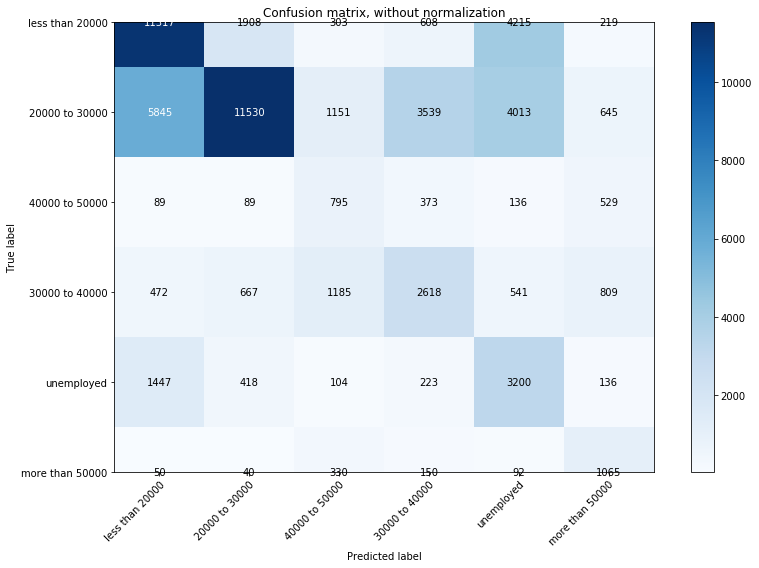

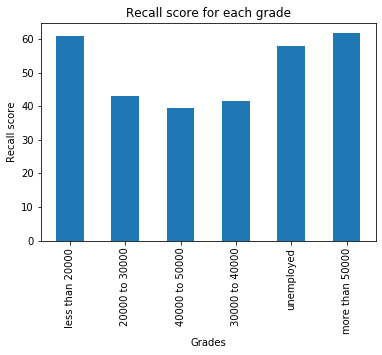

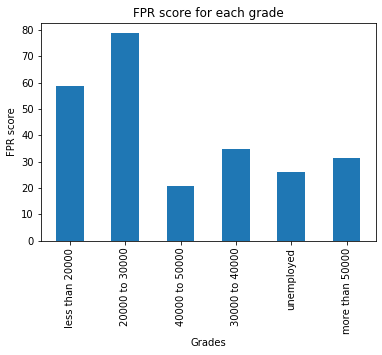

accuracy on test set is  0.5016351415753233
accuracy on training set is  0.5651619115011397
difference metrics score is  2.274615841192376


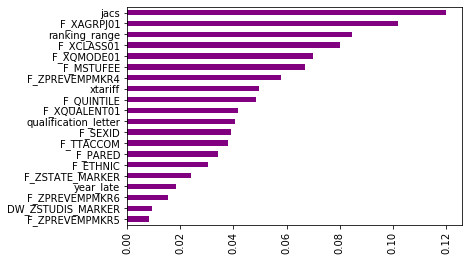

In [200]:
evaluate_model(rf, X_train, y_train, X_test, y_test, temp_encoded["salary"].unique(), treshold = 0.5, multi_class = True)

In [130]:
start_time = time.time()
param_grid = {"max_depth":[40, 30, 20, 10], 
              "min_samples_leaf":[1000, 500, 100, 50, 20]}



rf = RandomForestClassifier(random_state = SEED, 
                            class_weight = "balanced_subsample")

grid_cv_model_rf = grid_cv_model(rf, 
                                 param_grid, 
                                 X_train, 
                                 y_train, 
                                 X_test, 
                                 number_cv = 5, 
                                 print_score_best = True, 
                                 score = "f1_macro")

print("--- %s seconds ---" % (time.time() - start_time))

Best model is  {'max_depth': 40, 'min_samples_leaf': 20}
Best model score is  0.3866363310346671
--- 4255.048270225525 seconds ---


Confusion matrix, without normalization
[[2923  804  807  215  370  177  231]
 [1222 2513 1020  274  178  136   99]
 [3022 3775 4014  814  812  403  289]
 [2601 1769 2649 7051 2173  836  421]
 [1772  583 1326 1395 4857 2194 1179]
 [ 218   58   88   69  538 1363 1017]
 [ 124   56   31   18  155  561 1651]]


<Figure size 432x288 with 0 Axes>

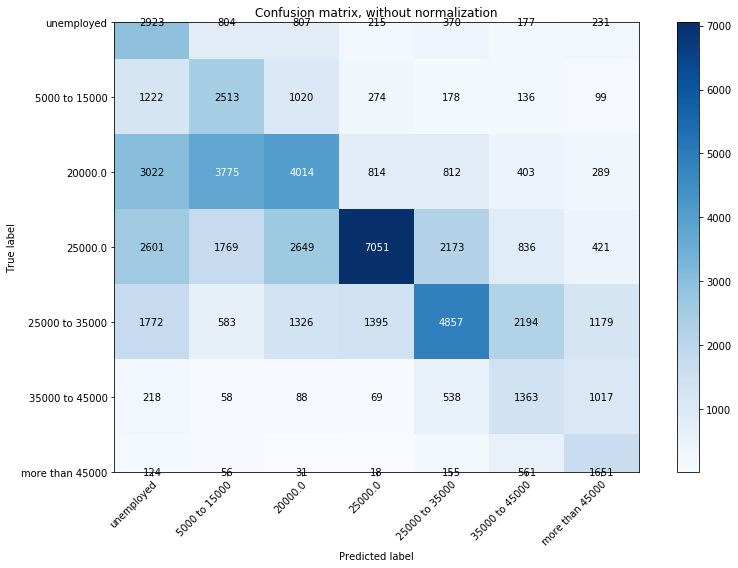

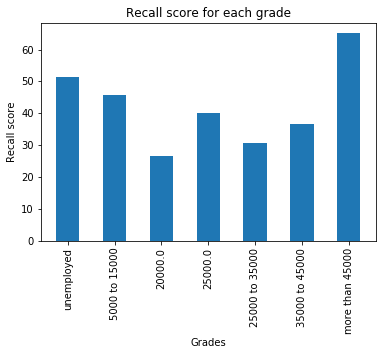

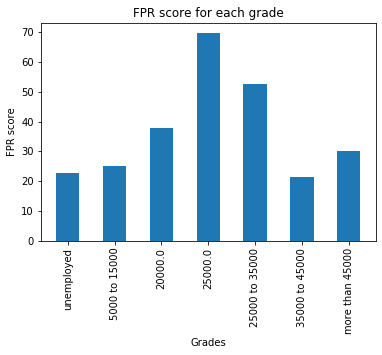

accuracy on test set is  0.4005193012440223
accuracy on training set is  0.43656653654971606
difference metrics score is  1.8554510814441185


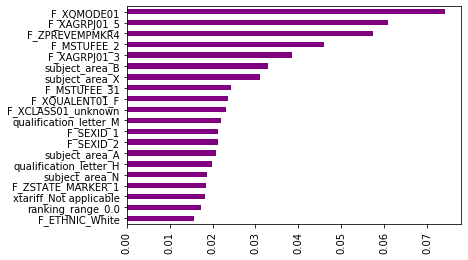

In [138]:
evaluate_model(grid_cv_model_rf, X_train, y_train, X_test, y_test, temp_encoded["salary"].unique(), treshold = 0.5, multi_class = True)

In [118]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score


scoring = {'accuracy': make_scorer(accuracy_score),
         'prec': make_scorer(precision_score, average = "macro"),
          "f1": make_scorer(f1_score, average = "macro")}

param_grid = {"max_depth":[20], 
              "min_samples_leaf":[150]}

rf = RandomForestClassifier(random_state = SEED, 
                            class_weight = "balanced_subsample", 
                            max_depth = 20, 
                            min_samples_leaf = 150)

model_cv = GridSearchCV(rf, param_grid, cv = 5, scoring = scoring, refit = "accuracy")
    
model_cv.fit(X_train, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced_subsample',
                                              criterion='gini', max_depth=20,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=150,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=...
                                              oob_score=False, random_state=42,
                                

In [121]:
results = model_cv.cv_results_


In [122]:
results

{'mean_fit_time': array([48.31473789]),
 'std_fit_time': array([5.08364079]),
 'mean_score_time': array([2.58435488]),
 'std_score_time': array([0.80610334]),
 'param_max_depth': masked_array(data=[20],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[150],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 20, 'min_samples_leaf': 150}],
 'split0_test_accuracy': array([0.37422423]),
 'split1_test_accuracy': array([0.37449974]),
 'split2_test_accuracy': array([0.36635056]),
 'split3_test_accuracy': array([0.3726346]),
 'split4_test_accuracy': array([0.37275061]),
 'mean_test_accuracy': array([0.37209195]),
 'std_test_accuracy': array([0.00296769]),
 'rank_test_accuracy': array([1], dtype=int32),
 'split0_test_prec': array([0.37016778]),
 'split1_test_prec': array([0.3705559]),
 'split2_test_prec': array([0.36487163]),
 'split3_test_prec': array([0.36728383]

# Employment model

## Model saving

In [ ]:
f = open("../../data/models/models_dict_employment.pkl","wb")
pickle.dump(model_salary_categorical, f)
f.close()

## Model importation

In [38]:
yo = pd.read_pickle(r"../../data/models/models_dict_employment.pkl")

In [46]:
yo["employment_xgboost_mean_encoding"][1]

xtariff  F_XDOMGR401  F_QUINTILE  F_XCLASS01  F_MSTUFEE  \
259550  0.077661            1    0.085174    0.065299   0.091913   
2945    0.096898            1    0.090396    0.065703   0.091913   
36931   0.134216            1    0.090396    0.065703   0.010071   
102678  0.077661            1    0.090547    0.065299   0.111652   
292483  0.095492            1    0.085630    0.100080   0.111652   
...          ...          ...         ...         ...        ...   
292573  0.084938            1    0.082480    0.100080   0.111652   
173574  0.077661            1    0.082480    0.065299   0.091913   
96218   0.156873            1    0.085174    0.297836   0.111652   
2769    0.077661            1    0.090547    0.065703   0.122790   
57251   0.096641            1    0.082480    0.100080   0.111652   

        F_ZPREVEMPMKR1  F_ZPREVEMPMKR2  F_ZPREVEMPMKR3  F_ZPREVEMPMKR4  \
259550               0               0               0               0   
2945                 0               0               0               1   
36931                0               1               0               0   
102678               0               0               0               0   
292483               0               0               0               0   
...                ...             ...             ...             ...   
292573               0               0               0               0   
173574               0               0               0               1   
96218                0               0               0               0   
2769                 0               0               0               0   
57251                0               0               0               0   

        F_ZPREVEMPMKR5  F_ZPREVEMPMKR6  F_ZPREVEMPMKR7   F_SEXID  F_XQMODE01  \
259550               1               0               0  0.114184           2   
2945                 0               0               0  0.114184           2   
36931                1               0               0  0.073265           1   
102678               0               0               0  0.073265           1   
292483               0               0               0  0.073265           1   
...                ...             ...             ...       ...         ...   
292573               0               0               0  0.073265           1   
173574               0               0               0  0.073265           2   
96218                0               0               0  0.114184           1   
2769                 0               0               0  0.114184           2   
57251                0               0               0  0.114184           1   

        F_XQUALENT01  F_XAGRPJ01  F_ZSTATE_MARKER  F_TTACCOM  \
259550      0.055816    0.075827         0.079728   0.071241   
2945        0.102022    0.071161         0.095943   0.068288   
36931       0.102022    0.099798         0.095943   0.071241   
102678      0.068317    0.099798         0.079728   0.104578   
292483      0.102022    0.099798         0.095943   0.088769   
...              ...         ...              ...        ...   
292573      0.102022    0.099798         0.093728   0.128165   
173574      0.055816    0.071161         0.079728   0.068288   
96218       0.102022    0.099798         0.095943   0.088769   
2769        0.093047    0.075827         0.079728   0.068288   
57251       0.102022    0.099798         0.095943   0.088769   

        DW_ZSTUDIS_MARKER  F_ETHNIC   F_PARED  subject_area  \
259550                  2  0.071551  0.106717      0.096197   
2945                    2  0.071551  0.086906      0.152234   
36931                   2  0.071551  0.088888      0.030302   
102678                  2  0.071551  0.106717      0.028842   
292483                  1  0.115344  0.088888      0.130383   
...                   ...       ...       ...           ...   
292573                  2  0.071551  0.086906      0.086850   
173574                  2  0.071551  0.086906      0.096197   
96218 

## Processing

In [137]:
temp = processing(df, df_prob_salary_uni)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:347: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/i

In [138]:
temp

F_XINSTID01         xtariff  F_XDOMGR401 F_QUINTILE F_XCLASS01  \
0                1  Not applicable            1          3    unknown   
1                1  Not applicable            1          3          4   
2                1  Not applicable            1          1    unknown   
3                1  Not applicable            1          1    unknown   
4                1         Unknown            1          1    unknown   
...            ...             ...          ...        ...        ...   
405664         107         240-299            1          5          2   
405665         107         240-299            1          2          1   
405666         107         320-339            1          3          1   
405667         107         360-419            1          1          2   
405668         107  Not applicable            1          3    unknown   

       F_MSTUFEE  F_ZPREVEMPMKR1  F_ZPREVEMPMKR2  F_ZPREVEMPMKR3  \
0             81               0               0               0   
1              3               0               0               0   
2             81               0               0               0   
3             81               0               0               0   
4             81               0               0               0   
...          ...             ...             ...             ...   
405664         3               0               0               0   
405665         3               0               0               0   
405666         3               0               0               0   
405667         2               0               0               0   
405668         1               0               0               0   

        F_ZPREVEMPMKR4  F_ZPREVEMPMKR5  F_ZPREVEMPMKR6  F_ZPREVEMPMKR7  \
0                    1               0               0               0   
1                    1               0               0               0   
2                    1               0               0               0   
3                    1               0               0               0   
4                    0               0               0               0   
...                ...             ...             ...             ...   
405664               0               1               0               0   
405665               0               0               0               0   
405666               0               0               0               0   
405667               0               0               0               0   
405668               0               0               0               0   

       F_SEXID  F_XQMODE01 F_XQUALENT01 F_XAGRPJ01 F_ZSTATE_MARKER F_TTACCOM  \
0            2           2            G          5               U         5   
1            2           2            D          5               U         5   
2            2           2            D          4               1         5   
3            2           2            G          4               U         5   
4            2           2            F          4               1         5   
...        ...         ...          ...        ...             ...       ...   
405664       1           1            F          4               1         8   
405665       2           1            F          3               1         9   
405666       2           1            F          4               1         2   
405667       1           1            F          3               1         8   
405668       2           1            C          4               U         5   

        DW_ZSTUDIS_MARKER F_ETHNIC F_PARED  employment  \
0                       2    White       8         0.0   
1                       2    White       9         0.0   
2                       2    White       2         0.0   
3                       2    White       8         0.0   
4                       2    White       8         0.0   
...                   ...      ...     ...         ...   
405664                  2    White       2         0.0   

## Random Forest 

### Encode and train test split

In [607]:
temp_encoded = encode(temp, "employment", method = "one hot", y_col_method = "categorical")

hello


In [77]:
X_train, X_test, y_train, y_test = train_test_split_method(temp_encoded, "employment", test_size = 0.15)


### Training without Grid Search CV

In [282]:
rf = RandomForestClassifier(random_state = SEED, 
                            class_weight = "balanced_subsample", 
                            max_depth = 40, 
                            min_samples_leaf = 20)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=40, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=20,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

Confusion matrix, without normalization
[[38993 16330]
 [ 1063  4465]]


<Figure size 432x288 with 0 Axes>

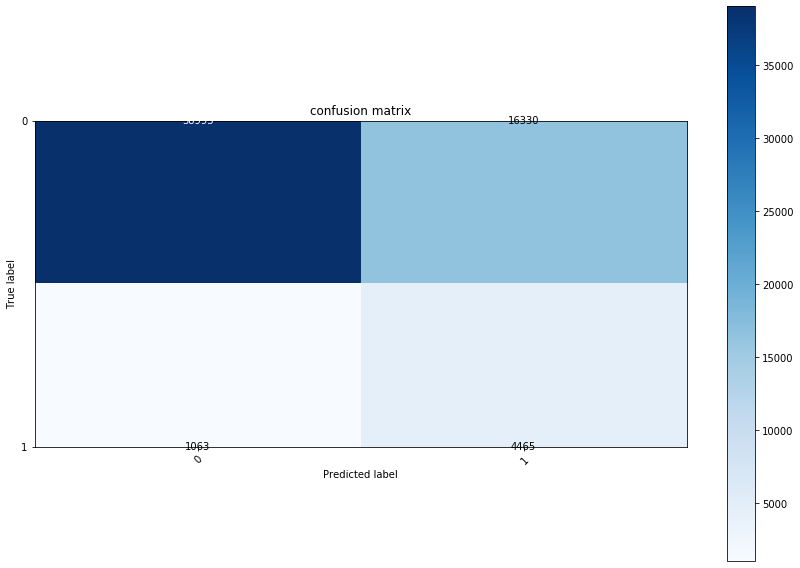

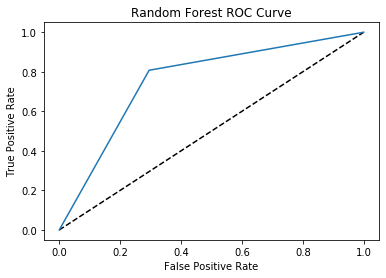

              precision    recall  f1-score   support

       False       0.70      0.97      0.82     40056
        True       0.81      0.21      0.34     20795

    accuracy                           0.71     60851
   macro avg       0.76      0.59      0.58     60851
weighted avg       0.74      0.71      0.65     60851

AUC score is 0.7562653088912678
recall on test set is  0.8077062228654125
accuracy on test set is  0.7141706792000131
recall on training set is  0.8729327629142456
accuracy on training set is  0.7252289613651259


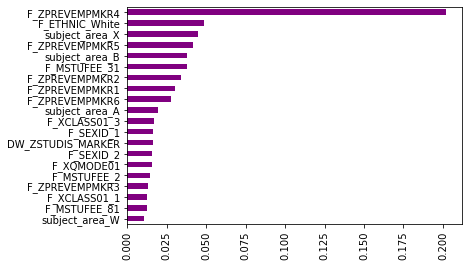

In [283]:
evaluate_model(rf, X_train, y_train, X_test, y_test, treshold = 0.5, multi_class = False)

### training with Grid Search CV

In [310]:
start_time = time.time()
param_grid = {"max_depth":[50, 40, 30, 20, 10], 
              "min_samples_leaf":[1000, 500, 100, 50, 20]}



rf = RandomForestClassifier(random_state = SEED, 
                            class_weight = "balanced_subsample")

grid_cv_model_rf = grid_cv_model(rf, 
                                 param_grid, 
                                 X_train, 
                                 y_train, 
                                 X_test, 
                                 number_cv = 5, 
                                 print_score_best = True, 
                                 score = "roc_auc")

print("--- %s seconds ---" % (time.time() - start_time))

Best model is  {'max_depth': 40, 'min_samples_leaf': 20}
Best model score is  0.8369340003623147
--- 3795.998246908188 seconds ---


Confusion matrix, without normalization
[[42876 12447]
 [ 1555  3973]]


<Figure size 432x288 with 0 Axes>

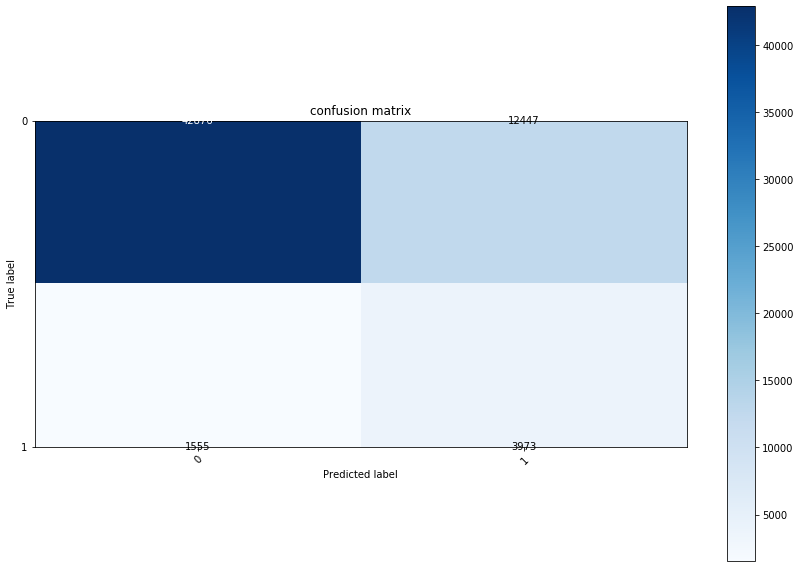

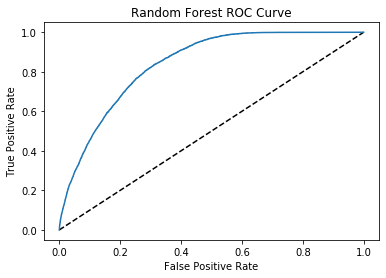

              precision    recall  f1-score   support

       False       0.78      0.97      0.86     44431
        True       0.72      0.24      0.36     16420

    accuracy                           0.77     60851
   macro avg       0.75      0.60      0.61     60851
weighted avg       0.76      0.77      0.73     60851

AUC score is 0.746858488380552
recall on test set is  0.7187047756874095
accuracy on test set is  0.7698969614303791
recall on training set is  0.8124640827533363
accuracy on training set is  0.7852838308904988


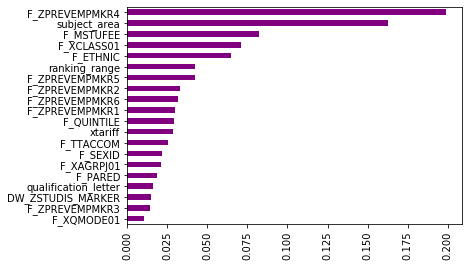

In [337]:
evaluate_model(grid_cv_model_rf, X_train, y_train, X_test, y_test, treshold = 0.55, multi_class = False)

## XGBOOST 

### Encode and train test split

In [44]:
temp_encoded = encode(temp, "employment", method = "mean", y_col_method = "categorical")

In [45]:
X_train, X_test, y_train, y_test = train_test_split_method(temp_encoded, "employment", test_size = 0.15)


### Training without grid search cv

In [333]:
#Choose all predictors except target & IDcols
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=15,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=8,
 seed=SEED)

alg = modelfit(xgb1, X_train, y_train, useTrainCV= True)


    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.783807       0.001951       0.740780      0.003033
1         0.820962       0.010099       0.786270      0.011446
2         0.833247       0.002785       0.800843      0.004424
3         0.838043       0.001778       0.807602      0.002046
4         0.840006       0.001409       0.810625      0.003325
5         0.840566       0.002032       0.810543      0.003748
6         0.842324       0.002196       0.812866      0.002450
7         0.843253       0.001775       0.813636      0.001964
8         0.844161       0.002132       0.814876      0.001892
9         0.845801       0.001078       0.815665      0.001815
10        0.846947       0.001033       0.816541      0.001539
11        0.848082       0.001060       0.817118      0.001415
12        0.848604       0.000651       0.817776      0.001441
13        0.849342       0.000416       0.818175      0.001363
14        0.850177       0.000517       0.818472      0


Model Report
AUC Score (Test): 0.840286
[[47284  8039]
 [ 2387  3141]]


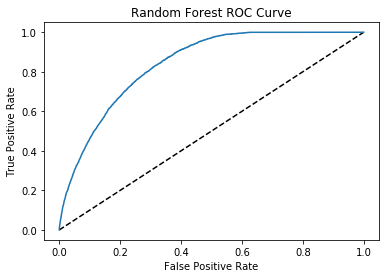

              precision    recall  f1-score   support

       False       0.85      0.95      0.90     49671
        True       0.57      0.28      0.38     11180

    accuracy                           0.83     60851
   macro avg       0.71      0.62      0.64     60851
weighted avg       0.80      0.83      0.80     60851



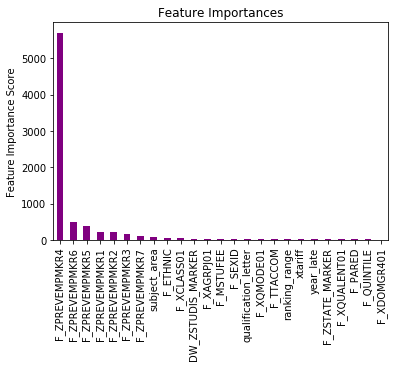

In [57]:
evaluate_xgboost_model(yo["employment_xgboost_mean_encoding"][0], 
                       yo["employment_xgboost_mean_encoding"][1], 
                       y_test , 
                       0.6)



Model Report
AUC Score (Test): 0.827306
[[40154 15169]
 [ 1346  4182]]


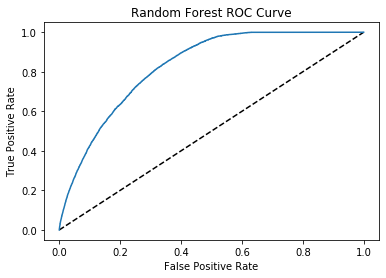

              precision    recall  f1-score   support

       False       0.73      0.97      0.83     41500
        True       0.76      0.22      0.34     19351

    accuracy                           0.73     60851
   macro avg       0.74      0.59      0.58     60851
weighted avg       0.74      0.73      0.67     60851



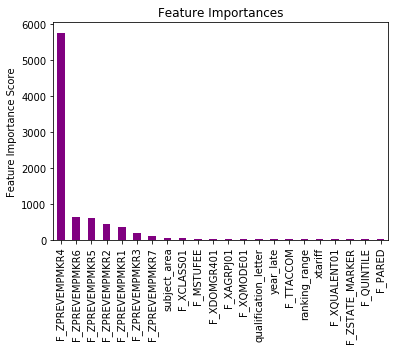

In [361]:
evaluate_xgboost_model(alg, 
                       X_test, 
                       y_test , 
                       0.5)


Model Report
AUC Score (Test): 0.840286
[[41805 13518]
 [ 1409  4119]]


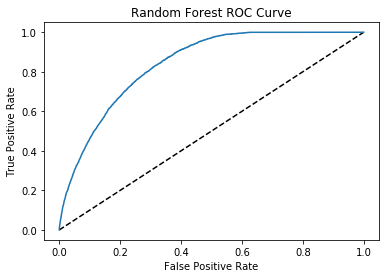

              precision    recall  f1-score   support

       False       0.76      0.97      0.85     43214
        True       0.75      0.23      0.36     17637

    accuracy                           0.75     60851
   macro avg       0.75      0.60      0.60     60851
weighted avg       0.75      0.75      0.71     60851



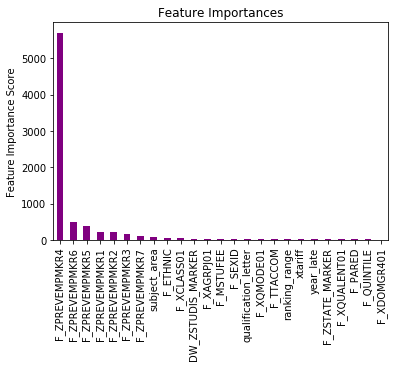

In [163]:
evaluate_xgboost_model(yo["employment_xgboost_mean_encoding"][0], 
                       yo["employment_xgboost_mean_encoding"][1], 
                       y_test, 
                       0.5)


In [349]:
y_pred = alg.predict(X_test)


In [362]:
miss_working = temp.loc[X_test.index, :][((y_pred == 1) & (y_test == 0))]

In [364]:
miss_unemp = temp.loc[X_test.index, :][((y_pred == 0) & (y_test == 1))]

In [366]:
unemp = temp.loc[X_test.index, :][((y_pred == 1) & (y_test == 1))]

In [367]:
working = temp.loc[X_test.index, :][((y_pred == 0) & (y_test == 0))]

In [198]:
miss_working.to_csv("miss_working.csv", index = False)
miss_unemp.to_csv("miss_unemp.csv", index = False)
unemp.to_csv("unemp.csv", index = False)

In [199]:
pd.read_csv("unemp.csv")

xtariff  F_XDOMGR401 F_QUINTILE F_XCLASS01  F_MSTUFEE  \
0            240-299            1          2          1          1   
1     Not applicable            1          2    unknown          1   
2            320-339            1          3          4          2   
3            340-359            1          2          2          2   
4            360-419            1          5          3          2   
...              ...          ...        ...        ...        ...   
4114         300-319            1          2          3          2   
4115         240-299            1          2          4          2   
4116         120-179            1          3          A          2   
4117  Not applicable            1          1          1         52   
4118         300-319            1          5          2          2   

      F_ZPREVEMPMKR1  F_ZPREVEMPMKR2  F_ZPREVEMPMKR3  F_ZPREVEMPMKR4  \
0                  0               0               0               0   
1                  0               0               0               0   
2                  0               0               0               0   
3                  0               0               0               0   
4                  0               0               0               0   
...              ...             ...             ...             ...   
4114               0               0               0               0   
4115               0               0               0               0   
4116               0               0               0               0   
4117               0               0               0               0   
4118               0               0               0               0   

      F_ZPREVEMPMKR5  F_ZPREVEMPMKR6  F_ZPREVEMPMKR7  F_SEXID  F_XQMODE01  \
0                  0               0               0        1           1   
1                  0               0               0        2           2   
2                  0               0               0        2           2   
3                  0               0               0        2           1   
4                  0               0               0        1           1   
...              ...             ...             ...      ...         ...   
4114               0               0               0        1           1   
4115               0               0               0        2           1   
4116               0               0               0        1           1   
4117               0               0               0        1           2   
4118               0               0               0        1           1   

     F_XQUALENT01  F_XAGRPJ01 F_ZSTATE_MARKER  F_TTACCOM  DW_ZSTUDIS_MARKER  \
0               F           3               1          8                  2   
1               C           5               U          7                  2   
2               F           3               1          2                  2   
3               F           3               1          8                  2   
4               F           3               0          1                  1   
...           ...         ...             ...        ...                ...   
4114            F           3               1          9                  2   
4115            F           3               1          2                  2   
4116            F           3               1          8                  2   
4117            D           4               U          5                  2   
4118            F           3               1          8                  2   

     F_ETHNIC  F_PARED  employment subject_area qualification_letter  \
0       White        1         1.0            W                    H   
1       Black        2         1.0            C                    M   
2       Asian        2         1.0            W                    H   
3       White        2         1.0            W                    H   
4       White        1         1.0            L                    H   
.

## Save models

In [88]:
f = open("../../data/models/models_dict_employment.pkl","wb")
pickle.dump(yo,f)
f.close()


# Model continuous salary variable 

## Model importation

In [ ]:
yo = pd.read_pickle(r"../../data/models/models_dict_employment.pkl")

## Processing

In [139]:
temp = processing(df, df_prob_salary_uni, prediction = "salary", type_y = "continuous", classes = "only salary")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:247: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:347: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

In [140]:
temp

F_XINSTID01         xtariff  F_XDOMGR401 F_QUINTILE   salary  \
0                1  Not applicable            1          3  20000.0   
1                1  Not applicable            1          3  30000.0   
2                1  Not applicable            1          1  20000.0   
3                1  Not applicable            1          1  25000.0   
4                1         Unknown            1          1  15000.0   
...            ...             ...          ...        ...      ...   
369103         107         480-539            1          5  20000.0   
369104         107         240-299            1          5  15000.0   
369105         107         240-299            1          2  15000.0   
369106         107         320-339            1          3  15000.0   
369107         107         360-419            1          1  20000.0   

       F_XCLASS01 F_MSTUFEE  F_ZPREVEMPMKR1  F_ZPREVEMPMKR2  F_ZPREVEMPMKR3  \
0         unknown        81               0               0               0   
1               4         3               0               0               0   
2         unknown        81               0               0               0   
3         unknown        81               0               0               0   
4         unknown        81               0               0               0   
...           ...       ...             ...             ...             ...   
369103          2         3               0               0               0   
369104          2         3               0               0               0   
369105          1         3               0               0               0   
369106          1         3               0               0               0   
369107          2         2               0               0               0   

        F_ZPREVEMPMKR4  F_ZPREVEMPMKR5  F_ZPREVEMPMKR6  F_ZPREVEMPMKR7  \
0                    1               0               0               0   
1                    1               0               0               0   
2                    1               0               0               0   
3                    1               0               0               0   
4                    0               0               0               0   
...                ...             ...             ...             ...   
369103               0               0               0               0   
369104               0               1               0               0   
369105               0               0               0               0   
369106               0               0               0               0   
369107               0               0               0               0   

       F_SEXID  F_XQMODE01 F_XQUALENT01 F_XAGRPJ01 F_ZSTATE_MARKER F_TTACCOM  \
0            2           2            G          5               U         5   
1            2           2            D          5               U         5   
2            2           2            D          4               1         5   
3            2           2            G          4               U         5   
4            2           2            F          4               1         5   
...        ...         ...          ...        ...             ...       ...   
369103       1           1            F          3               1         9   
369104       1           1            F          4               1         8   
369105       2           1            F          3               1         9   
369106       2           1            F          4               1         2   
369107       1           1            F          3               1         8   

        DW_ZSTUDIS_MARKER F_ETHNIC F_PARED                         jacs  \
0                       2    White       8  Subjects allied to medicine   
1                       2    White       9  Subjects allied to medicine   
2                       2    White       2  Subjects allied to medicine   
3                       2    White       8  Subjects al

## Random Forest

### Encode and train test split

In [479]:
temp_encoded = encode(temp, "salary", method = "mean", y_col_method = "categorical")

In [480]:
X_train, X_test, y_train, y_test = train_test_split_method(temp_encoded, "salary", test_size = 0.15)


### Training

In [485]:
rf = RandomForestRegressor(random_state = SEED, 
                            max_depth = 40, 
                            min_samples_leaf = 50)

rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=40, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=50,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [486]:
y_pred = rf.predict(X_test)

In [273]:
y_pred_train = rf.predict(X_train)

In [281]:
print(r2_score(y_train, y_pred_train))

0.552928169685784


In [682]:
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

4769.999292632714
0.48632761333602226


In [283]:
for i in range(y_test.size):
    
    print(y_test.iloc[i], " vs  ", y_pred[i])

20000.0  vs   22722.464757782946
30000.0  vs   26166.422503084992
25000.0  vs   31072.357382628452
75000.0  vs   48673.7057906218
30000.0  vs   32369.88275953412
30000.0  vs   22428.791197235612
30000.0  vs   19691.72260632854
25000.0  vs   27054.255446045994
20000.0  vs   22364.70640012871
25000.0  vs   25884.133503726378
25000.0  vs   26633.553927902347
25000.0  vs   27955.90334544434
50000.0  vs   41427.70694701951
25000.0  vs   25200.837593936496
20000.0  vs   19889.088208738438
25000.0  vs   25100.352924762807
20000.0  vs   23882.240075109046
20000.0  vs   22847.903844409135
30000.0  vs   27447.72685626646
25000.0  vs   24711.53880342997
50000.0  vs   42637.89201814201
30000.0  vs   24789.35410223269
25000.0  vs   22405.057899625775
40000.0  vs   27386.91640050024
15000.0  vs   19443.722244325647
35000.0  vs   32819.46404831337
45000.0  vs   32273.109935957124
25000.0  vs   28196.07301842112
35000.0  vs   27755.94005591785
25000.0  vs   23703.228213809707
25000.0  vs   27116.37315

25000.0  vs   25660.15159074511
25000.0  vs   27659.85929771415
20000.0  vs   21566.353584328423
20000.0  vs   17899.045206977273
25000.0  vs   26838.01594631023
25000.0  vs   22686.99154622691
30000.0  vs   31484.377025680347
25000.0  vs   22783.066948571053
25000.0  vs   24681.51218045467
25000.0  vs   24171.981505104413
75000.0  vs   40958.46410208543
30000.0  vs   22717.013525581955
30000.0  vs   21654.707711250507
30000.0  vs   28270.186282596118
50000.0  vs   47459.78634495056
75000.0  vs   32355.629704805608
20000.0  vs   22128.507223385433
20000.0  vs   22911.9517890588
15000.0  vs   25788.228274170113
20000.0  vs   23704.635521673303
35000.0  vs   22521.28596188114
25000.0  vs   30930.300647416338
55000.0  vs   40839.287440107866
35000.0  vs   32549.429915507073
20000.0  vs   18678.450735417704
25000.0  vs   19574.664387779267
25000.0  vs   25758.488887947486
45000.0  vs   37293.908704162335
35000.0  vs   27705.112316976756
30000.0  vs   23187.15828604298
25000.0  vs   25211.6

15000.0  vs   23169.435396422785
35000.0  vs   36868.34349994598
25000.0  vs   25566.578337242692
20000.0  vs   18858.73727739226
20000.0  vs   34942.01810947265
30000.0  vs   28273.523323088597
35000.0  vs   37808.219050154796
25000.0  vs   25194.868921705704
30000.0  vs   25400.572787525078
30000.0  vs   30093.16308591865
40000.0  vs   22359.275614073482
25000.0  vs   23164.512770322483
35000.0  vs   45029.86038201532
25000.0  vs   27406.46416497468
15000.0  vs   22199.59452570778
25000.0  vs   21807.616008150606
20000.0  vs   24469.44290751293
20000.0  vs   24243.97492740045
25000.0  vs   27866.337757865687
25000.0  vs   25256.677203636256
25000.0  vs   26943.191375628943
40000.0  vs   32351.919223755893
25000.0  vs   23465.086494718133
20000.0  vs   20018.784752023053
25000.0  vs   22038.006349441755
75000.0  vs   33615.10245745663
35000.0  vs   28137.110631963882
15000.0  vs   24231.810196134607
30000.0  vs   30351.826331464956
30000.0  vs   27069.105162097287
20000.0  vs   38097.

15000.0  vs   20191.13388931794
25000.0  vs   21972.10293398769
25000.0  vs   28618.50579575767
20000.0  vs   21480.653774065802
20000.0  vs   26008.91766498951
20000.0  vs   22046.95355721543
30000.0  vs   27329.0500851494
25000.0  vs   42695.952710901554
20000.0  vs   22797.89971219311
25000.0  vs   37640.26374120687
25000.0  vs   24701.27026828316
35000.0  vs   22865.815029045083
25000.0  vs   22614.3097973021
35000.0  vs   34439.61812485539
20000.0  vs   20861.6715942951
15000.0  vs   21905.075074140266
35000.0  vs   38652.8704079868
25000.0  vs   22355.20026064465
30000.0  vs   26933.030183535164
45000.0  vs   49356.41015307192
25000.0  vs   30471.68495984266
20000.0  vs   22112.437089424413
25000.0  vs   26164.97603438301
15000.0  vs   20369.848558025806
20000.0  vs   23048.89543158569
20000.0  vs   19044.29025685518
30000.0  vs   24881.7288023171
25000.0  vs   25562.889685880342
25000.0  vs   28049.02208378153
20000.0  vs   26319.351238022944
30000.0  vs   31119.14856584733
2500

25000.0  vs   25108.92684123451
25000.0  vs   25713.096590003603
25000.0  vs   29226.355163020584
25000.0  vs   25307.87918105169
40000.0  vs   41028.06844523053
30000.0  vs   22144.862936195805
25000.0  vs   25116.467059925933
15000.0  vs   21327.28645601115
25000.0  vs   43288.00410132939
25000.0  vs   25882.809692977346
20000.0  vs   32696.558230968047
25000.0  vs   25684.19034056607
30000.0  vs   35229.78855076051
20000.0  vs   21526.04034645456
20000.0  vs   20631.066713031712
45000.0  vs   33644.68151359264
30000.0  vs   26087.18972569258
20000.0  vs   26399.79025758135
25000.0  vs   29533.06429481682
25000.0  vs   24947.96287095535
30000.0  vs   33115.8225607217
45000.0  vs   30305.305331958047
30000.0  vs   22814.103723481727
30000.0  vs   26991.99204485767
25000.0  vs   20496.776573031006
40000.0  vs   38309.227507564385
25000.0  vs   25721.443696101593
15000.0  vs   19213.653330556288
10000.0  vs   22023.524408149748
25000.0  vs   24542.46000120001
25000.0  vs   22561.6780318

15000.0  vs   22006.280276466987
15000.0  vs   20980.77994805618
15000.0  vs   21600.67599842785
20000.0  vs   27918.56428979665
15000.0  vs   21042.57919793581
30000.0  vs   33497.70843646051
25000.0  vs   23603.083357759075
50000.0  vs   32101.257975266613
50000.0  vs   48987.70001831474
35000.0  vs   37282.379792207576
15000.0  vs   22859.593645300687
20000.0  vs   21346.547523541547
30000.0  vs   30939.439162897525
25000.0  vs   25404.3181356077
70000.0  vs   31798.26040324832
25000.0  vs   23373.04706767529
25000.0  vs   24912.533611007395
25000.0  vs   21414.85799792939
25000.0  vs   23942.927809867993
25000.0  vs   25139.419039695258
35000.0  vs   32732.43814440537
25000.0  vs   19375.400128190726
25000.0  vs   24365.616466489468
30000.0  vs   45379.546187921485
25000.0  vs   24964.121978685995
20000.0  vs   22323.764438444694
15000.0  vs   19788.6884233781
30000.0  vs   28513.643863191697
20000.0  vs   21337.774316431376
30000.0  vs   37409.66540733017
30000.0  vs   39400.60052

25000.0  vs   30315.17057777884
30000.0  vs   25029.055100748454
20000.0  vs   20548.27198606335
20000.0  vs   21719.354230367808
25000.0  vs   19060.99810161099
25000.0  vs   45485.638971361965
20000.0  vs   21498.03305071048
30000.0  vs   23460.266432046155
35000.0  vs   28823.278731843595
30000.0  vs   31738.12131108314
25000.0  vs   25375.838743132925
15000.0  vs   20258.807246970788
25000.0  vs   25557.029725553268
35000.0  vs   28124.80886433954
30000.0  vs   45046.09360202602
30000.0  vs   30200.347183591275
20000.0  vs   25952.12615375768
25000.0  vs   26088.02877524488
15000.0  vs   35796.65814111434
15000.0  vs   21931.167428242323
15000.0  vs   20165.5228691181
35000.0  vs   25617.406982338656
30000.0  vs   27528.328931705673
25000.0  vs   20986.531932359907
25000.0  vs   22917.962477165285
30000.0  vs   20199.78129716983
25000.0  vs   21023.96515145082
15000.0  vs   20184.212626697565
20000.0  vs   22712.36184398633
25000.0  vs   22189.46495585592
25000.0  vs   25018.408520

20000.0  vs   19273.586901376202
20000.0  vs   30457.456115529752
20000.0  vs   22237.66760261867
20000.0  vs   18498.714910572315
25000.0  vs   18740.846032475456
40000.0  vs   34659.2176244466
25000.0  vs   23522.20635216
20000.0  vs   23289.2383372461
35000.0  vs   24693.721833803647
25000.0  vs   25150.314960928168
30000.0  vs   29444.497797507975
15000.0  vs   21297.918239572053
25000.0  vs   23936.061975275315
25000.0  vs   23671.09946582619
30000.0  vs   24245.109053588112
20000.0  vs   20431.95755581262
15000.0  vs   22803.599804207803
25000.0  vs   24609.140404689224
20000.0  vs   20904.185066742204
25000.0  vs   24124.60464191497
35000.0  vs   32881.70058434489
20000.0  vs   20204.02794920596
20000.0  vs   29736.529348623124
30000.0  vs   22338.9425767591
25000.0  vs   25314.494213281967
25000.0  vs   24140.587604739503
20000.0  vs   20461.983095894724
20000.0  vs   22940.39947349829
20000.0  vs   21075.059319494918
15000.0  vs   25764.897184544607
30000.0  vs   31231.2758584

25000.0  vs   26593.95275899226
25000.0  vs   23482.78892472155
75000.0  vs   46134.82310063567
15000.0  vs   22268.14877685933
20000.0  vs   24346.4201831626
15000.0  vs   21610.399854099007
30000.0  vs   25330.8583129195
35000.0  vs   30985.084888953254
30000.0  vs   27925.677250993336
25000.0  vs   26086.48625137278
50000.0  vs   39278.24959150905
25000.0  vs   24866.43445854391
25000.0  vs   23618.861291608187
30000.0  vs   28354.85891945155
20000.0  vs   21722.86200697091
40000.0  vs   29390.877064221717
20000.0  vs   19145.61527217727
25000.0  vs   30094.334134570705
20000.0  vs   21103.90455047189
20000.0  vs   22257.9371138563
30000.0  vs   25589.83845378751
25000.0  vs   25219.245774910352
20000.0  vs   19855.170628973763
25000.0  vs   21628.681076308614
25000.0  vs   25016.74343643954
25000.0  vs   22160.22947567623
40000.0  vs   37710.20541146678
75000.0  vs   35395.12701417355
20000.0  vs   25070.227284094075
15000.0  vs   21349.468995230687
20000.0  vs   19510.83562008168


20000.0  vs   21585.621191731127
25000.0  vs   29965.783312813764
25000.0  vs   28361.011004016702
30000.0  vs   25238.080619872315
25000.0  vs   25083.545325214654
15000.0  vs   22713.824493221113
30000.0  vs   23588.572003304747
25000.0  vs   21149.337263426125
20000.0  vs   23932.33656412983
20000.0  vs   22836.359000898196
25000.0  vs   24750.763761735954
20000.0  vs   20330.604698985953
20000.0  vs   24360.78958434079
25000.0  vs   21314.801307428457
20000.0  vs   19468.373946165975
35000.0  vs   25194.166686854587
30000.0  vs   36868.45055264826
20000.0  vs   24752.15507202635
10000.0  vs   23092.069223422626
40000.0  vs   52138.921453864605
50000.0  vs   47940.07233953453
35000.0  vs   41703.92672473335
15000.0  vs   21163.567208621505
20000.0  vs   22644.575659637034
30000.0  vs   28418.184679965856
20000.0  vs   27043.573181790336
20000.0  vs   20362.609943804444
10000.0  vs   20687.44888052908
30000.0  vs   31293.432420652094
35000.0  vs   47337.33051469374
15000.0  vs   2249

25000.0  vs   21143.31752123689
45000.0  vs   45164.766055277556
25000.0  vs   25566.735464562982
20000.0  vs   24425.284487511766
40000.0  vs   32744.832326060903
25000.0  vs   26791.92690756396
25000.0  vs   25035.439609673052
25000.0  vs   24238.740318892622
20000.0  vs   21935.70883211448
25000.0  vs   22661.599096961858
25000.0  vs   23005.171382995653
30000.0  vs   36907.30700042088
20000.0  vs   23315.70242982965
20000.0  vs   26290.02208456706
20000.0  vs   19603.931525743687
40000.0  vs   34337.93138955091
20000.0  vs   26815.183339711126
20000.0  vs   22929.850875100925
25000.0  vs   25311.12299192978
15000.0  vs   20351.430351118062
25000.0  vs   27504.349308841916
30000.0  vs   30055.962997705858
25000.0  vs   21596.888080990004
20000.0  vs   22924.409900895287
15000.0  vs   22298.466437079373
25000.0  vs   25156.187862893967
35000.0  vs   31394.411102082093
25000.0  vs   22158.834840862757
40000.0  vs   25556.3085572932
20000.0  vs   24400.883614555347
15000.0  vs   21246.

25000.0  vs   24419.262489063538
25000.0  vs   25045.628094640233
25000.0  vs   27639.603315706514
45000.0  vs   50451.926220933936
40000.0  vs   24176.004526872126
25000.0  vs   25790.651942956298
30000.0  vs   21720.37617857507
15000.0  vs   22763.819338684287
30000.0  vs   33786.72027602857
25000.0  vs   19760.29195868937
20000.0  vs   19441.84954030972
15000.0  vs   19448.46102181294
20000.0  vs   23168.52463610385
20000.0  vs   25732.99540727607
20000.0  vs   33196.42613562188
25000.0  vs   30021.388927461874
15000.0  vs   23549.906152478907
30000.0  vs   27217.154785835977
30000.0  vs   24730.518658250643
35000.0  vs   24684.01603442178
20000.0  vs   21947.114407726258
15000.0  vs   22241.330003249554
15000.0  vs   21769.48787565303
25000.0  vs   22708.361358607406
20000.0  vs   21865.38991342427
25000.0  vs   25121.932147894724
25000.0  vs   25165.81387077403
30000.0  vs   28766.225881301078
15000.0  vs   20389.343706928983
20000.0  vs   26253.022862103524
30000.0  vs   24823.96

15000.0  vs   21718.85745513634
25000.0  vs   27634.673961645647
15000.0  vs   31777.29169970362
30000.0  vs   25855.077094536893
25000.0  vs   29756.335778481924
20000.0  vs   21188.366991577914
20000.0  vs   19739.365753512822
15000.0  vs   21073.79130530767
45000.0  vs   22584.824237232428
45000.0  vs   48130.472120802326
40000.0  vs   31085.17213069041
15000.0  vs   21895.54185964104
25000.0  vs   24289.89844027852
15000.0  vs   21160.788013148842
15000.0  vs   27736.149590489935
35000.0  vs   29842.58490778371
30000.0  vs   22907.75042458948
40000.0  vs   21622.06026183415
20000.0  vs   28499.053044018583
20000.0  vs   21792.93310190174
25000.0  vs   28296.87760742536
30000.0  vs   29040.119607146433
30000.0  vs   30687.63009597482
15000.0  vs   21782.412037602648
75000.0  vs   54907.62797765728
20000.0  vs   18757.673691317592
25000.0  vs   38595.488284455336
25000.0  vs   22962.366929052136
25000.0  vs   25607.241878351582
20000.0  vs   23703.77353279992
30000.0  vs   32740.5187

20000.0  vs   19722.93530960653
30000.0  vs   25786.407932855887
20000.0  vs   20419.22337519732
15000.0  vs   22050.466151930854
25000.0  vs   28927.28982731672
25000.0  vs   21720.25115127818
25000.0  vs   21236.796086716236
20000.0  vs   29143.057234416836
30000.0  vs   32269.533952366513
40000.0  vs   30017.452995049927
25000.0  vs   23049.407768064557
20000.0  vs   21706.115250981067
40000.0  vs   33760.27579239441
30000.0  vs   28322.533829983444
40000.0  vs   54318.47687407321
25000.0  vs   22680.85018718977
30000.0  vs   31611.001767583504
20000.0  vs   19768.03445720763
35000.0  vs   26822.967367856596
60000.0  vs   39551.199220409726
20000.0  vs   22880.63063410872
30000.0  vs   25626.038806614277
30000.0  vs   29921.089647073597
30000.0  vs   37706.97079703839
15000.0  vs   22432.165958427446
25000.0  vs   22216.60665183142
25000.0  vs   25289.845585524992
15000.0  vs   21761.798315849082
30000.0  vs   32768.637102604625
25000.0  vs   29455.15505167996
35000.0  vs   50777.55

20000.0  vs   28985.219405970904
25000.0  vs   21617.159732231692
60000.0  vs   43830.362680982806
15000.0  vs   21321.92992064393
15000.0  vs   20067.15411125692
25000.0  vs   25025.605112645622
20000.0  vs   22830.088924936208
25000.0  vs   23738.46606661208
20000.0  vs   25275.881864211595
55000.0  vs   47638.35196545637
25000.0  vs   25099.51699519964
30000.0  vs   46116.3862075827
30000.0  vs   28551.731352677038
25000.0  vs   21189.5194517233
35000.0  vs   30807.604834787762
25000.0  vs   29411.582598224762
25000.0  vs   19828.928490791433
25000.0  vs   25729.722217257266
70000.0  vs   44086.324441578436
25000.0  vs   25082.326499048548
30000.0  vs   28056.4798097739
25000.0  vs   23234.584089086726
20000.0  vs   24564.236837943667
20000.0  vs   19658.99472275723
15000.0  vs   21991.763883816988
25000.0  vs   22655.38860495995
20000.0  vs   25820.710266995182
20000.0  vs   23316.154674753452
25000.0  vs   21530.22981737088
25000.0  vs   27116.118617633725
30000.0  vs   27755.3557

25000.0  vs   24184.58046561615
30000.0  vs   27917.84611763742
15000.0  vs   22246.55159598226
15000.0  vs   18636.900838877278
15000.0  vs   18441.507226307043
25000.0  vs   23698.20646674824
25000.0  vs   19463.752516258948
40000.0  vs   35742.95874013949
60000.0  vs   43949.58520871487
15000.0  vs   25873.12401986152
25000.0  vs   29954.09038588204
35000.0  vs   32658.555745703583
25000.0  vs   22058.752144669255
45000.0  vs   46386.816890496455
30000.0  vs   25728.361528483016
15000.0  vs   21322.963263863832
30000.0  vs   31355.02646155447
25000.0  vs   21834.449526242366
20000.0  vs   23929.76278524742
30000.0  vs   27561.49136612969
25000.0  vs   20038.574291041816
25000.0  vs   25327.329650324486
30000.0  vs   30125.669006760367
20000.0  vs   19345.565290658455
25000.0  vs   25078.637240643973
35000.0  vs   31643.229267755276
30000.0  vs   29538.239059985877
35000.0  vs   35574.27146521223
20000.0  vs   24469.23723809283
25000.0  vs   28249.621436730155
20000.0  vs   20214.823

20000.0  vs   22374.52117105765
15000.0  vs   20446.46455123852
20000.0  vs   24967.270083092197
15000.0  vs   25702.543811265496
15000.0  vs   19451.90983916846
20000.0  vs   18691.578094682984
25000.0  vs   25040.98933254379
40000.0  vs   44857.77415058686
25000.0  vs   29370.58264099245
15000.0  vs   21324.18863819839
20000.0  vs   26304.012438865368
20000.0  vs   23812.45286158611
20000.0  vs   23594.962122211564
25000.0  vs   23004.57513239123
25000.0  vs   31834.625478479724
20000.0  vs   26990.053367045988
20000.0  vs   22087.04471135447
15000.0  vs   23105.85221523841
35000.0  vs   30019.123938210276
25000.0  vs   27241.02609072722
30000.0  vs   21956.314408074883
25000.0  vs   19780.056575161685
25000.0  vs   31036.899336898914
25000.0  vs   29985.21740615991
15000.0  vs   21011.25684506732
20000.0  vs   26010.406664821818
20000.0  vs   38653.90841343663
70000.0  vs   59270.947877561375
35000.0  vs   29002.711242777757
20000.0  vs   20947.38740037072
25000.0  vs   28237.979555

15000.0  vs   19653.716494136977
25000.0  vs   27744.15684382569
20000.0  vs   24329.23355840701
35000.0  vs   26266.675754735897
25000.0  vs   22902.49562130793
35000.0  vs   20178.43865884426
20000.0  vs   28807.169765134993
20000.0  vs   23535.332961205175
25000.0  vs   25306.22506777886
25000.0  vs   20873.39751963156
60000.0  vs   61651.17820939024
30000.0  vs   26986.998912101306
25000.0  vs   29796.581448253914
25000.0  vs   24695.517002353947
20000.0  vs   20129.905419222287
25000.0  vs   22367.96249258946
40000.0  vs   29205.413691925754
30000.0  vs   31601.107533702707
35000.0  vs   30940.77024348953
25000.0  vs   25036.21512538461
25000.0  vs   23520.510152182174
60000.0  vs   41151.66394586208
20000.0  vs   25075.364244875687
25000.0  vs   25772.37165161545
20000.0  vs   22687.705248486145
25000.0  vs   26388.586095640607
40000.0  vs   33351.108069719514
20000.0  vs   22440.36232699093
25000.0  vs   28184.33551338791
35000.0  vs   38639.90383116103
40000.0  vs   39146.21710

20000.0  vs   19944.071783492604
25000.0  vs   22106.002608393235
30000.0  vs   22908.181884053414
35000.0  vs   23668.64204657274
20000.0  vs   20941.639359022152
40000.0  vs   32397.482681697104
20000.0  vs   30587.687444274514
15000.0  vs   19819.791395054428
20000.0  vs   20452.275279707927
45000.0  vs   46292.692384866525
30000.0  vs   22632.162413588223
20000.0  vs   20030.19232008834
25000.0  vs   23680.060061996435
30000.0  vs   26310.796668088697
30000.0  vs   28807.938779619988
25000.0  vs   27441.85297216862
15000.0  vs   21387.730792574235
30000.0  vs   25380.142286086386
25000.0  vs   25362.673574580822
55000.0  vs   35542.76007185059
30000.0  vs   33637.78668191067
25000.0  vs   23065.834268709274
35000.0  vs   51786.634843895874
35000.0  vs   29459.628766253307
30000.0  vs   33705.40596277443
25000.0  vs   24180.3195651038
20000.0  vs   20696.679860868477
30000.0  vs   27960.689836020596
15000.0  vs   18520.320123330705
20000.0  vs   21459.63132471097
15000.0  vs   24609

35000.0  vs   32108.410056617133
40000.0  vs   38526.959715247845
20000.0  vs   18483.0657902248
25000.0  vs   21616.37417505162
45000.0  vs   30895.282637152934
35000.0  vs   32514.36743630078
25000.0  vs   24398.230239522272
35000.0  vs   44250.3816302586
25000.0  vs   35474.117776312756
20000.0  vs   23521.823582655798
10000.0  vs   22732.18555308144
40000.0  vs   32742.991725952466
20000.0  vs   21715.70392257099
75000.0  vs   43813.39702037493
30000.0  vs   29766.17932511254
30000.0  vs   21997.09097472906
75000.0  vs   49791.38140731685
30000.0  vs   24031.78767662439
20000.0  vs   18741.8288379335
30000.0  vs   31876.995904504078
25000.0  vs   28267.484531215294
20000.0  vs   20096.189508572745
25000.0  vs   21714.829142892664
25000.0  vs   27304.697887482187
20000.0  vs   22378.18498120366
30000.0  vs   35683.919744174695
20000.0  vs   22901.15504919032
35000.0  vs   28370.959417148366
25000.0  vs   20157.40078245893
15000.0  vs   22102.271391771086
25000.0  vs   23815.58580467

25000.0  vs   23691.51794299206
20000.0  vs   18133.22846985214
25000.0  vs   27070.561304577488
25000.0  vs   21819.62989231189
25000.0  vs   25061.384580411963
20000.0  vs   21068.525360202748
35000.0  vs   41238.639283651784
20000.0  vs   20590.217657628335
30000.0  vs   27962.789228350983
20000.0  vs   26061.96347182621
20000.0  vs   25260.84951996371
25000.0  vs   19967.700626747148
35000.0  vs   31289.037815818727
30000.0  vs   36815.79581185436
35000.0  vs   31267.03913479543
35000.0  vs   30453.75855289715
20000.0  vs   18800.39245978937
25000.0  vs   25263.602178066874
70000.0  vs   59036.20944905983
25000.0  vs   34357.06675103729
30000.0  vs   47757.247883109434
30000.0  vs   29080.12154728937
30000.0  vs   29959.389917482084
25000.0  vs   31190.895060335002
50000.0  vs   34585.07570477642
40000.0  vs   42737.46261422229
20000.0  vs   22945.351696059104
25000.0  vs   27062.3981946127
25000.0  vs   25477.156643777187
15000.0  vs   25578.889803826904
25000.0  vs   20034.705304

20000.0  vs   22615.451127080458
25000.0  vs   22712.62352115373
25000.0  vs   19641.18000696818
25000.0  vs   23472.927582780154
30000.0  vs   28009.614071241234
15000.0  vs   19926.81616850494
25000.0  vs   26044.37686725305
25000.0  vs   29257.74527685933
20000.0  vs   20757.08999202596
35000.0  vs   37117.07736836588
25000.0  vs   27639.790758531213
20000.0  vs   22569.550945225135
20000.0  vs   27726.90622187875
25000.0  vs   25188.458061125544
35000.0  vs   39429.75860366991
20000.0  vs   25346.84870755052
20000.0  vs   22329.564893580784
55000.0  vs   53226.182772329375
25000.0  vs   22343.33072512642
40000.0  vs   35825.89523358993
25000.0  vs   40465.62303524621
20000.0  vs   23912.05098171871
25000.0  vs   27020.16424318624
20000.0  vs   21966.60960475753
25000.0  vs   22488.08519378575
35000.0  vs   31806.896749159383
25000.0  vs   22750.54199544896
25000.0  vs   22419.59455147174
30000.0  vs   20690.519226679393
25000.0  vs   26092.21952438422
20000.0  vs   21836.2718169768

20000.0  vs   21600.189305368178
35000.0  vs   45406.756722629936
20000.0  vs   20000.928889899526
20000.0  vs   22543.606883589433
35000.0  vs   23755.740608363492
25000.0  vs   25552.538337146725
20000.0  vs   22508.043014809875
35000.0  vs   37301.709500462195
30000.0  vs   26480.907862023683
25000.0  vs   29742.13961730551
25000.0  vs   24904.469129849545
75000.0  vs   44958.15703787905
30000.0  vs   28513.293097477956
35000.0  vs   29819.375905615427
35000.0  vs   33874.81065122501
15000.0  vs   24479.19945046289
25000.0  vs   25791.139848529594
15000.0  vs   20202.716734912436
30000.0  vs   22607.62342159154
30000.0  vs   20099.109036441198
30000.0  vs   34173.76860153499
30000.0  vs   29025.09450324666
20000.0  vs   19303.026074529815
25000.0  vs   23643.011318819234
20000.0  vs   21445.45735488268
30000.0  vs   25619.94153327723
30000.0  vs   26791.0235403074
30000.0  vs   21511.81205009777
25000.0  vs   22371.955538150345
25000.0  vs   25672.557974221072
20000.0  vs   20346.43

20000.0  vs   23214.48380680155
30000.0  vs   26974.187777691757
20000.0  vs   33618.97434108123
30000.0  vs   20898.9655529165
25000.0  vs   24910.175207963235
25000.0  vs   23884.493569876744
20000.0  vs   20762.45000735596
35000.0  vs   38093.76227565483
25000.0  vs   26430.765488457913
20000.0  vs   22102.763289183305
45000.0  vs   38003.44027953766
20000.0  vs   19006.385677117698
25000.0  vs   23969.246685633403
20000.0  vs   29519.11955950507
20000.0  vs   22533.349293984356
15000.0  vs   20997.099240811793
20000.0  vs   27133.627499606297
20000.0  vs   22445.034244538878
25000.0  vs   27791.605056299242
30000.0  vs   19935.3905568496
25000.0  vs   29952.383495682647
20000.0  vs   20411.737238904934
30000.0  vs   25814.425313756423
25000.0  vs   23395.77996790754
25000.0  vs   31227.343042138804
20000.0  vs   23597.33622138679
20000.0  vs   22408.191121369113
30000.0  vs   35740.431383268886
30000.0  vs   28427.514833262092
30000.0  vs   28734.076767893148
20000.0  vs   22389.00

25000.0  vs   24206.476885234653
25000.0  vs   28241.27086857479
25000.0  vs   24733.36757760071
20000.0  vs   19974.89025569472
25000.0  vs   25876.249921549774
25000.0  vs   24875.16189012824
50000.0  vs   48861.949547897355
30000.0  vs   46509.11943500666
15000.0  vs   20445.785208739166
30000.0  vs   25660.778956568745
25000.0  vs   25097.295415729706
30000.0  vs   27812.17432089735
25000.0  vs   25896.858723132056
35000.0  vs   32454.224661231172
30000.0  vs   26622.305121473284
20000.0  vs   21474.192218780117
60000.0  vs   41949.791588216896
25000.0  vs   24465.90191553807
25000.0  vs   26329.929178804312
20000.0  vs   20074.342389009602
35000.0  vs   41233.14108379755
20000.0  vs   19752.3088974363
25000.0  vs   26456.886209278844
70000.0  vs   50048.85945901355
20000.0  vs   22943.966071028462
25000.0  vs   31783.479182604347
30000.0  vs   28112.80510478275
20000.0  vs   25573.70827601991
20000.0  vs   23023.324629651514
25000.0  vs   20571.664662213465
25000.0  vs   24778.887

25000.0  vs   25907.452155240066
20000.0  vs   24928.779329693993
30000.0  vs   32792.80857451021
20000.0  vs   21704.981448919632
30000.0  vs   26144.16857721394
40000.0  vs   28999.00245543954
20000.0  vs   24050.579979055317
20000.0  vs   20730.17415456955
30000.0  vs   23548.145446731636
25000.0  vs   25881.196246542648
25000.0  vs   27304.688740604128
30000.0  vs   26013.246621441758
20000.0  vs   21111.5639114866
15000.0  vs   21467.36023387118
25000.0  vs   29846.221217097136
35000.0  vs   27031.109227512967
30000.0  vs   23169.52112673965
35000.0  vs   36132.599685525456
30000.0  vs   23273.266573078894
25000.0  vs   24663.76193055408
25000.0  vs   21191.29887254529
55000.0  vs   36882.25147386843
20000.0  vs   25163.241695158387
25000.0  vs   25626.671419887705
25000.0  vs   21196.15676848063
25000.0  vs   26582.970950261144
25000.0  vs   24037.343065364723
20000.0  vs   17827.018102815404
15000.0  vs   23565.950159764045
40000.0  vs   37552.13447127889
30000.0  vs   35853.039

25000.0  vs   24887.403977847105
25000.0  vs   27417.742065038
25000.0  vs   24819.267172274616
25000.0  vs   23154.150617692456
30000.0  vs   26180.728518212643
30000.0  vs   21667.290089774157
30000.0  vs   23344.094360503706
25000.0  vs   25281.511138111455
15000.0  vs   22993.695350166632
40000.0  vs   35547.102016314515
25000.0  vs   30769.239184558668
20000.0  vs   21101.100294361302
25000.0  vs   23041.667186081224
40000.0  vs   37019.58063148871
30000.0  vs   35119.1871247458
20000.0  vs   23335.796827565882
25000.0  vs   22237.789477974646
30000.0  vs   26022.577101314608
25000.0  vs   25386.38106815435
15000.0  vs   30765.130905164155
35000.0  vs   27435.84990254269
25000.0  vs   25305.653680185733
30000.0  vs   23069.04307424536
25000.0  vs   25050.795335119547
20000.0  vs   23639.865065762486
40000.0  vs   42045.541584776576
25000.0  vs   25778.316803813
15000.0  vs   21755.615168583725
30000.0  vs   29210.823071917457
20000.0  vs   22778.766504092662
25000.0  vs   20414.10

15000.0  vs   22444.99080962886
30000.0  vs   20083.3331212045
10000.0  vs   22437.88789112826
25000.0  vs   21462.4504455272
25000.0  vs   25351.63593228323
35000.0  vs   45748.50201005771
25000.0  vs   25724.160197785313
20000.0  vs   25061.07976146049
25000.0  vs   24851.941864801705
20000.0  vs   23244.9641344443
35000.0  vs   22338.708047906304
25000.0  vs   25258.937786184484
20000.0  vs   22815.050477753364
20000.0  vs   22131.124177701884
25000.0  vs   25687.708095018508
15000.0  vs   18459.84166752846
30000.0  vs   37412.295541431995
20000.0  vs   22649.240554153475
25000.0  vs   25348.240324434973
25000.0  vs   25647.658054261166
30000.0  vs   29865.356279606935
30000.0  vs   21317.375564530903
15000.0  vs   24465.68663987534
25000.0  vs   25371.391057868652
25000.0  vs   21949.95762999312
20000.0  vs   28945.338318596027
25000.0  vs   22763.591766694444
25000.0  vs   26353.111128566557
25000.0  vs   25988.30491376958
25000.0  vs   28808.168894196642
10000.0  vs   22455.80675

20000.0  vs   22602.509739985802
25000.0  vs   24710.84676799526
10000.0  vs   28515.149490443488
40000.0  vs   41837.91449545544
25000.0  vs   23611.74761447126
25000.0  vs   24280.561184546747
20000.0  vs   19186.79000784308
20000.0  vs   19855.5371725403
30000.0  vs   25330.842229777434
20000.0  vs   22258.127703554826
45000.0  vs   22201.348295962365
25000.0  vs   21353.477054525578
20000.0  vs   23071.943967312764
25000.0  vs   26067.01260511875
20000.0  vs   18432.298680609612
40000.0  vs   29318.229894935575
25000.0  vs   31312.64159803706
30000.0  vs   31371.392429309046
25000.0  vs   24928.340010648695
20000.0  vs   21193.288062130996
20000.0  vs   20421.364017486434
15000.0  vs   18518.513568806557
25000.0  vs   25539.609624450943
25000.0  vs   32896.92276361399
30000.0  vs   26608.536000273434
30000.0  vs   25415.64090628942
25000.0  vs   27409.420488976695
25000.0  vs   24891.846376859965
20000.0  vs   21969.353598117817
30000.0  vs   27636.871484022326
25000.0  vs   25407.

25000.0  vs   26428.076586861935
25000.0  vs   22625.052035332275
20000.0  vs   20787.828665061348
70000.0  vs   50834.20637785128
25000.0  vs   30955.832420301336
20000.0  vs   20279.21828777297
25000.0  vs   21214.745211723315
30000.0  vs   24610.706263414715
25000.0  vs   27913.44319905918
15000.0  vs   39447.60681468395
30000.0  vs   28237.60615948731
40000.0  vs   26374.910768971673
20000.0  vs   21652.28292379142
25000.0  vs   20920.394325767822
20000.0  vs   21865.052510116744
75000.0  vs   68681.16967573218
20000.0  vs   26903.87862993514
20000.0  vs   22123.47790255206
60000.0  vs   28655.379864839604
25000.0  vs   20951.79675508909
30000.0  vs   29994.050826787578
25000.0  vs   21955.076346688256
15000.0  vs   20923.829605810388
20000.0  vs   20312.200549269764
15000.0  vs   20195.157476774297
15000.0  vs   28440.349230940617
30000.0  vs   26332.259524733414
25000.0  vs   19754.47378140384
20000.0  vs   26189.42634011489
25000.0  vs   24074.63579104557
45000.0  vs   36380.960

30000.0  vs   23041.929533340783
30000.0  vs   25831.655561885967
30000.0  vs   26594.800785621228
30000.0  vs   31623.423873440126
20000.0  vs   24966.528059641692
20000.0  vs   20797.938290044964
20000.0  vs   20906.989650796208
30000.0  vs   27638.63733983597
20000.0  vs   22925.78424069265
20000.0  vs   25494.29084364696
25000.0  vs   46664.99557135723
25000.0  vs   24658.419303648105
20000.0  vs   23613.773070807907
30000.0  vs   24775.081182017126
30000.0  vs   26241.503887991308
25000.0  vs   22585.8188150351
35000.0  vs   29731.470725970397
15000.0  vs   20750.074244309017
55000.0  vs   39355.370981265645
40000.0  vs   48191.77444889028
20000.0  vs   20635.451666796584
25000.0  vs   25460.676810371308
50000.0  vs   32862.55537842506
25000.0  vs   22193.722600851674
50000.0  vs   26201.811306160278
25000.0  vs   23977.91565105841
30000.0  vs   31839.082541226144
25000.0  vs   26494.702942712327
50000.0  vs   26524.368140541414
25000.0  vs   22201.28935295841
20000.0  vs   18681.

35000.0  vs   39925.792529038445
30000.0  vs   24783.19193314837
15000.0  vs   19020.432874687936
40000.0  vs   36873.16818762891
30000.0  vs   32131.486147228432
15000.0  vs   19562.075819680344
15000.0  vs   21511.1601702687
25000.0  vs   25542.2561358465
25000.0  vs   24805.30503449503
20000.0  vs   24223.028178009306
40000.0  vs   63922.27539327991
25000.0  vs   21033.724520307955
65000.0  vs   44090.64876997015
25000.0  vs   31149.92246147937
25000.0  vs   40280.769665989166
45000.0  vs   49986.79692157756
20000.0  vs   18828.844693089264
20000.0  vs   22964.73687624399
30000.0  vs   20733.611379528385
20000.0  vs   20491.05208736256
30000.0  vs   26390.211404682766
20000.0  vs   25358.86605727375
25000.0  vs   22306.170391158546
25000.0  vs   24618.70156786249
20000.0  vs   21753.99567297608
25000.0  vs   25038.01680044746
30000.0  vs   35435.38065672123
25000.0  vs   25256.615005679323
20000.0  vs   22237.506930291584
40000.0  vs   38143.402839737326
25000.0  vs   25411.33415246

20000.0  vs   24095.353689385025
20000.0  vs   23090.18748396821
35000.0  vs   36240.3712280271
20000.0  vs   25517.916522204694
20000.0  vs   20907.302200454826
15000.0  vs   24410.25066088636
25000.0  vs   23509.59248269719
35000.0  vs   31308.096539289745
25000.0  vs   22451.79925830032
25000.0  vs   22116.491791654844
30000.0  vs   29155.08218278467
25000.0  vs   26308.176504057163
20000.0  vs   22825.252522151153
30000.0  vs   29032.37738123057
20000.0  vs   23197.263156506513
20000.0  vs   21068.948521890212
30000.0  vs   32425.990251017534
30000.0  vs   26937.020420614062
40000.0  vs   26996.453495308055
20000.0  vs   19583.37204465055
20000.0  vs   23769.493157220782
50000.0  vs   41915.600543270346
15000.0  vs   24378.54315371672
25000.0  vs   26705.683370574206
30000.0  vs   32267.559964054246
25000.0  vs   31936.65345820262
30000.0  vs   31185.766206636043
25000.0  vs   22480.96588332025
25000.0  vs   24962.739313049315
30000.0  vs   24121.226383482157
25000.0  vs   24756.16

30000.0  vs   30886.21206463517
20000.0  vs   25240.365246138965
30000.0  vs   30432.98086682871
15000.0  vs   20480.792909645545
30000.0  vs   25659.13907818381
25000.0  vs   30125.465561923593
20000.0  vs   42929.13048776011
35000.0  vs   33169.002570048506
25000.0  vs   25913.230803420338
30000.0  vs   24703.40337157509
15000.0  vs   24078.057915235942
20000.0  vs   26650.946915293964
25000.0  vs   24663.837006885544
25000.0  vs   27129.413627280737
25000.0  vs   29749.906373609134
30000.0  vs   34680.70796456193
35000.0  vs   31851.14040130123
25000.0  vs   25241.721924806243
25000.0  vs   25311.941038699475
45000.0  vs   36648.06379625972
20000.0  vs   23047.345774524492
40000.0  vs   29626.24157982448
25000.0  vs   24964.1599175866
25000.0  vs   23855.018805431835
35000.0  vs   32168.8581830427
20000.0  vs   21998.32985706454
25000.0  vs   26200.67882620656
35000.0  vs   30612.513947849533
35000.0  vs   28248.444221591915
20000.0  vs   27290.558836536627
25000.0  vs   24068.44202

25000.0  vs   27678.81333238573
70000.0  vs   44749.80199910895
20000.0  vs   21946.54370575702
20000.0  vs   19306.458050523706
30000.0  vs   35358.86363004768
30000.0  vs   30941.664081941246
20000.0  vs   20791.25377362695
15000.0  vs   21227.505002968894
25000.0  vs   22650.01631574057
20000.0  vs   21801.273899528995
25000.0  vs   20420.242811801625
20000.0  vs   26258.266162098073
20000.0  vs   19366.07323065118
40000.0  vs   26305.78815583078
20000.0  vs   22412.63927908395
20000.0  vs   21833.39718866053
20000.0  vs   24884.43265986554
20000.0  vs   20203.318694876594
15000.0  vs   19626.344874690392
20000.0  vs   24952.389263524954
20000.0  vs   20009.269776269535
35000.0  vs   46396.474321673915
40000.0  vs   35218.67131825564
20000.0  vs   24223.26052775682
20000.0  vs   22292.644031567877
25000.0  vs   25569.44188873285
30000.0  vs   31823.470928220024
30000.0  vs   25364.91649738574
25000.0  vs   21459.43921612492
20000.0  vs   22183.11509771783
25000.0  vs   29810.9253735

35000.0  vs   22587.39085823535
25000.0  vs   29376.390024890006
30000.0  vs   31380.867385785776
25000.0  vs   31651.553433312158
50000.0  vs   46118.79403729574
30000.0  vs   23796.424112293455
25000.0  vs   20724.084388932384
25000.0  vs   23154.625580749555
30000.0  vs   29635.535451614578
45000.0  vs   34135.81759189252
25000.0  vs   24803.33664692312
35000.0  vs   37955.00336374167
25000.0  vs   22386.60440459406
25000.0  vs   22145.06699614633
35000.0  vs   25526.113752133362
25000.0  vs   27461.704340114542
30000.0  vs   22610.776236839527
15000.0  vs   23865.523151254736
30000.0  vs   39094.62372278132
20000.0  vs   20644.591700445206
45000.0  vs   41623.8434106638
35000.0  vs   25442.81613509699
30000.0  vs   23986.232264215912
30000.0  vs   46154.27100776077
25000.0  vs   34865.187988279074
25000.0  vs   20417.34305897041
40000.0  vs   41720.1660080036
15000.0  vs   20209.392379911154
75000.0  vs   60118.14009996158
15000.0  vs   19357.515000114214
35000.0  vs   34411.076507

20000.0  vs   20634.78371389529
20000.0  vs   21230.743865755754
20000.0  vs   25107.801784570176
25000.0  vs   25292.93164148627
15000.0  vs   35759.678602551096
30000.0  vs   23041.231841904144
30000.0  vs   31361.404770304664
35000.0  vs   26446.03946122354
30000.0  vs   28704.642507366567
55000.0  vs   40037.97428451311
15000.0  vs   19379.842519116224
15000.0  vs   19628.702465089784
20000.0  vs   24246.661752108845
35000.0  vs   26851.568203687202
30000.0  vs   20956.90577895183
20000.0  vs   22454.96447521629
30000.0  vs   29144.08224387019
20000.0  vs   27348.490885238334
20000.0  vs   23581.79512173002
45000.0  vs   41403.87997809593
30000.0  vs   29951.121396321152
25000.0  vs   26374.08471223501
20000.0  vs   20984.41626667384
25000.0  vs   48102.49798013054
25000.0  vs   21485.417626765106
25000.0  vs   28812.749967323944
15000.0  vs   19849.221583935436
35000.0  vs   27440.1743581931
35000.0  vs   31362.02683617725
25000.0  vs   24662.733773809072
35000.0  vs   47385.57647

45000.0  vs   56350.13312130955
25000.0  vs   30819.864353285742
25000.0  vs   24671.620711901694
20000.0  vs   19313.946055165237
25000.0  vs   20616.928177614525
20000.0  vs   21171.860619318235
25000.0  vs   24181.52816815929
30000.0  vs   30562.488934978675
20000.0  vs   25941.23792737788
25000.0  vs   21729.383995138425
30000.0  vs   31924.68713295182
25000.0  vs   25057.713494023395
20000.0  vs   18607.4023787952
25000.0  vs   25305.51683239704
25000.0  vs   25133.477002019506
20000.0  vs   22325.99068592385
25000.0  vs   21025.386054300034
25000.0  vs   21238.37224472708
25000.0  vs   24867.45215767442
30000.0  vs   25455.183378513273
20000.0  vs   24826.596148522887
40000.0  vs   46439.81001161467
25000.0  vs   24480.543735858897
45000.0  vs   46112.046682965796
40000.0  vs   36678.768153112454
25000.0  vs   25223.12881137446
25000.0  vs   42054.66822018111
30000.0  vs   23142.016083040613
20000.0  vs   19369.268609245817
35000.0  vs   36010.74817591748
20000.0  vs   37356.1505

25000.0  vs   24510.85457926766
20000.0  vs   21052.881434884886
25000.0  vs   21313.054752386488
20000.0  vs   19296.536658449884
30000.0  vs   26874.802997211853
65000.0  vs   60527.26537140263
25000.0  vs   42708.86233220483
45000.0  vs   48608.03320104342
50000.0  vs   55779.84197376829
25000.0  vs   25125.377403811606
25000.0  vs   21101.423492773207
20000.0  vs   21071.043284524865
30000.0  vs   28660.461264962243
20000.0  vs   22418.767468221387
20000.0  vs   25489.33425300033
20000.0  vs   20435.564689761744
20000.0  vs   19457.01198186056
45000.0  vs   24170.410946296466
20000.0  vs   20953.739956496705
20000.0  vs   21432.944606753677
40000.0  vs   32729.82847049528
30000.0  vs   28405.761333264338
25000.0  vs   30479.234940787977
20000.0  vs   20352.445160816154
20000.0  vs   23144.615130198876
45000.0  vs   35371.838672823134
25000.0  vs   25211.70854083145
20000.0  vs   25957.966965448024
45000.0  vs   44263.730035829954
25000.0  vs   23046.42591940131
45000.0  vs   37353.

10000.0  vs   22024.892738671453
45000.0  vs   33720.98421925721
25000.0  vs   20582.492966296777
30000.0  vs   22110.730814042272
15000.0  vs   22075.505121072038
30000.0  vs   38965.71937183604
50000.0  vs   28454.205963905137
25000.0  vs   17866.881693768326
35000.0  vs   34430.337136617105
25000.0  vs   29031.545419027712
35000.0  vs   37869.51977393363
30000.0  vs   25278.69339448571
15000.0  vs   24202.806748417075
25000.0  vs   22373.384985504228
35000.0  vs   25896.858723132056
25000.0  vs   24594.798345984804
15000.0  vs   19992.023986639324
25000.0  vs   24218.78468582044
25000.0  vs   26823.1998877163
45000.0  vs   44466.627286712144
20000.0  vs   25729.076428101976
25000.0  vs   22716.563021872873
35000.0  vs   47477.05121278945
55000.0  vs   45561.470131018534
15000.0  vs   20259.500748270682
45000.0  vs   28362.971207577008
20000.0  vs   22682.970450223245
35000.0  vs   25094.614620521086
25000.0  vs   25192.828631633078
25000.0  vs   23055.812030721594
25000.0  vs   2566

20000.0  vs   24901.26910764826
20000.0  vs   24732.91923284866
65000.0  vs   45683.007921306526
25000.0  vs   28072.238414710682
40000.0  vs   47305.95643769848
45000.0  vs   47834.04083641133
20000.0  vs   21358.642029986753
15000.0  vs   21709.138183032308
25000.0  vs   24639.205472639227
25000.0  vs   24697.00296155561
25000.0  vs   26402.131492881846
20000.0  vs   23672.94719582984
15000.0  vs   19212.350137634632
25000.0  vs   25399.476562727057
20000.0  vs   23836.27352209855
25000.0  vs   25991.261611540718
20000.0  vs   24712.45773074816
25000.0  vs   41552.70875452038
25000.0  vs   24299.96722188597
25000.0  vs   40030.892710592365
35000.0  vs   38874.91102742576
25000.0  vs   24775.8315319761
25000.0  vs   27727.009648531937
75000.0  vs   44626.58805674018
15000.0  vs   24722.932647437778
20000.0  vs   20243.903966442413
20000.0  vs   20570.319695718674
30000.0  vs   22386.429365034768
20000.0  vs   21514.610177834857
30000.0  vs   28621.020767669994
30000.0  vs   22092.3204

40000.0  vs   37604.648940142084
30000.0  vs   26525.899808792383
30000.0  vs   28854.322167330814
25000.0  vs   21462.915750413795
25000.0  vs   38634.21943151099
20000.0  vs   18805.02713622123
25000.0  vs   33700.83404201669
15000.0  vs   22595.26593936574
30000.0  vs   29677.64570044667
45000.0  vs   32719.990600266567
25000.0  vs   29422.953221523276
20000.0  vs   21400.831498241565
35000.0  vs   42850.97826761828
55000.0  vs   23885.976175639466
25000.0  vs   24665.605728741386
25000.0  vs   24181.260704865716
15000.0  vs   21360.935654726807
35000.0  vs   35956.62514704213
25000.0  vs   25580.621238428444
30000.0  vs   27266.866597102344
15000.0  vs   28261.28972761927
25000.0  vs   25109.36873237885
25000.0  vs   20708.013131528554
25000.0  vs   21693.72753521164
20000.0  vs   19915.0682893467
20000.0  vs   20026.77131075608
25000.0  vs   21735.630021512497
40000.0  vs   35547.325698503366
30000.0  vs   26707.035278814834
30000.0  vs   20742.085260877033
25000.0  vs   20887.588

25000.0  vs   23190.80662734955
25000.0  vs   24499.77206341734
15000.0  vs   20898.42806378446
20000.0  vs   27875.386165116168
30000.0  vs   29100.540383869487
25000.0  vs   25052.719023128575
20000.0  vs   20510.248878266542
25000.0  vs   25516.440199530545
25000.0  vs   22523.55421591076
15000.0  vs   19836.28615973128
20000.0  vs   22460.475988164988
25000.0  vs   22165.752986869644
25000.0  vs   25269.93560342825
30000.0  vs   25411.634357020153
20000.0  vs   21249.819797497974
30000.0  vs   26909.296388313593
45000.0  vs   45170.602896801865
20000.0  vs   20083.08305256776
20000.0  vs   19240.017253197086
15000.0  vs   21333.66428132552
25000.0  vs   26129.142315370642
15000.0  vs   18524.37794205353
15000.0  vs   22882.70277348535
35000.0  vs   49043.49485230926
30000.0  vs   26823.11305499985
25000.0  vs   19815.35303550148
15000.0  vs   19811.63218667059
25000.0  vs   40861.35140000876
15000.0  vs   21634.632622923597
15000.0  vs   20000.561995340293
45000.0  vs   38002.67685

20000.0  vs   23792.84034667015
70000.0  vs   20961.716211462615
25000.0  vs   22420.595273813626
25000.0  vs   24233.77076522883
15000.0  vs   22860.870247259936
15000.0  vs   23569.89670688391
25000.0  vs   28906.073498572994
15000.0  vs   19979.988562304723
25000.0  vs   23220.072810132235
25000.0  vs   25848.981207419863
20000.0  vs   18669.75622215685
20000.0  vs   24500.0158631744
35000.0  vs   41532.183225709705
75000.0  vs   26085.85965394171
30000.0  vs   27738.14739911644
25000.0  vs   26767.15616341296
40000.0  vs   41106.46527478807
20000.0  vs   19109.670189839777
20000.0  vs   27540.355117558116
25000.0  vs   21064.709499958437
25000.0  vs   25120.87226367112
20000.0  vs   18505.735337852253
40000.0  vs   63869.82884487812
30000.0  vs   30625.454143910287
30000.0  vs   27283.78586089072
20000.0  vs   21080.521457004197
20000.0  vs   19426.538145324044
20000.0  vs   20218.10964615315
25000.0  vs   30082.63846313539
20000.0  vs   23716.88258859185
20000.0  vs   25084.697511

15000.0  vs   20071.14111760141
50000.0  vs   49294.091383134415
30000.0  vs   28411.536499483816
15000.0  vs   24018.86634412363
25000.0  vs   20505.618075344308
20000.0  vs   23284.24149526844
20000.0  vs   24743.134014446325
25000.0  vs   24880.683093453972
20000.0  vs   20486.933186868577
15000.0  vs   29600.476533556794
45000.0  vs   52782.417941309446
25000.0  vs   22991.632941453732
25000.0  vs   25933.78897396048
20000.0  vs   19991.83675001931
30000.0  vs   28198.515013450586
20000.0  vs   22209.49261433781
25000.0  vs   28519.49996455194
35000.0  vs   34869.570710438624
20000.0  vs   19940.214539950823
20000.0  vs   25418.989612832247
35000.0  vs   21803.264051992013
20000.0  vs   21492.957423393127
15000.0  vs   20796.279636500065
20000.0  vs   22993.568814473947
30000.0  vs   20660.475926821116
25000.0  vs   25932.712123405952
35000.0  vs   30446.42907037525
25000.0  vs   24459.718563559676
35000.0  vs   27208.81938609764
30000.0  vs   29405.804948293127
50000.0  vs   32359

30000.0  vs   25263.943462577878
45000.0  vs   43473.44548440138
30000.0  vs   29361.59300237991
30000.0  vs   26921.98423241004
15000.0  vs   18695.178756734378
20000.0  vs   17255.105206701992
25000.0  vs   28332.997526364146
20000.0  vs   21236.383317768563
15000.0  vs   26245.946686773677
25000.0  vs   21633.303164835317
30000.0  vs   28413.68459578847
30000.0  vs   21959.76726029213
30000.0  vs   21207.80458445122
35000.0  vs   33258.47929298718
25000.0  vs   24980.72780888922
25000.0  vs   26269.21390949742
25000.0  vs   22149.347591387435
25000.0  vs   26517.942228732514
25000.0  vs   27024.37080668016
20000.0  vs   20541.353558564853
20000.0  vs   30194.506594869552
25000.0  vs   24078.653753682007
25000.0  vs   20605.47421457171
50000.0  vs   30493.76631897929
25000.0  vs   33633.50388492303
20000.0  vs   26597.1268181338
25000.0  vs   23664.780413170563
30000.0  vs   30340.383745025283
25000.0  vs   25802.705675302954
30000.0  vs   39432.224603497416
30000.0  vs   20993.54360

15000.0  vs   21414.062459008223
40000.0  vs   34416.91978820384
20000.0  vs   20661.151847007957
25000.0  vs   24510.17704740988
40000.0  vs   32033.12399272519
20000.0  vs   20028.320909219517
15000.0  vs   24528.610510277307
20000.0  vs   20931.710221253175
25000.0  vs   21853.95103937184
20000.0  vs   29303.374598761045
15000.0  vs   18833.00651067145
25000.0  vs   23990.10409295438
25000.0  vs   27241.34564195365
30000.0  vs   28956.05964988815
25000.0  vs   26068.0221412182
25000.0  vs   25163.119304373726
20000.0  vs   19904.022476954022
15000.0  vs   20546.28207653709
15000.0  vs   32597.467075528923
25000.0  vs   39933.97109576213
25000.0  vs   27212.222944230492
25000.0  vs   25788.939409641927
40000.0  vs   37274.21470080688
25000.0  vs   27072.062200044627
25000.0  vs   22620.821173586202
25000.0  vs   21893.231864189325
20000.0  vs   19407.9662180425
35000.0  vs   30512.736727520976
10000.0  vs   25314.98071228404
15000.0  vs   21593.07298513396
25000.0  vs   22669.7106817

25000.0  vs   22621.82053698383
25000.0  vs   23404.490519245915
20000.0  vs   21340.61597523505
25000.0  vs   25916.46479828306
25000.0  vs   28104.646313947098
20000.0  vs   22590.033734140903
75000.0  vs   64207.69566047102
30000.0  vs   27629.11497801541
25000.0  vs   26200.986669218506
25000.0  vs   33229.898208244005
25000.0  vs   24200.153150760558
25000.0  vs   23543.46538535965
15000.0  vs   22087.446915148626
20000.0  vs   26329.78198885755
40000.0  vs   41739.62828447027
20000.0  vs   24026.639583746088
30000.0  vs   38384.65129411446
30000.0  vs   29394.590120413253
15000.0  vs   20942.80902812846
15000.0  vs   21909.340038578397
15000.0  vs   18526.70029354113
35000.0  vs   34945.329142103714
15000.0  vs   25392.759462983115
35000.0  vs   38035.3137982979
30000.0  vs   21210.387839945895
45000.0  vs   48118.367940712684
50000.0  vs   26689.425781012327
25000.0  vs   26183.939197730968
25000.0  vs   24919.520964721632
20000.0  vs   30448.157691842873
40000.0  vs   38634.637

25000.0  vs   25245.91484068668
20000.0  vs   28711.53317154299
15000.0  vs   23434.161979323126
30000.0  vs   28633.46569037145
25000.0  vs   26465.63738154432
20000.0  vs   22367.730390026165
25000.0  vs   24746.522727796877
20000.0  vs   22316.940288960814
35000.0  vs   37705.46344736763
25000.0  vs   30653.754137945805
25000.0  vs   26205.406298231337
30000.0  vs   26334.97445106137
25000.0  vs   20705.055421952875
25000.0  vs   25254.237325385606
30000.0  vs   28422.827425937794
25000.0  vs   20067.481388286884
25000.0  vs   26904.6884786495
20000.0  vs   40357.21945374922
25000.0  vs   19473.499147217528
20000.0  vs   22047.01326186195
30000.0  vs   43444.74921298774
25000.0  vs   22377.85085416287
50000.0  vs   47071.324059080805
50000.0  vs   33176.88575654758
50000.0  vs   52389.41006310661
30000.0  vs   23745.688011697923
25000.0  vs   25411.289847465086
20000.0  vs   22367.37443184191
20000.0  vs   19051.687261880965
20000.0  vs   18923.922706512596
25000.0  vs   24923.74382

25000.0  vs   25083.68958861687
20000.0  vs   23767.48470378946
20000.0  vs   20994.81318485177
25000.0  vs   21901.732969811565
25000.0  vs   25842.775150913778
35000.0  vs   28143.966104842177
75000.0  vs   50323.526860156664
30000.0  vs   34863.48708377028
30000.0  vs   34780.69382599516
25000.0  vs   24719.14228458982
35000.0  vs   40028.94363437393
40000.0  vs   34961.06307179983
25000.0  vs   24556.99819178985
55000.0  vs   41781.242404151715
20000.0  vs   20590.0589677614
30000.0  vs   22130.083444115095
15000.0  vs   22060.372102512465
25000.0  vs   24965.056693404196
55000.0  vs   23079.86754157244
30000.0  vs   24466.924523120197
25000.0  vs   26010.992320524285
20000.0  vs   21472.92224706793
25000.0  vs   25833.03316815818
65000.0  vs   33569.663120023135
25000.0  vs   21831.79503981932
25000.0  vs   20932.016795098774
25000.0  vs   25764.359864074948
15000.0  vs   30141.325238395737
25000.0  vs   26758.905617408127
20000.0  vs   22114.61065573492
25000.0  vs   40399.839488

15000.0  vs   19548.882190442386
25000.0  vs   26667.07477799104
20000.0  vs   21601.448345583696
25000.0  vs   38488.45541194488
25000.0  vs   21062.528441581493
20000.0  vs   23637.799748869296
40000.0  vs   50133.315433221294
20000.0  vs   21987.06016328959
15000.0  vs   21944.05397159395
10000.0  vs   25687.439120217525
25000.0  vs   24671.721977735957
25000.0  vs   24879.178585421374
20000.0  vs   29094.046980744995
30000.0  vs   32470.638599519134
15000.0  vs   26612.69305928372
20000.0  vs   22290.94481064376
20000.0  vs   22682.894626417186
30000.0  vs   34048.14542252633
20000.0  vs   27379.04753064418
15000.0  vs   26701.34124975178
20000.0  vs   21503.100733192903
30000.0  vs   25644.68545943432
30000.0  vs   25445.776427506815
20000.0  vs   26390.89706718017
75000.0  vs   51344.179846603256
30000.0  vs   26490.930872250603
25000.0  vs   24443.407692666937
30000.0  vs   31958.12819669766
25000.0  vs   24567.764839812302
20000.0  vs   35366.81116316511
25000.0  vs   25150.189

25000.0  vs   27942.85155148822
25000.0  vs   24660.285360454396
20000.0  vs   19864.9451441631
25000.0  vs   19106.424314914464
25000.0  vs   25160.076684127285
25000.0  vs   22924.914745776405
25000.0  vs   25061.79051357061
20000.0  vs   24077.29503978257
25000.0  vs   30569.633126383145
25000.0  vs   25844.247986271348
25000.0  vs   18129.667851797367
35000.0  vs   31524.835490750866
20000.0  vs   19604.113186715807
45000.0  vs   42413.56915256068
30000.0  vs   25088.5036820713
20000.0  vs   46256.597817626454
20000.0  vs   25137.021277999218
55000.0  vs   26531.134332501606
25000.0  vs   25002.160805663538
30000.0  vs   35551.27849809559
20000.0  vs   20633.531968591662
50000.0  vs   42709.135822638775
25000.0  vs   33302.62377832616
25000.0  vs   21227.54507558908
25000.0  vs   23304.9172754088
35000.0  vs   40187.636922031685
25000.0  vs   21800.977489258265
25000.0  vs   31719.654109697738
25000.0  vs   24795.857338499532
25000.0  vs   24646.067371453784
35000.0  vs   35280.309

25000.0  vs   27668.5234499666
25000.0  vs   24416.408066773616
25000.0  vs   25119.343830620932
25000.0  vs   25241.19532756749
45000.0  vs   36871.63013120841
25000.0  vs   26196.69925937362
25000.0  vs   23940.853646611642
15000.0  vs   19779.194335722506
25000.0  vs   24249.941034415508
55000.0  vs   42324.658751314266
40000.0  vs   31662.164073609598
25000.0  vs   23851.735563888327
30000.0  vs   31986.357446251375
20000.0  vs   32079.0035906518
30000.0  vs   29410.484031494543
35000.0  vs   27517.511097403793
20000.0  vs   22344.720292849754
20000.0  vs   24606.334017506
25000.0  vs   21970.54256742095
20000.0  vs   25115.336390985885
30000.0  vs   30785.47680443843
25000.0  vs   26900.348361628716
15000.0  vs   24497.567513145143
20000.0  vs   24174.764949171342
35000.0  vs   27374.569513680144
15000.0  vs   23548.635784372775
25000.0  vs   23981.873924072315
30000.0  vs   26097.524354845085
30000.0  vs   28062.679146545874
20000.0  vs   27662.597165483232
30000.0  vs   22203.47

20000.0  vs   20668.271810359325
25000.0  vs   25135.177955794035
25000.0  vs   28141.509024039977
20000.0  vs   24973.500553202113
25000.0  vs   25396.56145265501
30000.0  vs   21470.027904255272
25000.0  vs   24496.574357795947
25000.0  vs   25395.708351376583
20000.0  vs   23420.768458266244
35000.0  vs   31005.921396015063
50000.0  vs   36886.588605052326
20000.0  vs   20255.521907512102
30000.0  vs   31467.20164727942
20000.0  vs   21487.577953694177
25000.0  vs   30355.805336236324
20000.0  vs   18820.34280573557
25000.0  vs   25068.232326105473
30000.0  vs   28198.710745625696
40000.0  vs   24239.777788675787
25000.0  vs   26069.42635835243
25000.0  vs   25185.435260944552
20000.0  vs   33130.66155786814
65000.0  vs   52757.46674822099
20000.0  vs   25150.371306685833
30000.0  vs   24749.512052217935
25000.0  vs   37398.2982005996
20000.0  vs   26647.93303612439
20000.0  vs   24168.09825854555
45000.0  vs   30878.20069571636
20000.0  vs   25219.904834906356
30000.0  vs   34172.7

## XGBOOST

## Save models

# Model salary catagorical variable

## Model saving

In [972]:
model_salary_categorical["one_vs_rest_XGboost_label_encoding_5_classes"] = (dict_models, y_test)

In [975]:
f = open("../../data/models/model_salary_categorical.pkl","wb")
pickle.dump(model_salary_categorical, f)
f.close()

## Model importation

In [18]:
model_salary_categorical = pd.read_pickle(r"../../data/models/model_salary_categorical.pkl")

## Processing

In [755]:
temp = processing(df, df_prob_salary_uni, prediction = "salary", type_y = "categorical", classes = "only salary")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value i

## Random Forest

### Encode and train test split

In [798]:
temp_encoded = encode(temp, "salary", method = "one hot", y_col_method = "categorical")

In [800]:
X_train, X_test, y_train, y_test = train_test_split_method(temp_encoded, "salary", test_size = 0.15)


In [23]:
oversample = SMOTE()
X, y = oversample.fit_resample(X_train, y_train)

NameError: name 'SMOTE' is not defined

In [31]:
# Import SMOTE module
from imblearn.over_sampling import SMOTE
# Create model and fit the training set to create a new training set
sm = SMOTE(random_state = SEED) 
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

In [32]:
y_train = pd.Series(y_train)

### Training without Grid Search CV

In [801]:
rf = RandomForestClassifier(random_state = SEED, 
                            class_weight = "balanced_subsample", 
                            max_depth = 90, 
                            min_samples_leaf = 20)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=90,
                       min_samples_leaf=20, random_state=42)

Confusion matrix, without normalization
[[13241  2257   548   360   249]
 [ 7439 11312  3093  1258   684]
 [  608   731  1863  1122   687]
 [  142    83   265   659   523]
 [   79    40   105   331   872]]


<Figure size 432x288 with 0 Axes>

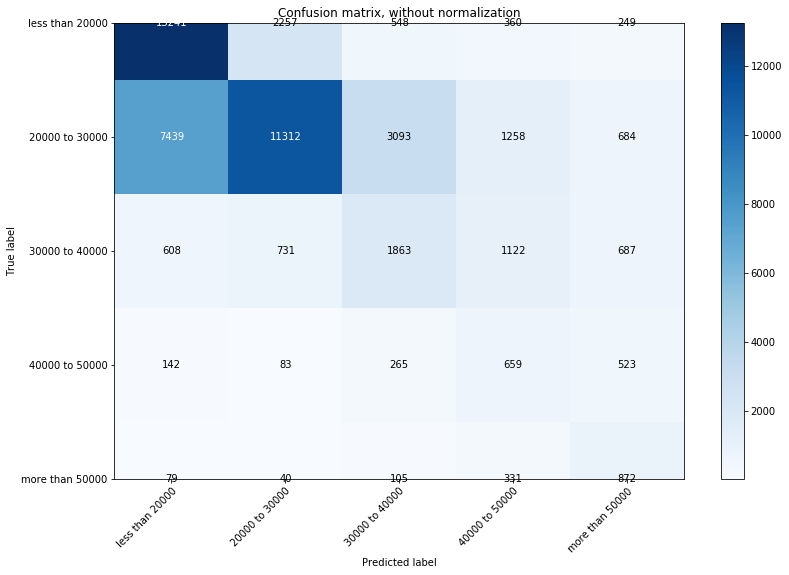

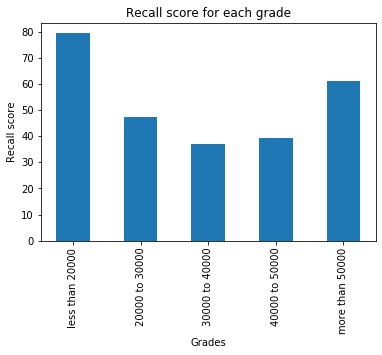

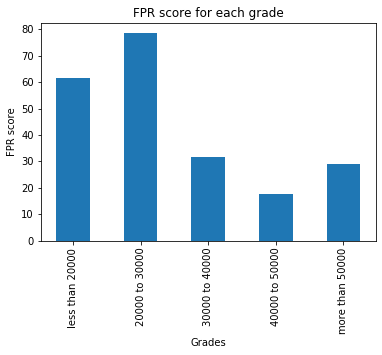

accuracy on test set is  0.5756215114003831
accuracy on training set is  0.6057982393009544
difference metrics score is  1.326392933410988


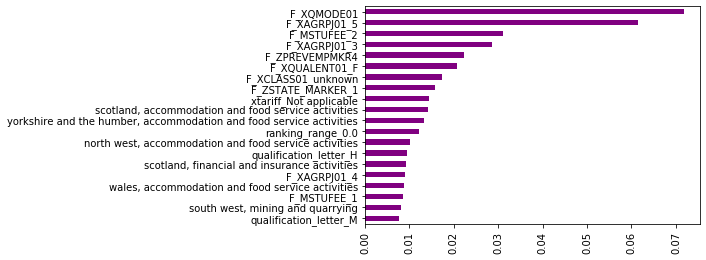

In [802]:
labels =["less than 20000",
         "20000 to 30000",
         "30000 to 40000",
         "40000 to 50000",
         "more than 50000"]

evaluate_model(rf, X_train, y_train, X_test, y_test, labels, treshold = 0.5, multi_class = True)

Confusion matrix, without normalization
[[14748  2465   643   408   319]
 [ 8322 12491  3527  1477   930]
 [  718   899  2335  1336  1008]
 [  147   119   300   770   676]
 [   88    55   136   369  1081]]


<Figure size 432x288 with 0 Axes>

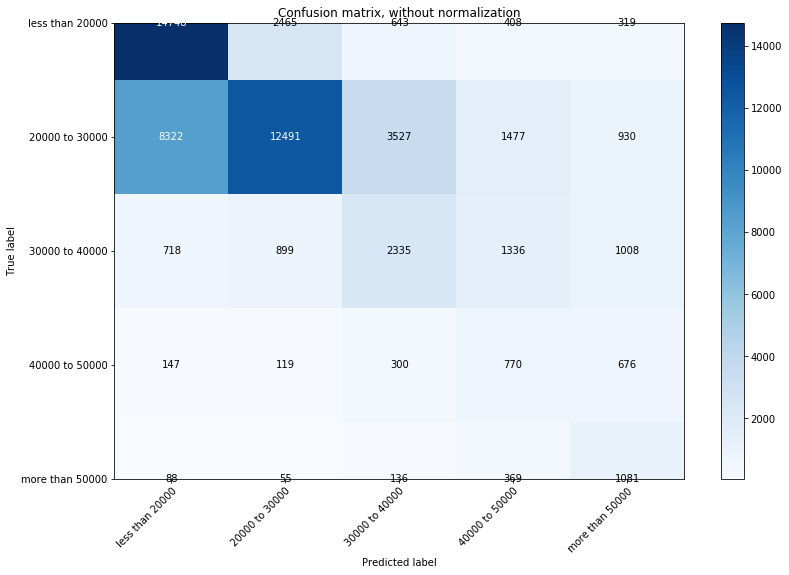

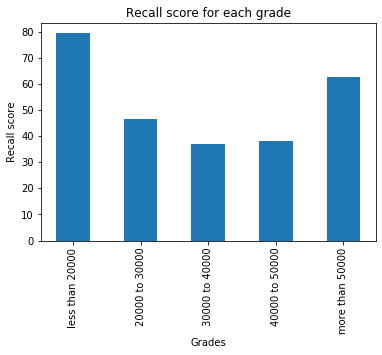

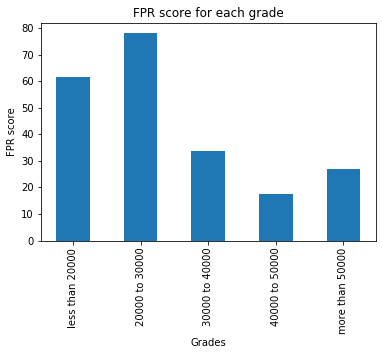

accuracy on test set is  0.5675763541459714
accuracy on training set is  0.5934512862520359
difference metrics score is  1.3509314175925153


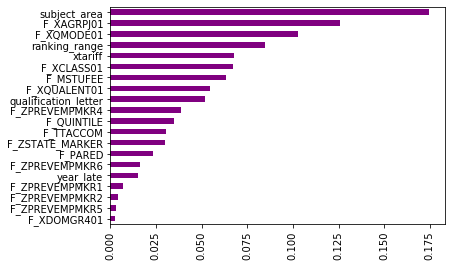

In [916]:
labels =["less than 20000",
         "20000 to 30000",
         "30000 to 40000",
         "40000 to 50000",
         "more than 50000"]

evaluate_model(rf, X_train, y_train, X_test, y_test, labels, treshold = 0.5, multi_class = True)

### Training with Grid Search CV

In [920]:
start_time = time.time()
'''
param_grid = {"max_depth":[100, 70, 40, 30, 20, 10], 
              "min_samples_leaf":[1000, 500, 100, 50, 20]}
'''
param_grid = {"max_depth":[40, 30], 
              "min_samples_leaf":[20]}


rf = RandomForestClassifier(random_state = SEED, 
                            class_weight = "balanced_subsample")

grid_cv_model_rf = grid_cv_model(rf, 
                                 param_grid, 
                                 X_train, 
                                 y_train, 
                                 X_test, 
                                 number_cv = 5, 
                                 print_score_best = True, 
                                 score = "roc_auc_ovr")

print("--- %s seconds ---" % (time.time() - start_time))

Best model is  {'max_depth': 40, 'min_samples_leaf': 20}
Best model score is  0.8360394974919974
--- 299.08206510543823 seconds ---


Confusion matrix, without normalization
[[14748  2465   643   408   319]
 [ 8322 12491  3527  1477   930]
 [  718   899  2335  1336  1008]
 [  147   119   300   770   676]
 [   88    55   136   369  1081]]


<Figure size 432x288 with 0 Axes>

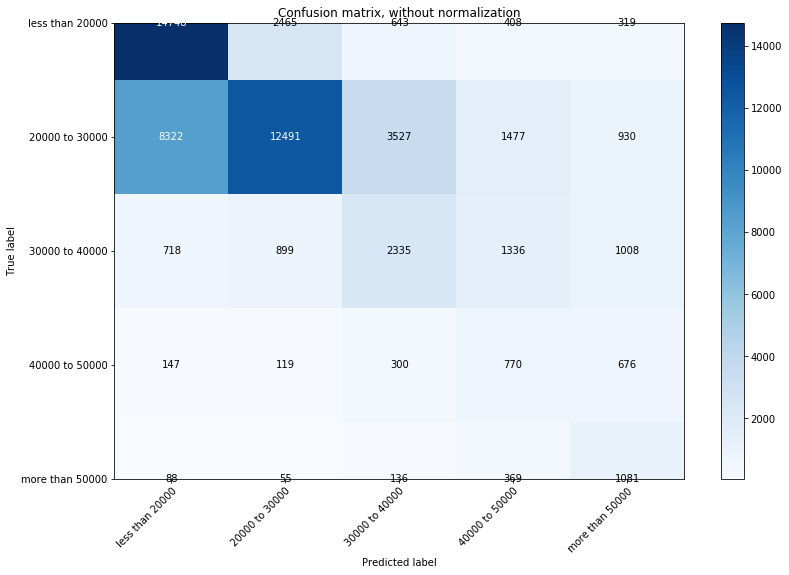

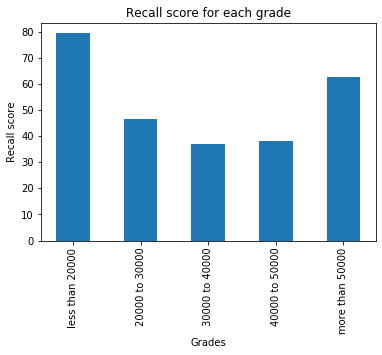

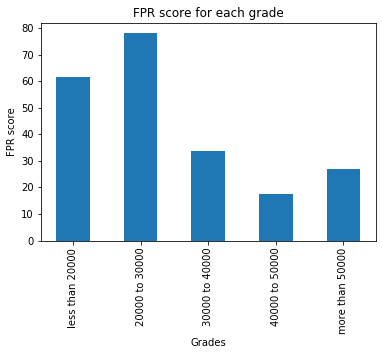

accuracy on test set is  0.5675763541459714
accuracy on training set is  0.5934512862520359
difference metrics score is  1.3509314175925153


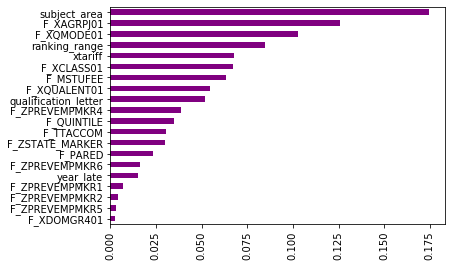

In [921]:
labels =["less than 20000",
         "20000 to 30000",
         "30000 to 40000",
         "40000 to 50000",
         "more than 50000"]

evaluate_model(grid_cv_model_rf, X_train, y_train, X_test, y_test, labels, treshold = 0.5, multi_class = True)

## Random Forest just postgrad

### Encode and train test split

In [77]:
temp_encoded = encode(temp, "salary", method = "label", y_col_method = "categorical")

In [78]:
X_train, X_test, y_train, y_test = train_test_split_method(temp_encoded, "salary", test_size = 0.15)


### Training without Grid search CV

In [82]:
temp.salary.value_counts()

20000 to 30000     53166
less than 20000    17572
30000 to 40000     17103
40000 to 50000      7623
more than 50000     7530
Name: salary, dtype: int64

In [83]:
rf = RandomForestClassifier(random_state = SEED, 
                            class_weight = "balanced_subsample", 
                            max_depth = 40, 
                            min_samples_leaf = 20)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', random_state=42)

Confusion matrix, without normalization
[[1210 1233  132   27   34]
 [ 876 6082  693  184  140]
 [ 120  874 1065  287  220]
 [  31  238  356  288  230]
 [  30  132  255  174  539]]


<Figure size 432x288 with 0 Axes>

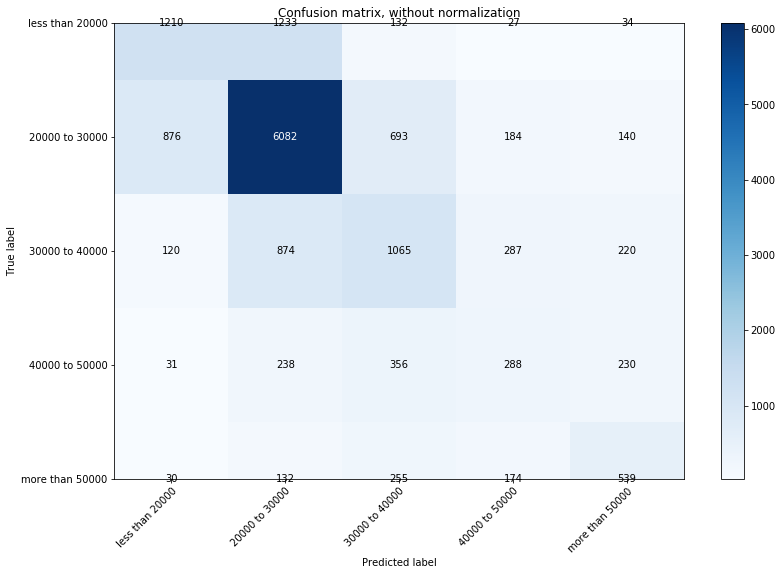

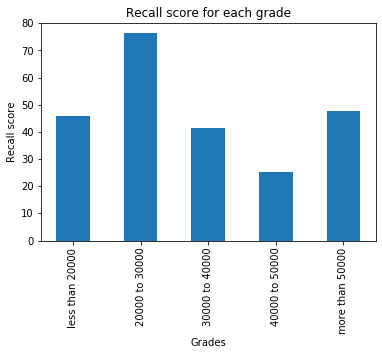

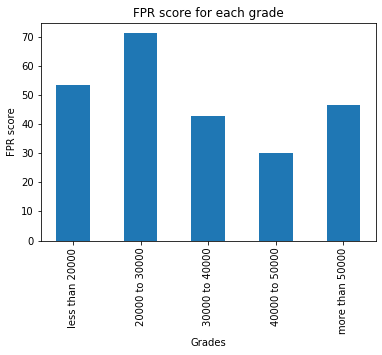

accuracy on test set is  0.5944336569579288
accuracy on training set is  0.9216508270127022
difference metrics score is  1.3193424832428982


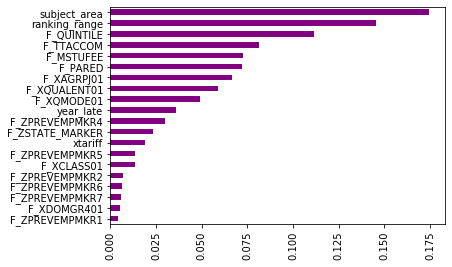

In [84]:
labels =["less than 20000",
         "20000 to 30000",
         "30000 to 40000",
         "40000 to 50000",
         "more than 50000"]

evaluate_model(rf, X_train, y_train, X_test, y_test, labels, treshold = 0.5, multi_class = True)

## XGboost

### Encode and train test split

In [759]:
temp_encoded = encode(temp, "salary", method = "label", y_col_method = "categor")

In [762]:
X_train, X_test, y_train, y_test = train_test_split_method(temp_encoded, "salary", test_size = 0.15)


### Training

In [764]:
#Choose all predictors except target & IDcols
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=15,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softprob',
 nthread=4,
 #scale_pos_weight=8,
 seed=SEED)
alg = modelfit(xgb1, X_train, y_train, useTrainCV= False)

In [765]:
evaluate_xgboost_model(alg, 
                       X_test, 
                       y_test , 
                       0.5)


Model Report


ValueError: multi_class must be in ('ovo', 'ovr')

In [767]:
y_pred = alg.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[ 8813  2420  1171    58   620    55]
 [ 4156 10047  2814   142   257   102]
 [ 1901  2680  7712   546   106   370]
 [  220   290  1482   864    13   484]
 [ 3386   838   368    28   800    25]
 [  127   136   702   420    13  1201]]


In [771]:
np.sort(confusion_matrix(y_test, y_pred).sum(axis = 1))

array([ 2599,  3353,  5445, 13137, 13315, 17518])

In [770]:
temp.salary.value_counts()

20000 to 25000     116784
25000 to 35000      88763
15000 to 20000      87581
5000 to 15000       36301
35000 to 45000      22352
more than 45000     17327
Name: salary, dtype: int64

## One vs the rest

### Encode and train test split

In [922]:
temp_encoded = encode(temp, df_prob_salary_uni, "salary", method = "label", y_col_method = "categorica")

In [923]:
X_train, X_test, y_train, y_test = train_test_split_method(temp_encoded, "salary", test_size = 0.15)


In [948]:
temp.salary.value_counts()

20000 to 30000     178309
less than 20000    123882
30000 to 40000      41972
40000 to 50000      13415
more than 50000     11530
Name: salary, dtype: int64

In [946]:
y_train.value_counts()

0    151562
3    105299
1     35676
2     11403
4      9801
Name: salary, dtype: int64

In [809]:
map_dict = {"classes":['5000 to 15000', '15000 to 20000', '20000 to 25000', '25000 to 35000', '35000 to 45000', 'more than 45000'],
           "values":[4, 0, 1, 2, 3, 5]}

df_map = pd.DataFrame(map_dict)
df_map

classes  values
0    5000 to 15000       4
1   15000 to 20000       0
2   20000 to 25000       1
3   25000 to 35000       2
4   35000 to 45000       3
5  more than 45000       5

In [940]:
def build_df_for_each_class(y):
    
    '''
    Creates a dictionanry with an entry for each class in y and gives 1 if the value of y is equal to the 
    corresponding class and 0 otherwise
        @y: Series corresponding to the dependent variable
    '''
    
    dict_classes = {}
    
    for cl in y.unique():
        
        y_temp = y.copy()
        
        if cl == 0:
            y_temp[y_temp != cl] = 2
            y_temp[y_temp == cl] = 1
            y_temp[y_temp == 2] = 0
        elif cl == 1:
            y_temp[y_temp != cl] = 0
        else:
            y_temp[y_temp != cl] = 0
            y_temp[y_temp == cl] = 1
        
        y_temp = y_temp.astype("int")
        dict_classes[cl] = y_temp
        
    return dict_classes

dict_classes_train = build_df_for_each_class(y_train)
dict_classes_test = build_df_for_each_class(y_test)

training model for class  3
    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.852459       0.000491       0.821645      0.002399
1         0.861525       0.001642       0.830781      0.002267
2         0.869471       0.002544       0.838784      0.002819
3         0.873673       0.002256       0.842068      0.002143
4         0.874522       0.002002       0.842691      0.002364
5         0.876116       0.001097       0.843890      0.000631
6         0.878266       0.001406       0.845308      0.001068
7         0.880248       0.001732       0.846229      0.001065
8         0.881890       0.001175       0.847321      0.001387
9         0.883304       0.000983       0.847987      0.001405
10        0.884635       0.000559       0.848309      0.001396
11        0.885937       0.000622       0.848871      0.001692
12        0.887134       0.000654       0.849298      0.001657
13        0.888208       0.000461       0.849706      0.001558
14        0.889592       0.

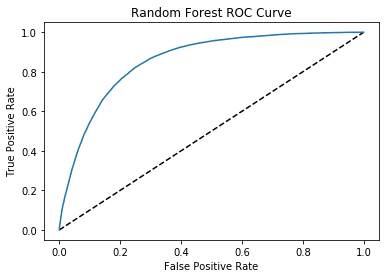

              precision    recall  f1-score   support

       False       0.70      0.91      0.79     28271
        True       0.87      0.59      0.71     27096

    accuracy                           0.76     55367
   macro avg       0.78      0.75      0.75     55367
weighted avg       0.78      0.76      0.75     55367

None
training model for class  0
     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.788978       0.000453       0.744364      0.002498
1          0.803564       0.003888       0.753219      0.003104
2          0.814894       0.003319       0.761872      0.004139
3          0.822159       0.002314       0.766769      0.002352
4          0.824380       0.002239       0.767972      0.002295
5          0.827453       0.001084       0.769933      0.001778
6          0.830414       0.000738       0.771802      0.001913
7          0.832928       0.001538       0.773193      0.002155
8          0.834745       0.001175       0.774072      0.002231


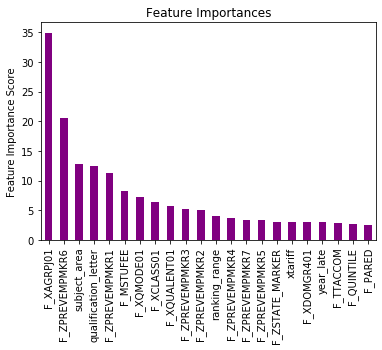

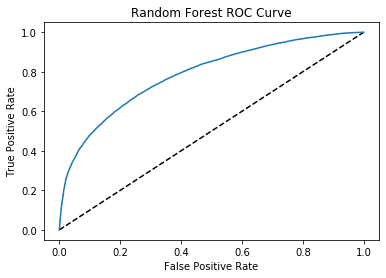

              precision    recall  f1-score   support

       False       0.55      0.77      0.64     20301
        True       0.83      0.63      0.72     35066

    accuracy                           0.68     55367
   macro avg       0.69      0.70      0.68     55367
weighted avg       0.73      0.68      0.69     55367

None
training model for class  1
    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.871727       0.000866       0.801657      0.001832
1         0.887496       0.002484       0.818002      0.002673
2         0.896108       0.002285       0.827632      0.003859
3         0.901716       0.001504       0.832615      0.003407
4         0.904439       0.001285       0.834424      0.002529
5         0.906842       0.001562       0.836266      0.003310
6         0.909279       0.001822       0.837695      0.003591
7         0.911679       0.001512       0.838958      0.003767
8         0.913903       0.000831       0.839703      0.003666
9         

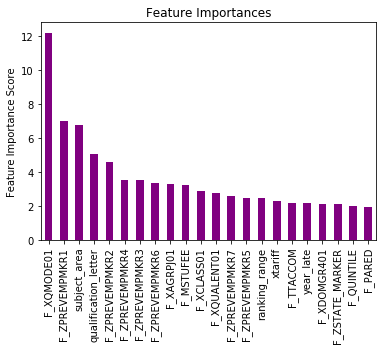

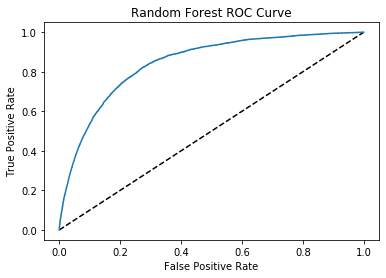

              precision    recall  f1-score   support

       False       0.81      0.96      0.88     41226
        True       0.73      0.32      0.45     14141

    accuracy                           0.80     55367
   macro avg       0.77      0.64      0.66     55367
weighted avg       0.79      0.80      0.77     55367

None
training model for class  2
    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.915553       0.001070       0.826612      0.003064
1         0.934492       0.001149       0.848669      0.004160
2         0.942782       0.001426       0.860652      0.002174
3         0.947694       0.001014       0.867837      0.002873
4         0.949675       0.001232       0.870794      0.001815
5         0.951818       0.001252       0.873246      0.002036
6         0.953623       0.001218       0.874910      0.002234
7         0.955410       0.000777       0.876611      0.002382
8         0.957086       0.000349       0.877338      0.002550
9         

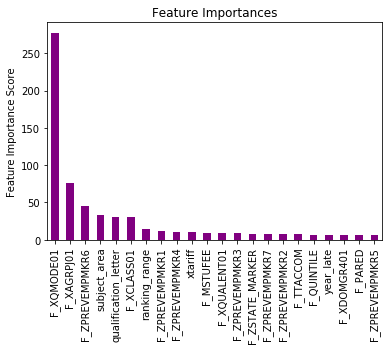

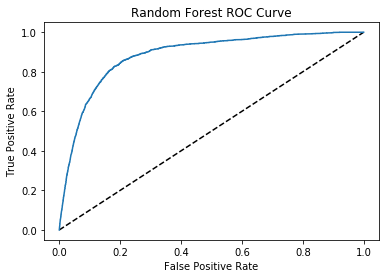

              precision    recall  f1-score   support

       False       0.88      0.99      0.93     47743
        True       0.71      0.19      0.30      7624

    accuracy                           0.88     55367
   macro avg       0.80      0.59      0.61     55367
weighted avg       0.86      0.88      0.85     55367

None
training model for class  4
    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.949159       0.000950       0.879939      0.004520
1         0.963132       0.000676       0.892412      0.006844
2         0.968455       0.000730       0.902611      0.005581
3         0.971492       0.000536       0.908832      0.003774
4         0.973153       0.000589       0.911046      0.003722
5         0.974354       0.001144       0.913373      0.004734
6         0.975379       0.001039       0.914838      0.005114
7         0.976233       0.000838       0.916653      0.004863
8         0.977242       0.000720       0.917488      0.004960
9         

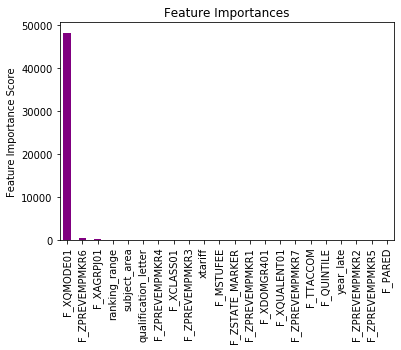

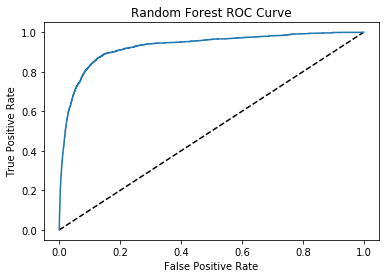

              precision    recall  f1-score   support

       False       0.93      0.99      0.96     50448
        True       0.75      0.26      0.39      4919

    accuracy                           0.93     55367
   macro avg       0.84      0.63      0.68     55367
weighted avg       0.92      0.93      0.91     55367

None


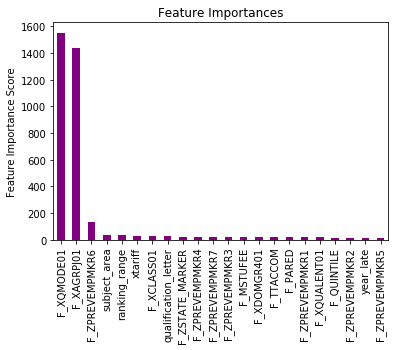

In [949]:
def compute_model_for_each_class(X_train, X_test, dict_classes_train, dict_classes_test, l_class, model = "XGboost"):
    
    '''
    Builds a binary classifier model for each entry of the dictionary and evaluates the model 
    
        @X_train: X training data with predictors already encoded
        @X_test: X test data with predictors already encoded
        @dict_classes_train: Contains the binary y train series for each entry of the dictionary
        @dict_classes_test: Contains the binary y test series for each entry of the dictionary
    '''
    
    dict_models = {}
    
    #loop in the right order where each entry of l_class is associated with a model
    for cl in l_class:
        
        print("training model for class ", cl)
        
        if model == "XGboost":
            
            weight_ratio = dict_classes_train[cl].size/dict_classes_train[cl].sum()

            alg = XGBClassifier(learning_rate =0.1,
                                            n_estimators=1000,
                                            max_depth=15,
                                            min_child_weight=1,
                                            gamma=0,
                                            subsample=0.8,
                                            colsample_bytree=0.8,
                                            objective= 'binary:logistic',
                                            nthread=4,
                                            scale_pos_weight=weight_ratio,
                                            seed=SEED)
            
            dict_models[cl] = modelfit(alg, X_train, dict_classes_train[cl], useTrainCV= True)
            print(evaluate_xgboost_model(dict_models[cl], X_test, dict_classes_test[cl], 0.5))
        elif model == "rf":
            
            dict_models[cl] = RandomForestClassifier(random_state = SEED, 
                                                     class_weight = "balanced_subsample", 
                                                     max_depth = 50, 
                                                     min_samples_leaf = 20)
                                                                                  
            dict_models[cl].fit(X_train, dict_classes_train[cl])
        
            print(evaluate_model(dict_models[cl], X_train, dict_classes_train[cl], X_test, dict_classes_test[cl], l_class, multi_class = False))
        
        
    return dict_models

labels =[3,0,1,2,4]

dict_models = compute_model_for_each_class(X_train, 
                                           X_test, 
                                           dict_classes_train, 
                                           dict_classes_test, 
                                           labels, 
                                           model = "XGboost")

                                           

In [1689]:
#class 1: less than 25 to 140 (5): 411 data 
#class 2: 240 to 300: 361 data
#class 3: 300 to 400 (2): 388 data 
#class 4: 400 to 600 (2): 613
#class 5: 600 to 900 (3): 407
#class 6: More than 900 (3): 157

In [950]:
def build_needed_data_structure(dict_models):
    
    '''
    build index a list going from 0 to number of models (so number of classes)
    build dict_y a dictionary with the index in keys and the different classes as values (to be used to make prediction)
    build dict_diff the inverse of dict_y for keys and values (to be used in the different metrics function)
     
        @dict_models: Dictionary where each key is a class value from income and values is the associated model 
    '''
    
    index = range(len(dict_models))
    dict_y = dict(zip(index, dict_models.keys()))
    l_models = list(dict_models.values())
    dict_diff = {v: k for k, v in dict_y.items()}
    
    return dict_y, l_models, dict_diff

dict_y, l_models, dict_diff = build_needed_data_structure(dict_models)
    

In [951]:
def get_prediction_matrix(l_models, X_test):
    
    '''
    Computes a prediction matrix where each row is an observation and each coluum corresponds to the probabiliy 
    of getting the class associated with the corresponding model number (column 1 for model 1  and column p 
    for model p) 
    
        @l_models: A list of all different models for each class 
    '''
    
    for index in range(len(l_models)):

        if index == 0:

            pred_0 = l_models[0].predict_proba(X_test)[:,1]
            pred_1 = l_models[1].predict_proba(X_test)[:,1]

            pred_0 = pred_0.reshape((len(pred_0), 1))
            pred_1 = pred_1.reshape((len(pred_1), 1))

            m = np.concatenate((pred_0, pred_1), axis = 1)
        
        else:
            try:
                pred_i = l_models[index+1].predict_proba(X_test)[:,1]

                pred_i = pred_i.reshape((len(pred_i), 1))

                m = np.concatenate((m, pred_i), axis = 1)
            except:
                break
    
    return m
    

In [952]:
def multi_model_predict(l_models, X_test, dict_y):
    
    '''
    Associate a given observation to a class (predicts) by associating this observation to the model that 
    maximises the proability of this class model (so if probability is maximised on column j, then predicts the class
    associated with model j)
    
        @l_models: A list of all different models for each class 
        @dict_y: A dictionary with the index in keys and the different classes as values (to be used to make prediction)
    '''
    
    matrix_pred = get_prediction_matrix(l_models, X_test)
    y_pred = []
    for i in np.argmax(matrix_pred, axis = 1):
        y_pred.append(dict_y[i])
    
    return y_pred

y_pred_multi = multi_model_predict(l_models, X_test, dict_y)



Confusion matrix, without normalization
[[14144  3877   347   114   101]
 [ 6632 16956  2329   417   413]
 [  576  1863  2772   511   574]
 [  144   280   613   472   503]
 [   76   153   273   225  1002]]


<Figure size 432x288 with 0 Axes>

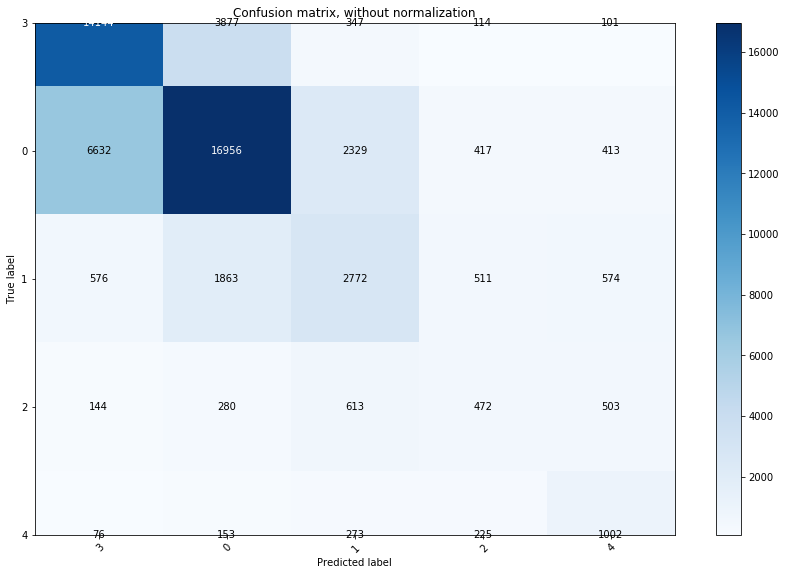

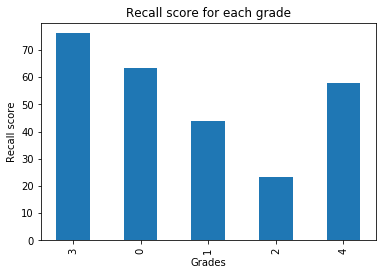

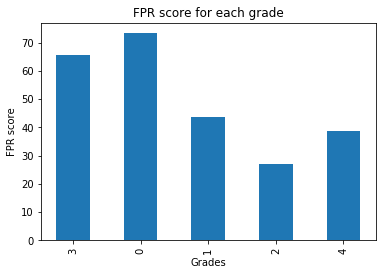

accuracy on test set is  0.6383947116513446
difference metrics score is  1.2320563408421157


In [956]:
labels = [3,0,1,2,4]
l_labels = np.array(labels)
        
index = range(len(l_labels))
dict_diff = dict(zip(l_labels, index))


cm = confusion_matrix(y_test, y_pred_multi, labels = l_labels)

#get confusion matrix
plot_confusion_matrix_t(y_test, y_pred_multi, l_labels)

#get recall score
l_recall_score = []
for i in l_labels:
    l_recall_score.append(get_recall_metrics(cm, dict_diff, i))

build_bar_plot(l_labels, 
               l_recall_score, 
               "Grades", 
               "Recall score", 
               "Recall score for each grade")

#get fpr score
l_fpr_score = []
for i in l_labels:
    l_fpr_score.append(get_fpr_metrics(cm, dict_diff, i))

build_bar_plot(l_labels, 
               l_fpr_score, 
               "Grades", 
               "FPR score", 
               "FPR score for each grade")

#get accuracy score
print("accuracy on test set is ", accuracy_score(y_test, y_pred_multi))
#print("accuracy on training set is ", accuracy_score(y_train, y_pred_train))

#get difference metrics 
difference_metrics_score, l_score = difference_metrics(dict_diff, y_test, y_pred_multi, incorrect_only = True)
print("difference metrics score is ", difference_metrics_score)

Confusion matrix, without normalization
[[1763 2619  575  355   82   51]
 [2143 7814 1725 1173  149  133]
 [ 989 4048 8958 2925  356  242]
 [ 394 1898 1948 7398  904  773]
 [  51  208  177 1107  978  832]
 [  38  110   48  402  424 1577]]


<Figure size 432x288 with 0 Axes>

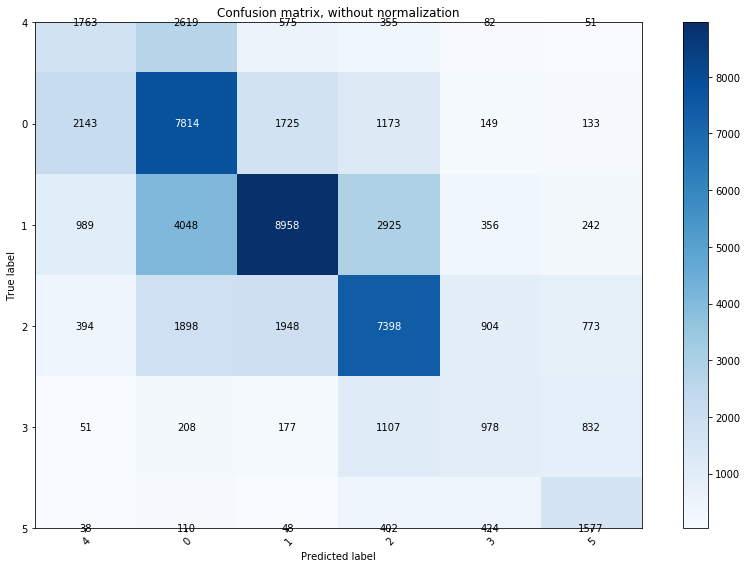

In [864]:
l_labels = map_dict["values"]
plot_confusion_matrix_t(y_test, y_pred_multi, l_labels)

Confusion matrix, without normalization
[[2084 2429  356  347  134   95]
 [2769 7534  974 1299  344  217]
 [1300 4698 7528 3004  639  349]
 [ 484 2324 1495 6320 1719  973]
 [  79  217   82  853 1285  837]
 [  37  106   23  288  611 1534]]


<Figure size 432x288 with 0 Axes>

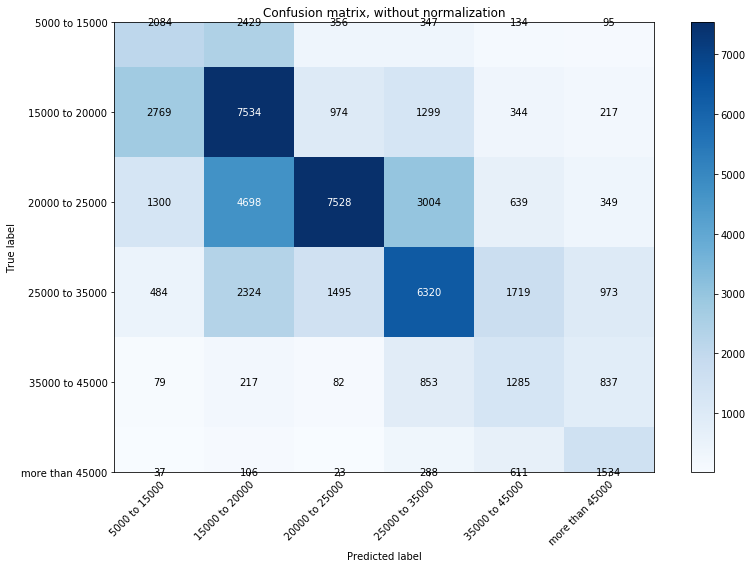

In [791]:
l_labels = ['5000 to 15000', 
               '15000 to 20000', 
               '20000 to 25000',
               '25000 to 35000', 
               '35000 to 45000', 
               'more than 45000']

plot_confusion_matrix_t(y_test, y_pred_multi, l_labels)

Confusion matrix, without normalization
[[2945 1586  318  310  160  126]
 [4546 5767  907 1186  423  308]
 [2168 3961 7264 2755  894  476]
 [ 764 2092 1384 5362 2368 1345]
 [ 112  180   76  577 1354 1054]
 [  73   71   21  168  543 1723]]


<Figure size 432x288 with 0 Axes>

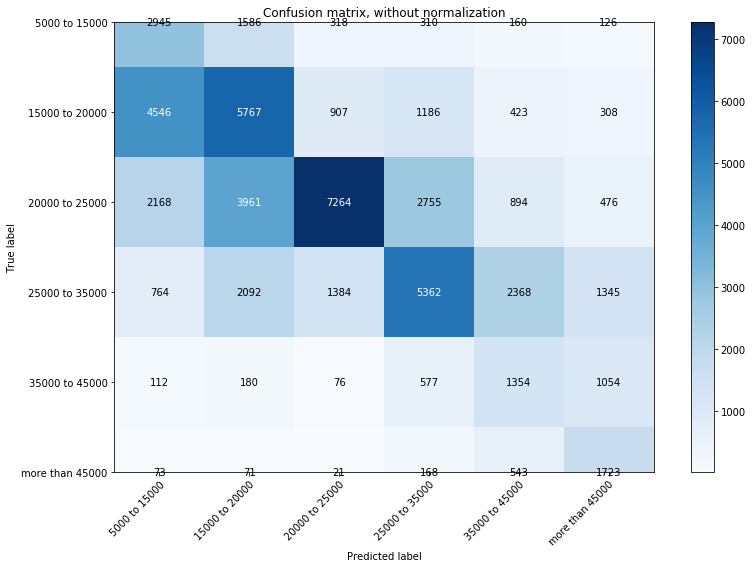

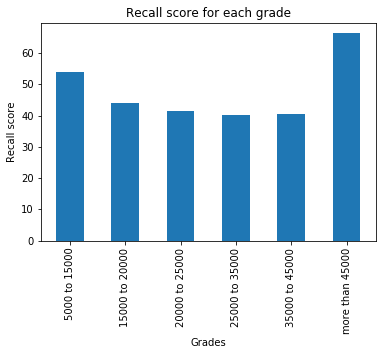

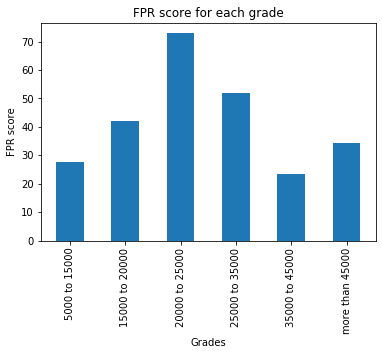

accuracy on test set is  0.44096664077880326
accuracy on training set is  0.47406937569523905
difference metrics score is  1.4957353321271647


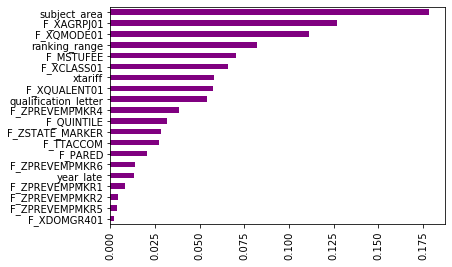

In [793]:
evaluate_model(rf, X_train, y_train, X_test, y_test, labels, treshold = 0.5, multi_class = True)

In [954]:
accuracy_score(y_test, y_pred_multi)

0.6383947116513446

# Country prediction

## Processing

In [135]:
def process_y_variable(df):
    
    #remove missing values
    df = df[df["F_XLOCUC01"] != "NOTK"]
    
    l_working_uk = ["1", "2", "3", "4", "5", "6"]
    
    df["F_XLOCUC01"] = df["F_XLOCUC01"].apply(lambda x: 0 if x in l_working_uk else 1)
    
    return df


def process_nationality_variable(df):
    
    def conditions_on_nation(x):
        
        if x == "GB":
            return "GB"
        elif x == "ZZ":
            return "unknown"
        else:
            return "foreigner"
    
    df["F_NATION"] = df["F_NATION"].apply(conditions_on_nation)
    
    return df

def remove_useless_var(df):
    
    '''
    Remove built in variables, those we replaced or we cant use
        @df: Main dataframe 
    '''
    
    var = ["AcYear",
           "F_XINSTID01",
           "F_YEARSTU",
           "F_YEARPRG",
           "F_XACTIV02",
           "year_difference",
           "F_YEARPRG_numeric",
           "F_YEARSTU_numeric",
           "F_XJACS01",
           "F_XOBTND01",
           "Field Name",
           "Data", 
           "match",
           "uni_complete_guide",
           "ranking",
           "uni_type",
           "fuzzi_score", 
           "Label",
           "uni_name", 
           "Total", 
           "F_ZTOP_ALEVELS"]
    
    #remove variables that we cannot use ethically
   # var_unethical = ["F_SEXID", 
    #                 "DW_ZSTUDIS_MARKER", 
     #                "F_ETHNIC"]
    
    #df = df.drop(var_unethical, axis = 1)
    
    df = df.drop(var, axis = 1)
    
    return df

def country_processing(df):
       
    df = process_y_variable(df)   
    
    df = process_nationality_variable(df)
    
    df = get_main_course_area(df)
    
    df = get_main_qualification_letter(df)
    
    df = compare_year_prog_and_year_stud(df)
    
    df = imput_NA_in_degree_class(df)
    
    df = remove_under_represented_class(df, ["F_XINSTID01", "F_MSTUFEE", "F_XAGRPJ01"])
    
    df = create_uni_ranking_var(df, df_dict, df_uni_all)
    
    df = create_uni_ranking_range(df)
    
    df = remove_useless_var(df)
    
    df = convert_discreteint_to_cat(df)
    
    df = df.drop("salary", axis = 1)
    
    return df

In [136]:
yo = country_processing(df)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

## ML

### Random Forest

#### Encode and train test split

In [141]:
temp_encoded = encode(yo, "F_XLOCUC01", method = "mean", y_col_method = "categorical")

In [143]:
yo


xtariff  F_XDOMGR401 F_QUINTILE F_XCLASS01 F_MSTUFEE  \
0       Not applicable            1          3    unknown        81   
1       Not applicable            1          3          4         3   
2       Not applicable            1          1          2         1   
3       Not applicable            1          5          2         1   
4       Not applicable            1          1    unknown        81   
...                ...          ...        ...        ...       ...   
681324  Not applicable            2          .          2         1   
681325  Not applicable            2          .          5         3   
681326  Not applicable            2          .    unknown         1   
681327  Not applicable            1          1    unknown         1   
681328  Not applicable            2          .    unknown         1   

        F_ZPREVEMPMKR1  F_ZPREVEMPMKR2  F_ZPREVEMPMKR3  F_ZPREVEMPMKR4  \
0                    0               0               0               1   
1                    0               0               0               1   
2                    0               0               0               1   
3                    0               0               0               1   
4                    0               0               0               1   
...                ...             ...             ...             ...   
681324               0               0               0               0   
681325               0               0               0               0   
681326               0               0               0               0   
681327               0               0               0               0   
681328               0               0               0               1   

        F_ZPREVEMPMKR5  F_ZPREVEMPMKR6  F_ZPREVEMPMKR7 F_SEXID  F_XQMODE01  \
0                    0               0               0       2           2   
1                    0               0               0       2           2   
2                    0               0               0       2           2   
3                    0               0               0       2           2   
4                    0               0               0       2           2   
...                ...             ...             ...     ...         ...   
681324               0               0               0       2           1   
681325               0               0               0       2           1   
681326               0               0               0       2           1   
681327               0               0               0       2           1   
681328               0               0               0       2           1   

       F_XQUALENT01 F_XAGRPJ01  F_XLOCUC01   F_NATION F_ZSTATE_MARKER  \
0                 G          5           0         GB               U   
1                 D          5           0         GB               U   
2                 C          5           0         GB               1   
3                 D          5           0         GB               1   
4                 D          4           0         GB               1   
...             ...        ...         ...        ...             ...   
681324            C          4           0  foreigner               U   
681325            I          3           0  foreigner               U   
681326            C          4           1  foreigner               U   
681327            C          3           0         GB               U   
681328            C          5           1         GB               1   

       F_TTACCOM  DW_ZSTUDIS_MARKER F_ETHNIC F_PARED subject_area  \
0              5                  2    White       8            B   
1              5                  2    White       9            B   
2              5                  2    Other       1            B   
3              5                  2    White       2            B   
4              5                  2    White       2            B   
...          ...                ...      ... 

In [145]:
X_train, X_test, y_train, y_test = train_test_split_method(temp_encoded, "F_XLOCUC01", test_size = 0.15)

#### Training without Grid Search CV

In [149]:
rf = RandomForestClassifier(random_state = SEED, 
                            class_weight = "balanced_subsample", 
                            max_depth = 30, 
                            min_samples_leaf = 50)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=30,
                       min_samples_leaf=50, random_state=42)

Confusion matrix, without normalization
[[85375 11506]
 [ 1652  3667]]


<Figure size 432x288 with 0 Axes>

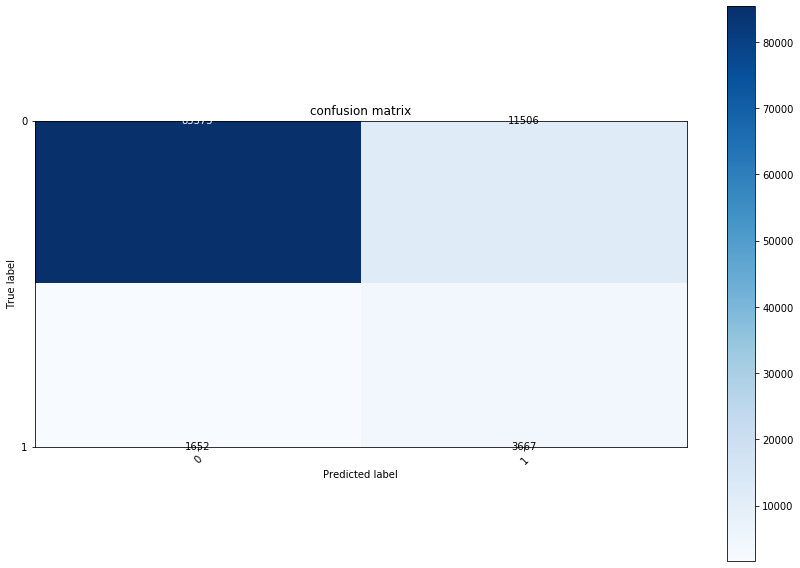

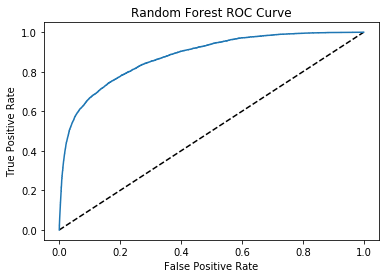

              precision    recall  f1-score   support

       False       0.88      0.98      0.93     87027
        True       0.69      0.24      0.36     15173

    accuracy                           0.87    102200
   macro avg       0.79      0.61      0.64    102200
weighted avg       0.85      0.87      0.84    102200

AUC score is 0.7853255232235055
recall on test set is  0.6894153036285016
accuracy on test set is  0.871252446183953
recall on training set is  0.7460017253965094
accuracy on training set is  0.8754267183995276


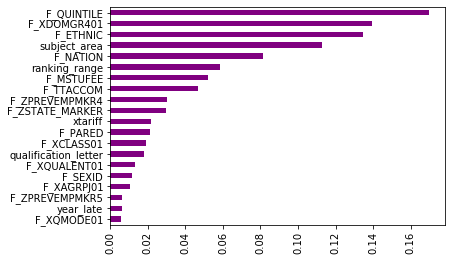

In [150]:
evaluate_model(rf, X_train, y_train, X_test, y_test, [1,0], treshold = 0.5, multi_class = False)

# A bif of analysis

In [15]:
group_no_help = temp[temp["F_MSTUFEE"] == "1"]
group_just_slc = temp[(temp["F_MSTUFEE"] != "1") & (temp["F_MSTUFEE"] != "52")]
group_mix = temp[temp["F_MSTUFEE"] == "52"]

In [84]:
dict_tuition_help = {"group_no_help":group_no_help, 
                     "group_just_slc":group_just_slc, 
                     "group_mix":group_mix}

def get_prop(df):
    
    yo = df.groupby("salary")["xtariff"].count()/df.shape[0]
    yo = pd.DataFrame(yo)
    yo["temp"] = [3, 5 , 4 , 6 ,2 ,7 ,1]
    yo = yo.sort_values("temp")
    yo = yo["xtariff"]
    return yo



for i in dict_tuition_help.keys():
    
    dict_tuition_help[i] = get_prop(dict_tuition_help[i])
    


In [89]:
dict_polar = {}

for i in range(1,6):
    
    dict_polar[str(i)] = get_prop(temp[temp["F_QUINTILE"] == str(i)])
    

In [90]:
dict_polar

{'1': salary
 unemployed         0.090547
 5000 to 15000      0.113332
 20000.0            0.237462
 25000.0            0.312158
 25000 to 35000     0.173589
 35000 to 45000     0.045075
 more than 45000    0.027838
 Name: xtariff, dtype: float64, '2': salary
 unemployed         0.085630
 5000 to 15000      0.104733
 20000.0            0.230497
 25000.0            0.303755
 25000 to 35000     0.191179
 35000 to 45000     0.052280
 more than 45000    0.031927
 Name: xtariff, dtype: float64, '3': salary
 unemployed         0.085174
 5000 to 15000      0.094706
 20000.0            0.226260
 25000.0            0.298940
 25000 to 35000     0.204699
 35000 to 45000     0.051570
 more than 45000    0.038652
 Name: xtariff, dtype: float64, '4': salary
 unemployed         0.090396
 5000 to 15000      0.085491
 20000.0            0.215206
 25000.0            0.284725
 25000 to 35000     0.221980
 35000 to 45000     0.057344
 more than 45000    0.044858
 Name: xtariff, dtype: float64, '5': salary

<BarContainer object of 4 artists>

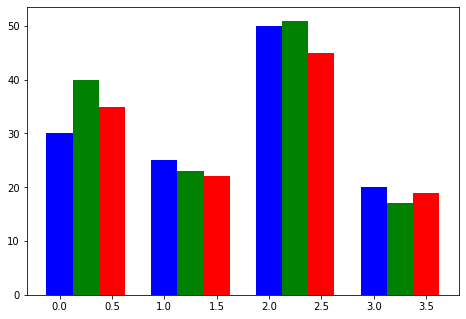

In [35]:
import numpy as np
import matplotlib.pyplot as plt
data = [[30, 25, 50, 20],
[40, 23, 51, 17],
[35, 22, 45, 19]]
X = np.arange(4)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.25)
ax.bar(X + 0.25, data[1], color = 'g', width = 0.25)
ax.bar(X + 0.50, data[2], color = 'r', width = 0.25)

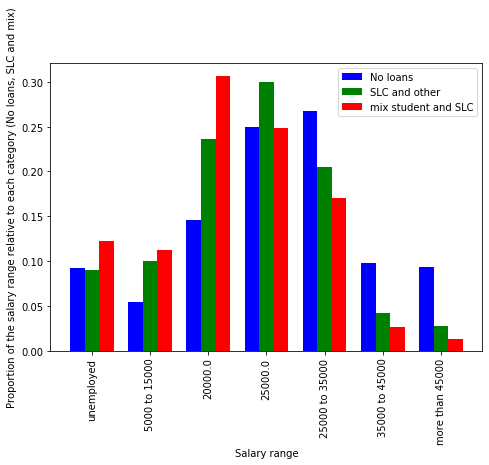

In [123]:
import numpy as np
import matplotlib.pyplot as plt
data = [[30, 25, 50, 20],
[40, 23, 51, 17],
[35, 22, 45, 19]]
X = np.arange(7)
tick_position = np.arange(7) + 0.25 #range(1,8)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, dict_tuition_help["group_no_help"], color = 'b', width = 0.25, label = "No loans")
ax.bar(X + 0.25, dict_tuition_help["group_just_slc"], color = 'g', width = 0.25, label = "SLC and other")
ax.bar(X + 0.50, dict_tuition_help["group_mix"], color = 'r', width = 0.25, label = "mix student and SLC")
ax.set_xticks(tick_position)
ax.set_xticklabels(dict_tuition_help["group_no_help"].index)
ax.set_xlabel("Salary range")
ax.set_ylabel("Proportion of the salary range relative to each category (No loans, SLC and mix)")
plt.xticks(rotation = 90)
plt.legend(loc = "upper right")

plt.savefig("salary_comparison.png")

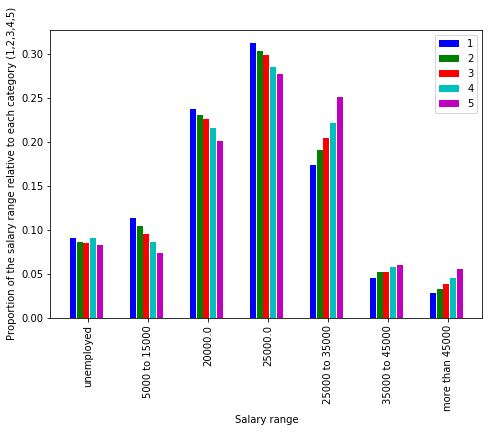

In [122]:
import numpy as np
import matplotlib.pyplot as plt

l_color = ["b", "g", "r", "c", "m"]
increase = np.arange(5)/9
index = 0
X = np.arange(7)
tick_position = np.arange(7) + 0.25 #range(1,8)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

for i, j in dict_polar.items():
    ax.bar(X + increase[index], dict_polar[i], color = l_color[index], width = 0.1, label = i)
    index += 1
    
ax.set_xticks(tick_position)
ax.set_xticklabels(dict_tuition_help["group_no_help"].index)
ax.set_xlabel("Salary range")
ax.set_ylabel("Proportion of the salary range relative to each category (1,2,3,4,5)")
plt.xticks(rotation = 90)
plt.legend(loc = "upper right")

plt.savefig("salary_comparison_polar.png")

In [124]:
temp.F_QUINTILE.value_counts()

5                   119253
4                    86652
3                    70914
2                    57632
1                    40377
.                    18325
Northern Ireland     12516
Name: F_QUINTILE, dtype: int64

In [125]:
dict_polar

{'1': salary
 unemployed         0.090547
 5000 to 15000      0.113332
 20000.0            0.237462
 25000.0            0.312158
 25000 to 35000     0.173589
 35000 to 45000     0.045075
 more than 45000    0.027838
 Name: xtariff, dtype: float64, '2': salary
 unemployed         0.085630
 5000 to 15000      0.104733
 20000.0            0.230497
 25000.0            0.303755
 25000 to 35000     0.191179
 35000 to 45000     0.052280
 more than 45000    0.031927
 Name: xtariff, dtype: float64, '3': salary
 unemployed         0.085174
 5000 to 15000      0.094706
 20000.0            0.226260
 25000.0            0.298940
 25000 to 35000     0.204699
 35000 to 45000     0.051570
 more than 45000    0.038652
 Name: xtariff, dtype: float64, '4': salary
 unemployed         0.090396
 5000 to 15000      0.085491
 20000.0            0.215206
 25000.0            0.284725
 25000 to 35000     0.221980
 35000 to 45000     0.057344
 more than 45000    0.044858
 Name: xtariff, dtype: float64, '5': salary

In [144]:
#100,000/{[(1+0.00583)^360]-1}/[0.00583(1+0.00583)^360]

(6000/((((1+0.01325)**83) - 1)/(0.01325*(1+0.01325)**83)))

119.61500246409844

In [148]:
(10000/((((1+0.01231667)**84) - 1)/(0.01231667*(1+0.01231667)**84)))

191.73533930821102

In [ ]:
'''
Representative Example 18.7% APR (variable)*
Borrow
£5,000 for 89 months
Origination fee
£425
Total amount repayable
£9,270.88
Interest rate
14.78% p.a. (variable)
Repayments
5 payments of £5/month
84 payments of £110.07/month

'''

# Compare variables mean for missclassifed points in binary classification

xtariff
F_XDOMGR401
F_QUINTILE
F_XCLASS01
F_MSTUFEE
F_ZPREVEMPMKR1
F_ZPREVEMPMKR2
F_ZPREVEMPMKR3
F_ZPREVEMPMKR4
F_ZPREVEMPMKR5
F_ZPREVEMPMKR6
F_ZPREVEMPMKR7
F_XQMODE01
F_XQUALENT01
F_XAGRPJ01
F_ZSTATE_MARKER
F_TTACCOM
F_PARED
employment
cannot insert employment, already exists
subject_area
qualification_letter
year_late


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ranking_range


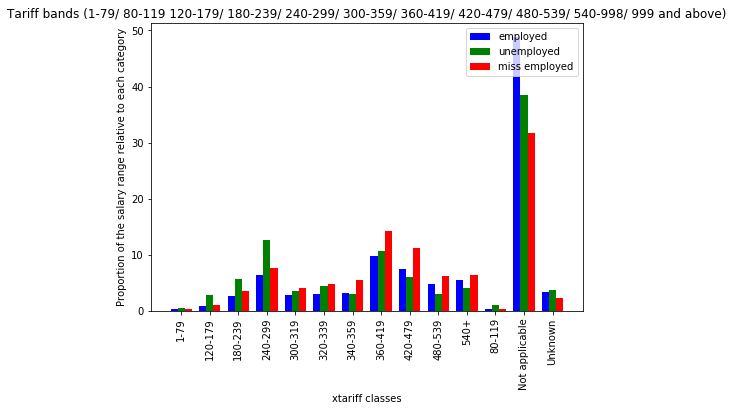

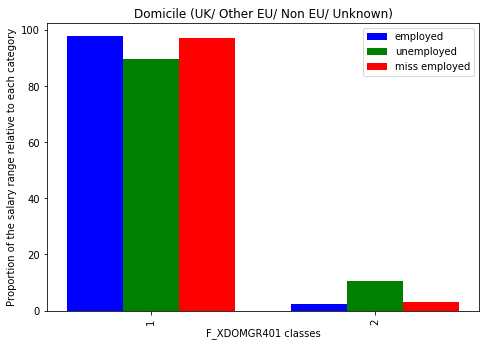

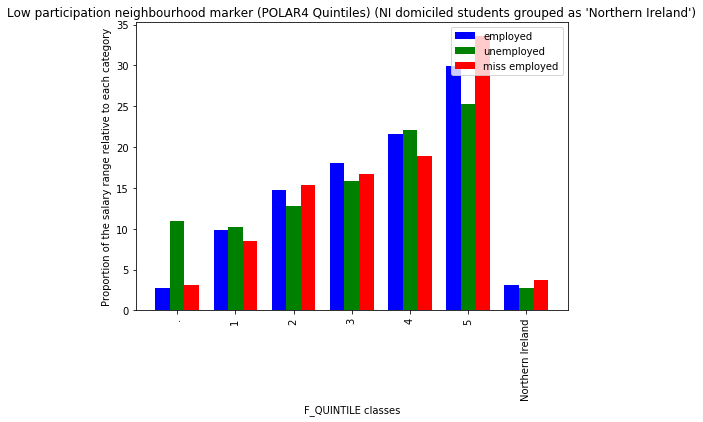

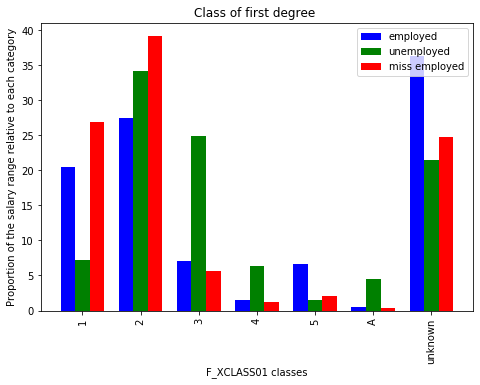

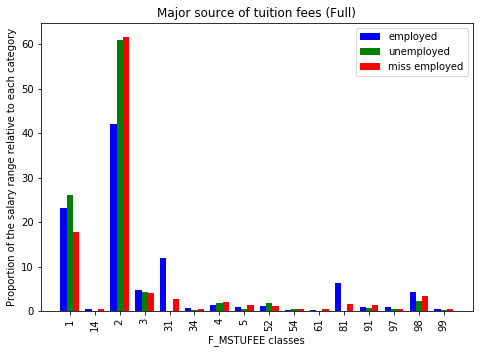

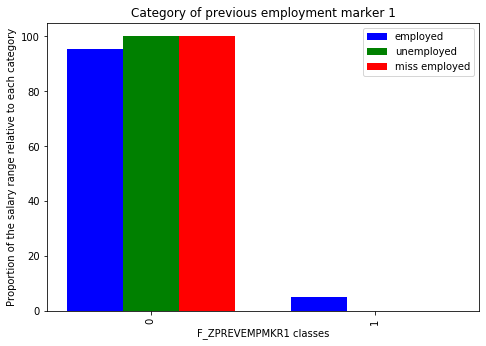

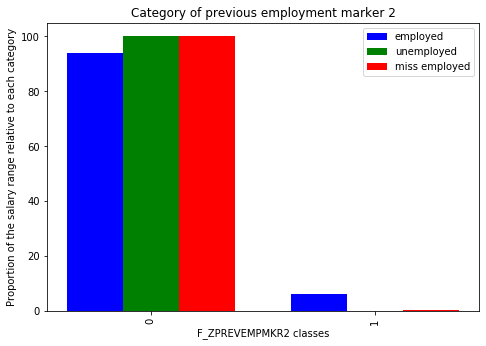

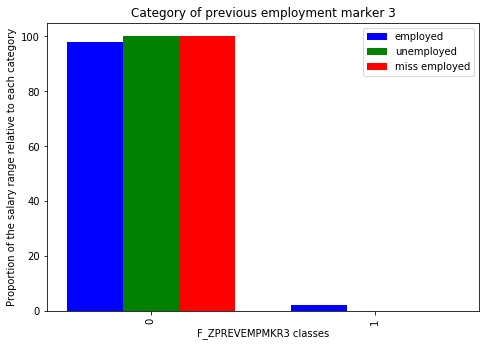

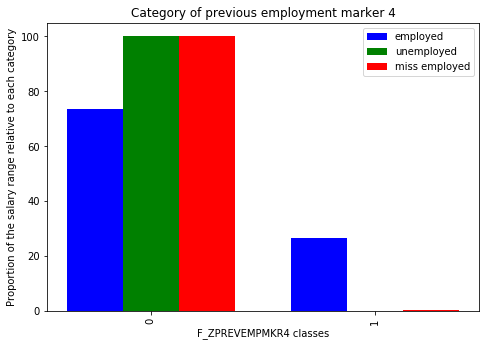

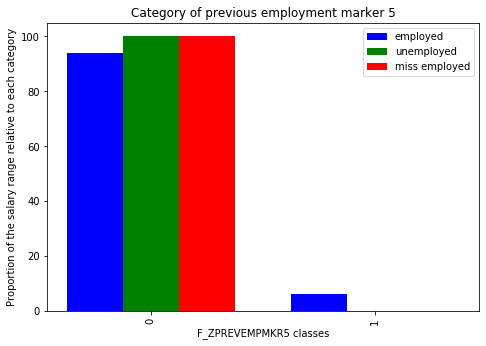

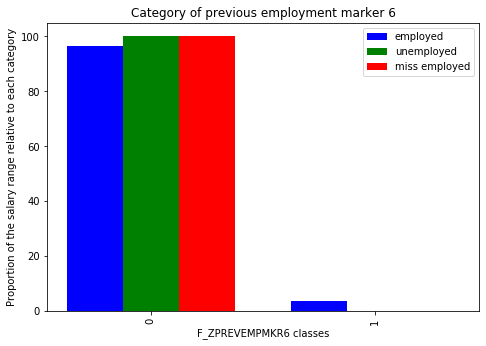

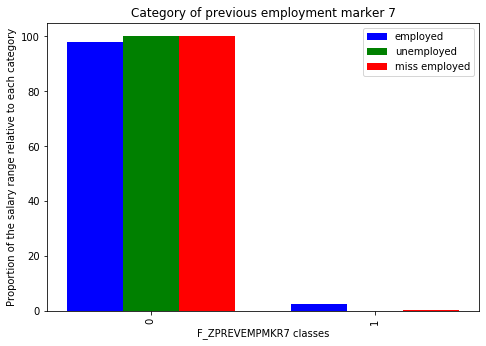

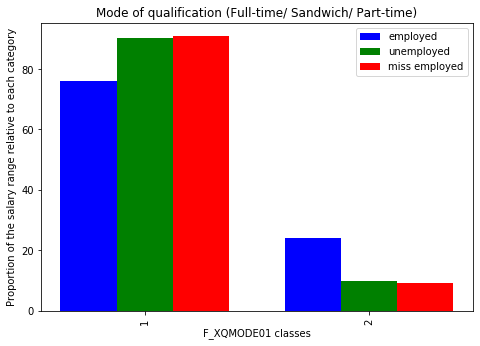

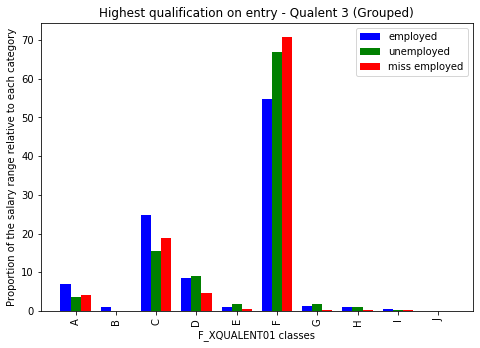

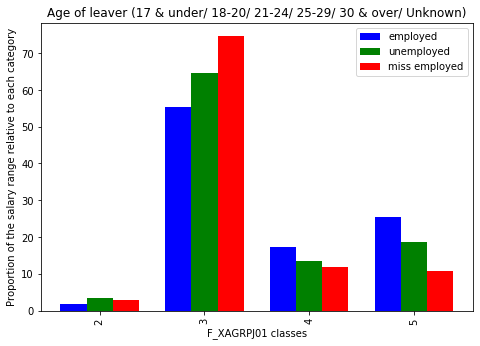

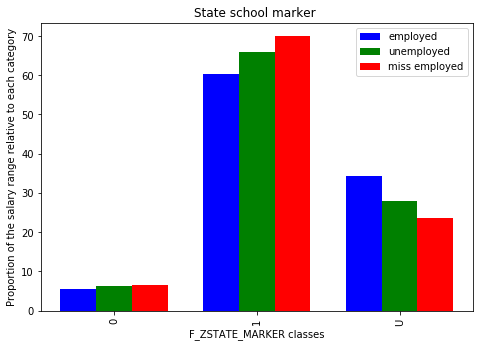

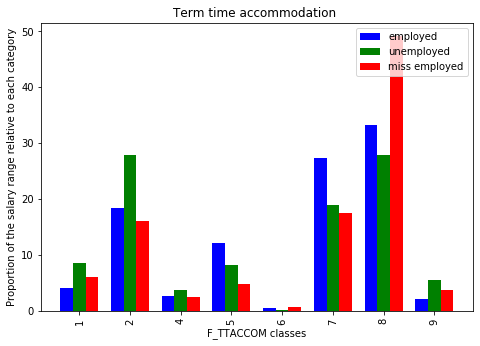

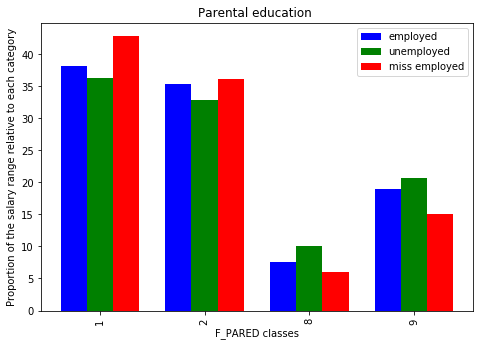

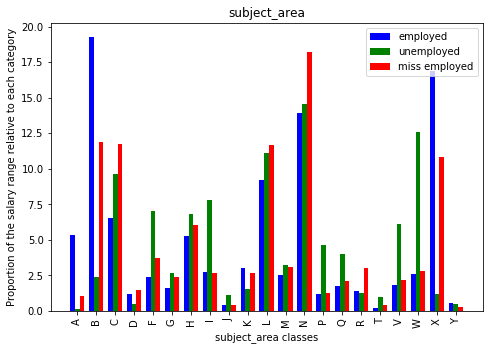

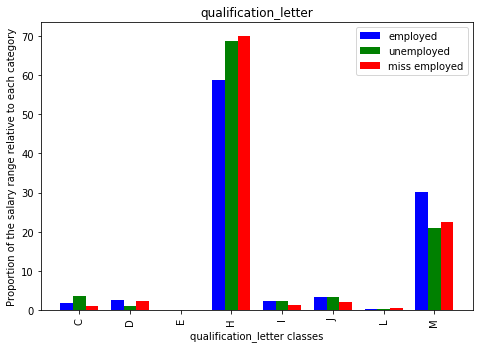

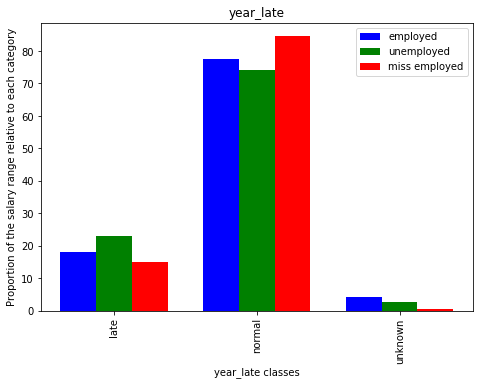

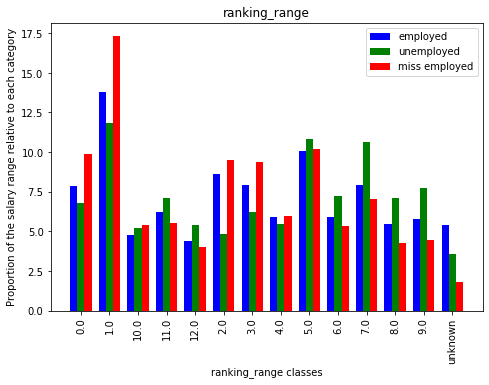

In [457]:
def compare(series_emp, series_unemp, series_miss_unemp, var_name):
    #print(series_emp)
    #print(series_miss_unemp)
    title_name = var_name
    index = series_emp.index
    if any(df_dict_title["Field"] == var_name):
        title_name = df_dict_title["Description"][df_dict_title["Field"] == var_name].iloc[0]
    
    temp_series_index = pd.Series(range(series_emp.size) , index = series_emp.index)
    #print(temp_series_index)
    
    
    try:
        #for series unemp
        series_unemp = pd.DataFrame(series_unemp).reset_index()
        #print(series_unemp)
        series_unemp["ranking"] = series_unemp.iloc[:,0].map(temp_series_index)

        series_unemp = series_unemp.sort_values("ranking")
        col_to_change = series_unemp.columns[0]
        #print(col_to_change)
        series_unemp = series_unemp.set_index(col_to_change)
        series_unemp = series_unemp["employment"]
        #print(series_unemp)

        #for series_miss_unemp
        series_miss_unemp = pd.DataFrame(series_miss_unemp).reset_index()
        #print(series_miss_unemp)
        series_miss_unemp["ranking"] = series_miss_unemp.iloc[:,0].map(temp_series_index)
        #print(series_miss_unemp)
        series_miss_unemp = series_miss_unemp.sort_values("ranking")
        #print(type(series_miss_unemp))
        col_to_change = series_miss_unemp.columns[0]
        #print(col_to_change)
        series_miss_unemp = series_miss_unemp.set_index(col_to_change)
        series_miss_unemp = series_miss_unemp["employment"]
        #print(series_miss_unemp)
    except Exception as e:
        print(e)
        return
    
    
    nunique = series_emp.nunique()
    data = [[30, 25, 50, 20],
    [40, 23, 51, 17],
    [35, 22, 45, 19]]
    X = np.arange(nunique)
    tick_position = np.arange(nunique) + 0.25 #range(1,8)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(X + 0.00, series_emp, color = 'b', width = 0.25, label = "employed")
    ax.bar(X + 0.25, series_unemp, color = 'g', width = 0.25, label = "unemployed")
    ax.bar(X + 0.50, series_miss_unemp, color = 'r', width = 0.25, label = "miss employed")
    ax.set_xticks(tick_position)
    ax.set_xticklabels(series_emp.index)
    ax.set_xlabel(var_name + " classes")
    ax.set_ylabel("Proportion of the salary range relative to each category")
    ax.set_title(title_name)
    plt.xticks(rotation = 90)
    plt.legend(loc = "upper right")
    
    plt.savefig("../../figures/HESA figures/" + var_name + ".png", bbox_inches='tight')


def compare_missclassified_for_binary_model(temp, alg):

    y_pred = alg.predict(X_test)

    miss_working = temp.loc[X_test.index, :][((y_pred == 1) & (y_test == 0))]

    miss_unemp = temp.loc[X_test.index, :][((y_pred == 0) & (y_test == 1))]

    unemp = temp.loc[X_test.index, :][((y_pred == 1) & (y_test == 1))]

    working = temp.loc[X_test.index, :][((y_pred == 0) & (y_test == 0))]

    for i in working.columns.to_list():# ["qualification_letter"] :
        print(i)

        series_emp = working.groupby(i)["employment"].count()/working.shape[0] * 100
        series_unemp = unemp.groupby(i)["employment"].count()/unemp.shape[0] * 100
        series_miss_unemp = miss_unemp.groupby(i)["employment"].count()/miss_unemp.shape[0] * 100

        if len(series_emp.index) != len(series_unemp.index):

            l_keep = [i for i in series_emp.index if i not in series_unemp.index]
            series_unemp = series_unemp.append(pd.Series(np.zeros(len(l_keep)), index = l_keep, dtype = "float64", name = "employment"))

        if len(series_emp.index) != len(series_miss_unemp.index):
            l_keep = [i for i in series_emp.index if i not in series_miss_unemp.index]
            series_miss_unemp = series_miss_unemp.append(pd.Series(np.zeros(len(l_keep)), index = l_keep, dtype = "float64", name = "employment"))

        compare(series_emp, series_unemp, series_miss_unemp, i)
        
        

compare_missclassified_for_binary_model(temp, alg)